Skorch is a python library that wraps Scikit-learn with Pytorch, and hence enables the use of scikit-learn features to make the developing of neural networks easier. However it is only used here to tune the number of neurons in each hidden layer because we wanted to make models for different combinations of techniques and keep a track of the the best algorith in a set of techniques (such as activation functions).

In [1]:
!pip install skorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Importing the packages/libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import time
import random

from skorch import NeuralNetClassifier
from torchvision import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

### Loading the dataset
The famous image classification dataset EMNIST is used for the purposes of the assignment. 

In [3]:
trainSet = torchvision.datasets.EMNIST(root = './data/EMNIST', split='balanced', download = True,
                                              train = True, transform = transforms.Compose([transforms.ToTensor(),]))

testSet = torchvision.datasets.EMNIST(root = './data/EMNIST', split='balanced',download=True,
                                             train=False, transform = transforms.Compose([transforms.ToTensor()]))

print(trainSet)
print(testSet)

100%|██████████| 561753746/561753746 [00:05<00:00, 102207650.49it/s]


Extracting ./data/EMNIST/EMNIST/raw/gzip.zip to ./data/EMNIST/EMNIST/raw
Dataset EMNIST
    Number of datapoints: 112800
    Root location: ./data/EMNIST
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset EMNIST
    Number of datapoints: 18800
    Root location: ./data/EMNIST
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


### Creating DataLoader object for the data sets

In [5]:
# a dataloader object creates a wrapper around the data objects and separates them into groups known as batches
trainLoader = DataLoader(trainSet,batch_size=128)

testLoader = DataLoader(testSet,batch_size=128)

### Visualising the dataset

In [6]:
dataLabels={
0: 48,
1: 49,
2: 50,
3: 51,
4: 52,
5: 53,
6: 54,
7: 55,
8: 56,
9: 57,
10: 65,
11: 66,
12: 67,
13: 68,
14: 69,
15: 70,
16: 71,
17: 72,
18: 73,
19: 74,
20: 75,
21: 76,
22: 77,
23: 78,
24: 79,
25: 80,
26: 81,
27: 82,
28: 83,
29: 84,
30: 85,
31: 86,
32: 87,
33: 88,
34: 89,
35: 90,
36: 97,
37: 98,
38: 100,
39: 101,
40: 102,
41: 103,
42: 104,
43: 110,
44: 113,
45: 114,
46: 116,
}

# 128 ASCII values
asciiDict = {}
for i in range(127):
    asciiDict[i]=chr(i)

# Converting the dictionary to a dataframe
dataDf = pd.Series(dataLabels).to_frame().reset_index()
dataDf = dataDf.rename(columns={'index':'ascii',0:'label'})

# Converting the ascii dictionary to a dataframe
asciiDf = pd.Series(asciiDict).to_frame().reset_index()
asciiDf = asciiDf.rename(columns={'index':'ascii',0:'char'})

# Combining the ascii mapping dict
# and the labels
dataMap = pd.merge(dataDf, asciiDf, how="inner", left_on='label', right_on='ascii')

# Removing some columns
dataMap = dataMap.drop(['label','ascii_y'], axis=1)

dataDict=dict(zip(dataMap.ascii_x, dataMap.char))

Number of train data samples in the EMNIST dataset:  112800
Number of test data samples in the EMNIST dataset:  18800 




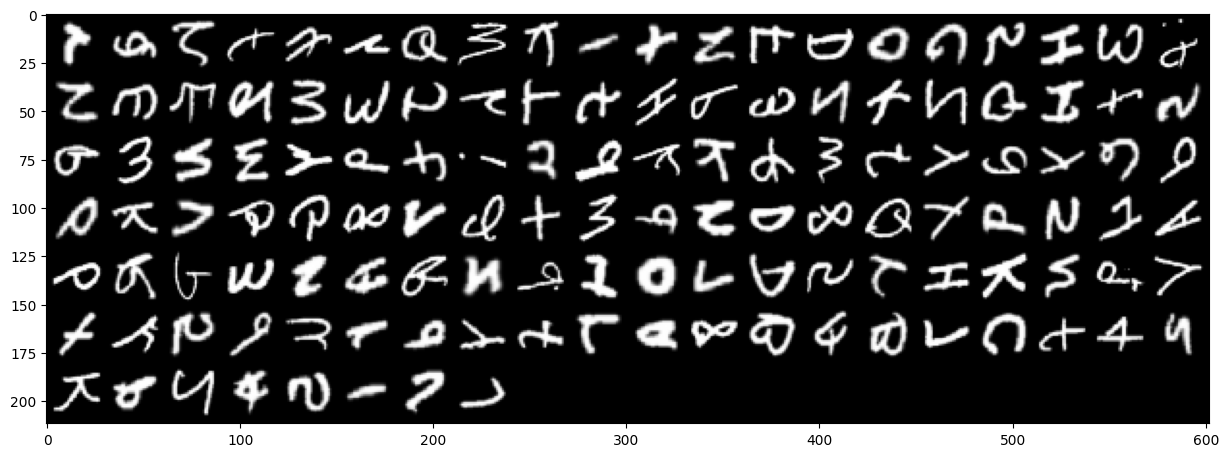

In [7]:
# print out the number of training/testing samples in the dataset
n_train = len(trainSet)
n_test = len(testSet)

print('Number of train data samples in the EMNIST dataset: ', n_train)
print('Number of test data samples in the EMNIST dataset: ', n_test, '\n\n')

# iterating the train data with samples
images, labels = next(iter(trainLoader))

# create a grid of images
grid = torchvision.utils.make_grid(images,nrow=20)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid,(1,2,0)),cmap='gray')

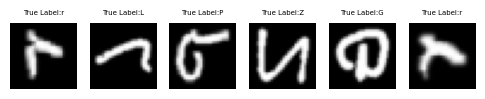

In [8]:
# Visulize some figures
figure = plt.figure(figsize=(6, 6))
cols, rows = 6,1
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainSet), size=(1,)).item()
    img, label = trainSet[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title("True Label:{}".format(dataDict[label]), fontsize= 5)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    
plt.show()



## **Tuning and Implementation of MLP**

In [10]:
# This is the basic class of the MLP neural network
class MLP(nn.Module):
    def __init__(self, model):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.model = model

    # defining the forward pass
    def forward(self, x):
        x = self.flatten(x)
        logits = self.model(x)
        return logits

    # function to calculate the l1 regularisation penalty
    def compute_l1(self, weights):
        return torch.abs(weights).sum()

    # function to calculate the l2 regularisation penalty
    def compute_l2(self, weights):
        return torch.square(weights).sum()

In [11]:
# this function resets the trainable parameters of the layers and also initializes the parameters of a neural network model when a model object is created 
def resetting_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [12]:
inputSize = 28*28
outputSize = 47
hiddenSize = 392

# learning rate
lr = 0.005

lossCriteria = nn.CrossEntropyLoss()

# setting seeds so as to minimise the sources of randomness in the program
torch.manual_seed(7)
random.seed(7)
np.random.seed(7)

n_epochs = 10
n_folds = 4
kfold = KFold(n_splits = n_folds, shuffle = True)

### Base Model
A base MLP model is created which does not have any tuning technique applied to it, and the mode will be tuned using different techniques in such a way that the final tuned model is a much better model for the image classification task at hand.  

---

The softmax activation function is used as the activation function at the output layer of the models because it is the recommended activation function for multiclass classification, which is what the aim of the assignment is. However, we have not explicitly mentioned the softmax function being applied to the data in any of the model architectures as the softmax function is already embedded in the loss function used in the assignment (nn.CrossEntropyLoss() from Pytorch), and hence we do not need to apply the softmax activation explicitly.


In [ ]:
# this code block is inspired from the website mentioned below:
# https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md

# the following is the baseline model with which we will be comparing the performance of all other models
# techniques used : constant learning rate
#                   activation - ReLU
#                   optimizer - SGD
#                   no batch normalisation
#                   no regularisation
#                   without dropout
#                   4 hidden layers
#                   n_neurons in each hidden layer: 392 


baseModel = nn.Sequential(
    nn.Linear(inputSize, hiddenSize, bias = True),
    nn.ReLU(),
    nn.Linear(hiddenSize, hiddenSize, bias = True),
    nn.ReLU(),
    nn.Linear(hiddenSize, hiddenSize, bias = True),
    nn.ReLU(),
    nn.Linear(hiddenSize, hiddenSize, bias = True),
    nn.ReLU(),
    nn.Linear(hiddenSize, outputSize, bias = False)  # including bias in the output layer is probably a good thing if the activation function is sigmoid
)

# to store accuracies of each fold
accuracies = []

# iterating through each fold
for i, (train_id, val_id) in enumerate(kfold.split(trainSet)):
    print(f'Fold #{i+1}\n------------------------')

    # taking random data objects with no replacement 
    trainSampler = SubsetRandomSampler(train_id)
    valSampler = SubsetRandomSampler(val_id)

    # creating dataloader objects for training and validation data in this fold
    train_fold = DataLoader(trainSet, batch_size=128, sampler=trainSampler)
    val_fold = DataLoader(trainSet, batch_size=128, sampler=valSampler)

    # initialising the model and the optimiser
    mlp_base = MLP(baseModel)
    mlp_base.apply(resetting_weights)

    optimizer = optim.SGD(mlp_base.parameters(), lr=0.01)

    # stores the val accuracies of each epoch in the fold (for later purposes, if needed) 
    # and prints the val accuracy of last epoch as the fold val accuracy
    accu_fold = [] 

    # training for a certain number of epochs
    for epoch in range(n_epochs):

        start = time.time() # noting the starting time

        loss = 0
        totalTrain, correct_train_preds = 0, 0
        totalVal, correct_val_preds = 0, 0

        # here, we have taken a fold, and in that fold we have taken an epoch of training, 
        # and in that we are going to traverse through all the batches of data and train the model
        for batch, (images, labels) in enumerate(train_fold):

            optimizer.zero_grad()

            # training the images in this batch and getting accuracy
            output_train = mlp_base(images)

            train_values, train_pred_labels = torch.max(output_train.data, 1)
            totalTrain += labels.size(0)

            correct_train_preds += (labels == train_pred_labels).sum().item()

            # calculating the loss
            current_loss = lossCriteria(output_train, labels)   

            # back propagation
            current_loss.backward()

            # optimising the gradients
            optimizer.step()

            # adding the loss to the overall loss
            loss += current_loss.item()
            if batch % 100 == 99:
                loss = 0

        train_accu = (100 * correct_train_preds) / totalTrain

        end = time.time()
        
        # testing the model obtained in this fold
    
        with torch.no_grad():

            for batch, (images, labels) in enumerate(val_fold):

                output_val = mlp_base(images)

                # max() returns a paired tuple for each row where the first value is the max value present in that row, 
                # and the second value is the index of that max value (like argmax) 
                values, pred_labels = torch.max(output_val.data, 1)
                totalVal += labels.size(0)

                # sum() can even sum up boolean values so that it 
                # sums up the num of 'True' values and 'False' in the tensor
                # item() returns a paired tuple of key-value pairs of a dictionary 
                # where the keys are the different values of the tensor ('True', 'False') and values are their respective counts
                correct_val_preds += (labels == pred_labels).sum().item()

        # calculating accuracy for the fold
        val_accu = (correct_val_preds * 100) / totalVal 
        accu_fold.append(val_accu)

        print(f'\nEpoch {epoch+1}   Train Accuracy: {train_accu}   Validation Accuracy: {val_accu}')
        print(f'Time taken for training epoch {epoch+1}: {end - start} seconds\n')

    # the val accuracy of the last epoch is taken as the final val accuracy of the fold
    print(f'\nValidation accuracy of the fold: {accu_fold[-1]}\n')
    accuracies.append(accu_fold[-1])

# calculating the mean accuracy of the base model 
mean_accu = np.mean(accuracies)
print(f'\n\n Mean Accuracy of Base MLP Model: {mean_accu}')

Fold #1
------------------------

Epoch 1   Train Accuracy: 2.764775413711584   Validation Accuracy: 3.624113475177305
Time taken for training epoch 1: 15.344940662384033 seconds


Epoch 2   Train Accuracy: 4.783687943262412   Validation Accuracy: 6.368794326241135
Time taken for training epoch 2: 18.629504919052124 seconds


Epoch 3   Train Accuracy: 8.332151300236406   Validation Accuracy: 10.039007092198581
Time taken for training epoch 3: 15.498848915100098 seconds


Epoch 4   Train Accuracy: 9.23049645390071   Validation Accuracy: 8.464539007092199
Time taken for training epoch 4: 15.044081211090088 seconds


Epoch 5   Train Accuracy: 9.166666666666666   Validation Accuracy: 9.354609929078014
Time taken for training epoch 5: 16.307979106903076 seconds


Epoch 6   Train Accuracy: 13.31678486997636   Validation Accuracy: 25.666666666666668
Time taken for training epoch 6: 15.919143915176392 seconds


Epoch 7   Train Accuracy: 29.14302600472813   Validation Accuracy: 35.6347517730496


Now, we will try out different options for each of the model tuning techniques and incorporate the best performing techniques to our model as we go ahead.

### Getting the best activation function
Four activation functions are chosen and models are created with each one of them. The models are trained and the activation function which gives the highest accuracy is chosen for the final tuned model.

In [ ]:
activ_functions = {1: nn.ReLU(),
                   2: nn.LeakyReLU(),
                   3: nn.ELU(),
                   4: nn.Tanh()}

# looping through the activ_functions dictionary to train and run a model for each of the specified activation functions
for fn in activ_functions:

    model_activ = nn.Sequential(
        nn.Linear(inputSize, hiddenSize, bias = True),
        activ_functions[fn],
        nn.Linear(hiddenSize, hiddenSize, bias = True),
        activ_functions[fn],
        nn.Linear(hiddenSize, hiddenSize, bias = True),
        activ_functions[fn],
        nn.Linear(hiddenSize, hiddenSize, bias = True),
        activ_functions[fn],
        nn.Linear(hiddenSize, outputSize, bias = False)
    )

    # to store accuracies of each fold
    accuracies_activ = []

    # iterating through each fold
    for i, (train_id, val_id) in enumerate(kfold.split(trainSet)):
        print(f'\nFold #{i+1}\n------------------------')

        # taking random data objects with no replacement 
        trainSampler = SubsetRandomSampler(train_id)
        valSampler = SubsetRandomSampler(val_id)

        # creating dataloader objects for training and validation data in this fold
        train_fold = DataLoader(trainSet, batch_size=128, sampler=trainSampler)
        val_fold = DataLoader(trainSet, batch_size=128, sampler=valSampler)

        # initialising the model and the optimiser
        mlp_activ = MLP(model_activ)
        mlp_activ.apply(resetting_weights)
        optimizer_activ = optim.SGD(mlp_activ.parameters(), lr=0.02)

        # stores val accuracies of each epoch in the fold. 
        # The last item is then printed as the fold val accuracy
        accu_fold = []

        # training for a certain number of epochs
        for epoch in range(n_epochs):

            start = time.time()

            loss = 0
            totalTrain, correct_train_preds = 0, 0
            totalVal, correct_val_preds = 0, 0

            # here, we have taken a fold, and in that fold we have taken an epoch of training, 
            # and in that we are going to traverse through all the batches of data and train the model
            for batch, (images, labels) in enumerate(train_fold):

                optimizer_activ.zero_grad()

                # training the images in this batch and getting accuracy
                output_train = mlp_activ(images)

                train_values, train_pred_labels = torch.max(output_train.data, 1)
                totalTrain += labels.size(0)

                correct_train_preds += (labels == train_pred_labels).sum().item()

                # calculating the loss
                current_loss = lossCriteria(output_train, labels)   

                # back propagation
                current_loss.backward()

                # optimising the gradients
                optimizer_activ.step()

                # adding the loss to the overall loss
                loss += current_loss.item()
                if batch % 100 == 99:
                    loss = 0

            train_accu = (100 * correct_train_preds) / totalTrain
            
            end = time.time()   # noting the ending time for a training session
            
            with torch.no_grad():
                for batch, (images, labels) in enumerate(val_fold):

                    output_val = mlp_activ(images)

                    # max() returns a paired tuple for each row where the first value is the 
                    # max value present in that row, and the second value is the index of that max value (like argmax) 
                    values, pred_labels = torch.max(output_val.data, 1)
                    totalVal += labels.size(0)
                    # sum() can even sum up boolean values so that it sums up the 
                    # num of 'True' values and 'False' in the tensor
                    # item() returns a paired tuple of key-value pairs of a dictionary where the 
                    # keys are the different values of the tensor ('True', 'False') and values are their respective counts
                    correct_val_preds += (labels == pred_labels).sum().item()

            # calculating accuracy for the fold
            val_accu = (correct_val_preds * 100) / totalVal 
            accu_fold.append(val_accu)

            print(f'\nEpoch {epoch+1}   Train Accuracy: {train_accu}   Validation Accuracy: {val_accu}')
            print(f'Time taken for training: {end - start} seconds')

        # the validation accuracy of the last epoch is taken as the validation accuracy 
        # of the particular fold because we have only taken 10 epochs and the accuracies are continuously 
        # increasing with the epochs for almost all of the folds
        print(f'\nValidation accuracy of the fold: {accu_fold[-1]}\n')
        accuracies_activ.append(accu_fold[-1])

    # calculating the mean accuracy of the base model across all folds
    mean_accu = np.mean(accuracies_activ)

    if fn == 1: 
        print(f'\n\nMean Accuracy of MLP Model with ReLU activation: {mean_accu}\n\n')
    elif fn == 2: 
        print(f'\n\nMean Accuracy of MLP Model with Leaky ReLU activation: {mean_accu}\n\n')
    elif fn == 3: 
        print(f'\n\nMean Accuracy of MLP Model with ELU activation: {mean_accu}\n\n')
    elif fn == 4:
        print(f'\n\nMean Accuracy of MLP Model with Tanh activation: {mean_accu}\n\n')


Fold #1
------------------------

Epoch 1   Train Accuracy: 2.1713947990543736   Validation Accuracy: 2.3191489361702127
Time taken for training: 15.298429489135742 seconds

Epoch 2   Train Accuracy: 3.4609929078014185   Validation Accuracy: 4.826241134751773
Time taken for training: 15.374078273773193 seconds

Epoch 3   Train Accuracy: 8.83096926713948   Validation Accuracy: 16.929078014184398
Time taken for training: 15.52137565612793 seconds

Epoch 4   Train Accuracy: 33.712765957446805   Validation Accuracy: 45.716312056737586
Time taken for training: 15.400246620178223 seconds

Epoch 5   Train Accuracy: 50.977541371158395   Validation Accuracy: 55.0
Time taken for training: 16.21264934539795 seconds

Epoch 6   Train Accuracy: 59.54609929078014   Validation Accuracy: 63.03191489361702
Time taken for training: 15.32490086555481 seconds

Epoch 7   Train Accuracy: 65.13120567375887   Validation Accuracy: 67.06737588652483
Time taken for training: 15.189992904663086 seconds

Epoch 8  



The best activation function is ELU.
So going forward, ELU will be used for tuning the model using additional techniques.


### Getting the best optimizer
Since we found ELU to be the best performing activation function, it will be used as the activation function in the hidden layers here onwards.

In [ ]:
model_optim = nn.Sequential(
    nn.Linear(inputSize, hiddenSize, bias = True),
    nn.ELU(),
    nn.Linear(hiddenSize, hiddenSize, bias = True),
    nn.ELU(),
    nn.Linear(hiddenSize, hiddenSize, bias = True),
    nn.ELU(),
    nn.Linear(hiddenSize, hiddenSize, bias = True),
    nn.ELU(),
    nn.Linear(hiddenSize, outputSize, bias = False)
)


optim_functions = {1: 'SGD',
                   2: 'Adam',
                   3: 'RMSprop'}

for fn in optim_functions:

    # to store accuracies of each fold
    accuracies_optim = []


    # iterating through each fold
    for i, (train_id, val_id) in enumerate(kfold.split(trainSet)):
        print(f'\nFold #{i+1}\n------------------------')

        # taking random data objects with no replacement 
        trainSampler = SubsetRandomSampler(train_id)
        valSampler = SubsetRandomSampler(val_id)

        # creating dataloader objects for training and validation data in this fold
        train_fold = DataLoader(trainSet, batch_size=128, sampler=trainSampler)
        val_fold = DataLoader(trainSet, batch_size=128, sampler=valSampler)

        # initialising the model and the optimiser
        mlp_optim = MLP(model_optim)
        mlp_optim.apply(resetting_weights)
        if fn == 1:
            optimizer_optim = optim.SGD(mlp_optim.parameters(), 0.01)
        elif fn == 2:
            optimizer_optim = optim.Adam(mlp_optim.parameters(), 0.001)
        elif fn == 3:
            optimizer_optim = optim.RMSprop(mlp_optim.parameters(), 0.001)
        
        # stores val accuracy of each epoch in the fold, 
        # and prints val accuracy of the last epoch as the val accuracy of the fold
        accu_fold = []

        # training for a certain number of epochs
        for epoch in range(n_epochs):

            start = time.time()

            loss = 0
            totalTrain, correct_train_preds = 0, 0
            totalVal, correct_val_preds = 0, 0

            for batch, (images, labels) in enumerate(train_fold):

                optimizer_optim.zero_grad()

                # training the images in this batch and getting accuracy
                output_train = mlp_optim(images)

                train_values, train_pred_labels = torch.max(output_train.data, 1)
                totalTrain += labels.size(0)

                correct_train_preds += (labels == train_pred_labels).sum().item()

                # calculating the loss 
                current_loss = lossCriteria(output_train, labels)   

                # back propagation
                current_loss.backward()

                # optimising the gradients
                optimizer_optim.step()

                # adding the loss to the overall loss
                loss += current_loss.item()
                if batch % 100 == 99:
                    loss = 0

            train_accu = (100 * correct_train_preds) / totalTrain

            end = time.time()
           
            # testing the model obtained in this fold
            with torch.no_grad():
                for batch, (images, labels) in enumerate(val_fold):

                    output_val = mlp_optim(images)

                    values, pred_labels = torch.max(output_val.data, 1)
                    totalVal += labels.size(0)
                    
                    correct_val_preds += (labels == pred_labels).sum().item()

            # calculating accuracy for the fold
            val_accu = (correct_val_preds * 100) / totalVal 
            accu_fold.append(val_accu)

            print(f'\nEpoch {epoch+1}   Train Accuracy: {train_accu}   Validation Accuracy: {val_accu}')
            print(f'Time taken for training: {end - start} seconds')

        # printing the val accuracy of the fold
        print(f'\nValidation accuracy of the fold: {accu_fold[-1]}\n')
        accuracies_optim.append(accu_fold[-1])

    # calculating the mean accuracy of the base model across all folds
    mean_accu = np.mean(accuracies_optim)

    if fn == 1: 
        print(f'\n\n Mean Accuracy of MLP Model with SGD optimizer: {mean_accu}\n\n')
    elif fn == 2: 
        print(f'\n\n Mean Accuracy of MLP Model with Adam optimizer: {mean_accu}\n\n')
    elif fn == 3: 
        print(f'\n\n Mean Accuracy of MLP Model with RMSprop optimizer: {mean_accu}\n\n')


Fold #1
------------------------
Reset trainable parameters of layer Linear(in_features=784, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=47, bias=False)

Epoch 1   Train Accuracy: 14.515735815602836   Validation Accuracy: 23.20921985815603
Time taken for training: 21.853991508483887 seconds

Epoch 2   Train Accuracy: 18.31006205673759   Validation Accuracy: 23.47517730496454
Time taken for training: 21.71765923500061 seconds

Epoch 3   Train Accuracy: 35.65270390070922   Validation Accuracy: 43.93617021276596
Time taken for training: 21.880727529525757 seconds

Epoch 4   Train Accuracy: 48.41422872340426   Validation Accuracy: 52.6241134751773
Time taken for training: 22.004053115844727 seconds

Epoch 5   Train Accuracy: 55.62278368794326   Validation Accuracy: 57.70390070921986
Time taken for training: 21.18840479850769 seconds

Epoch 6   Train Accuracy: 59.30961879432624   Validation Accuracy: 60.545212765957444
Time taken for training: 21.02585244178772 seconds

Epoch 7   Train Accuracy: 61.85283687943262   Validation Accuracy: 62.87234042553192
Time taken for training: 20.72645092010498 seconds

Epoch 8   Train Accuracy: 63.832003546099294   Validation Accuracy: 64.61879432624113
Time taken for training: 20.902059078216553 seconds

Epoch 9   Train Accuracy: 65.44326241134752   Validation Accuracy: 66.02836879432624
Time taken for training: 21.11395835876465 seconds

Epoch 10   Train Accuracy: 66.87832446808511   Validation Accuracy: 67.1232269503546
Time taken for training: 21.889127492904663 seconds

Validation accuracy of the fold: 67.1232269503546


Fold #2
------------------------
Reset trainable parameters of layer Linear(in_features=784, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=47, bias=False)

Epoch 1   Train Accuracy: 11.22229609929078   Validation Accuracy: 19.40159574468085
Time taken for training: 22.435933351516724 seconds

Epoch 2   Train Accuracy: 18.18816489361702   Validation Accuracy: 24.62322695035461
Time taken for training: 21.35103154182434 seconds

Epoch 3   Train Accuracy: 36.36857269503546   Validation Accuracy: 44.459219858156025
Time taken for training: 22.445300579071045 seconds

Epoch 4   Train Accuracy: 48.632535460992905   Validation Accuracy: 52.84574468085106
Time taken for training: 22.425766706466675 seconds

Epoch 5   Train Accuracy: 55.165115248226954   Validation Accuracy: 57.508865248226954
Time taken for training: 22.649847269058228 seconds

Epoch 6   Train Accuracy: 59.1123670212766   Validation Accuracy: 60.926418439716315
Time taken for training: 22.488020181655884 seconds

Epoch 7   Train Accuracy: 61.99135638297872   Validation Accuracy: 63.133865248226954
Time taken for training: 21.667375802993774 seconds

Epoch 8   Train Accuracy: 63.871897163120565   Validation Accuracy: 64.87145390070921
Time taken for training: 22.584065675735474 seconds

Epoch 9   Train Accuracy: 65.45988475177305   Validation Accuracy: 66.36524822695036
Time taken for training: 22.85239601135254 seconds

Epoch 10   Train Accuracy: 66.78191489361703   Validation Accuracy: 67.60195035460993
Time taken for training: 22.5288245677948 seconds

Validation accuracy of the fold: 67.60195035460993


Fold #3
------------------------
Reset trainable parameters of layer Linear(in_features=784, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=47, bias=False)

Epoch 1   Train Accuracy: 13.147163120567376   Validation Accuracy: 25.75354609929078
Time taken for training: 22.546828746795654 seconds

Epoch 2   Train Accuracy: 23.77770390070922   Validation Accuracy: 26.81294326241135
Time taken for training: 22.783949613571167 seconds

Epoch 3   Train Accuracy: 37.736037234042556   Validation Accuracy: 43.96719858156028
Time taken for training: 21.943841457366943 seconds

Epoch 4   Train Accuracy: 49.049202127659576   Validation Accuracy: 53.262411347517734
Time taken for training: 22.388572454452515 seconds

Epoch 5   Train Accuracy: 55.90757978723404   Validation Accuracy: 57.677304964539005
Time taken for training: 22.588849782943726 seconds

Epoch 6   Train Accuracy: 59.243129432624116   Validation Accuracy: 60.465425531914896
Time taken for training: 22.330825328826904 seconds

Epoch 7   Train Accuracy: 61.822916666666664   Validation Accuracy: 62.548758865248224
Time taken for training: 22.342764616012573 seconds

Epoch 8   Train Accuracy: 64.01817375886525   Validation Accuracy: 64.37943262411348
Time taken for training: 22.463490962982178 seconds

Epoch 9   Train Accuracy: 65.69038120567376   Validation Accuracy: 65.45212765957447
Time taken for training: 21.795063257217407 seconds

Epoch 10   Train Accuracy: 67.01241134751773   Validation Accuracy: 67.06560283687944
Time taken for training: 21.498047828674316 seconds

Validation accuracy of the fold: 67.06560283687944


Fold #4
------------------------
Reset trainable parameters of layer Linear(in_features=784, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=47, bias=False)

Epoch 1   Train Accuracy: 12.257313829787234   Validation Accuracy: 22.26063829787234
Time taken for training: 21.02060866355896 seconds

Epoch 2   Train Accuracy: 20.741356382978722   Validation Accuracy: 25.6781914893617
Time taken for training: 20.601939916610718 seconds

Epoch 3   Train Accuracy: 36.652260638297875   Validation Accuracy: 44.920212765957444
Time taken for training: 20.70914626121521 seconds

Epoch 4   Train Accuracy: 49.393838652482266   Validation Accuracy: 52.765957446808514
Time taken for training: 20.902140855789185 seconds

Epoch 5   Train Accuracy: 55.517508865248224   Validation Accuracy: 57.3758865248227
Time taken for training: 20.601925373077393 seconds

Epoch 6   Train Accuracy: 59.17331560283688   Validation Accuracy: 60.40780141843972
Time taken for training: 21.319788694381714 seconds

Epoch 7   Train Accuracy: 61.788563829787236   Validation Accuracy: 62.5886524822695
Time taken for training: 21.35158610343933 seconds

Epoch 8   Train Accuracy: 63.640292553191486   Validation Accuracy: 64.16666666666667
Time taken for training: 21.612787008285522 seconds

Epoch 9   Train Accuracy: 65.19835992907801   Validation Accuracy: 65.58067375886525
Time taken for training: 21.521682500839233 seconds

Epoch 10   Train Accuracy: 66.66445035460993   Validation Accuracy: 67.06117021276596
Time taken for training: 21.359565496444702 seconds

Validation accuracy of the fold: 67.06117021276596


Fold #5
------------------------
Reset trainable parameters of layer Linear(in_features=784, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=47, bias=False)

Epoch 1   Train Accuracy: 11.744237588652481   Validation Accuracy: 18.83421985815603
Time taken for training: 21.979833841323853 seconds

Epoch 2   Train Accuracy: 17.05119680851064   Validation Accuracy: 24.18439716312057
Time taken for training: 21.592910289764404 seconds

Epoch 3   Train Accuracy: 36.427304964539005   Validation Accuracy: 46.462765957446805
Time taken for training: 21.576653718948364 seconds

Epoch 4   Train Accuracy: 50.63497340425532   Validation Accuracy: 54.4459219858156
Time taken for training: 21.749686002731323 seconds

Epoch 5   Train Accuracy: 56.228945035460995   Validation Accuracy: 58.390957446808514
Time taken for training: 21.446739673614502 seconds

Epoch 6   Train Accuracy: 59.13785460992908   Validation Accuracy: 60.394503546099294
Time taken for training: 21.56345558166504 seconds

Epoch 7   Train Accuracy: 61.472739361702125   Validation Accuracy: 62.726063829787236
Time taken for training: 21.22314214706421 seconds

Epoch 8   Train Accuracy: 63.64472517730496   Validation Accuracy: 64.23758865248227
Time taken for training: 21.363184213638306 seconds

Epoch 9   Train Accuracy: 65.30585106382979   Validation Accuracy: 65.86879432624113
Time taken for training: 22.024680376052856 seconds

Epoch 10   Train Accuracy: 66.74423758865248   Validation Accuracy: 66.99024822695036
Time taken for training: 21.9130699634552 seconds

Validation accuracy of the fold: 66.99024822695036



 Mean Accuracy of Model with SGD optimizer: 67.16843971631207



Fold #1
------------------------
Reset trainable parameters of layer Linear(in_features=784, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=47, bias=False)

Epoch 1   Train Accuracy: 68.27016843971631   Validation Accuracy: 77.20301418439716
Time taken for training: 25.980079412460327 seconds

Epoch 2   Train Accuracy: 79.19437056737588   Validation Accuracy: 80.27039007092199
Time taken for training: 25.77401113510132 seconds

Epoch 3   Train Accuracy: 81.87610815602837   Validation Accuracy: 82.11879432624113
Time taken for training: 25.871752738952637 seconds

Epoch 4   Train Accuracy: 83.24357269503547   Validation Accuracy: 81.64893617021276
Time taken for training: 25.952791213989258 seconds

Epoch 5   Train Accuracy: 84.50908687943263   Validation Accuracy: 82.15425531914893
Time taken for training: 26.659862995147705 seconds

Epoch 6   Train Accuracy: 85.43218085106383   Validation Accuracy: 83.80319148936171
Time taken for training: 26.038843631744385 seconds

Epoch 7   Train Accuracy: 86.51817375886525   Validation Accuracy: 83.05851063829788
Time taken for training: 26.190613746643066 seconds

Epoch 8   Train Accuracy: 86.91600177304964   Validation Accuracy: 83.0186170212766
Time taken for training: 25.846962928771973 seconds

Epoch 9   Train Accuracy: 87.61081560283688   Validation Accuracy: 83.28014184397163
Time taken for training: 26.06041193008423 seconds

Epoch 10   Train Accuracy: 88.08510638297872   Validation Accuracy: 83.61258865248227
Time taken for training: 25.986450910568237 seconds

Validation accuracy of the fold: 83.61258865248227


Fold #2
------------------------
Reset trainable parameters of layer Linear(in_features=784, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=47, bias=False)

Epoch 1   Train Accuracy: 68.36879432624113   Validation Accuracy: 77.14095744680851
Time taken for training: 25.970558643341064 seconds

Epoch 2   Train Accuracy: 79.38829787234043   Validation Accuracy: 80.33687943262412
Time taken for training: 26.154032468795776 seconds

Epoch 3   Train Accuracy: 81.8395390070922   Validation Accuracy: 80.43882978723404
Time taken for training: 25.925705671310425 seconds

Epoch 4   Train Accuracy: 83.23692375886525   Validation Accuracy: 82.66400709219859
Time taken for training: 26.48410701751709 seconds

Epoch 5   Train Accuracy: 84.75509751773049   Validation Accuracy: 82.96099290780141
Time taken for training: 26.269208908081055 seconds

Epoch 6   Train Accuracy: 85.58067375886525   Validation Accuracy: 83.29343971631205
Time taken for training: 26.523343801498413 seconds

Epoch 7   Train Accuracy: 86.44392730496453   Validation Accuracy: 82.74379432624113
Time taken for training: 26.317280530929565 seconds

Epoch 8   Train Accuracy: 86.92265070921985   Validation Accuracy: 83.55496453900709
Time taken for training: 26.451671361923218 seconds

Epoch 9   Train Accuracy: 87.78368794326241   Validation Accuracy: 84.02925531914893
Time taken for training: 26.4383327960968 seconds

Epoch 10   Train Accuracy: 88.09729609929079   Validation Accuracy: 83.61258865248227
Time taken for training: 26.66501808166504 seconds

Validation accuracy of the fold: 83.61258865248227


Fold #3
------------------------
Reset trainable parameters of layer Linear(in_features=784, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=47, bias=False)

Epoch 1   Train Accuracy: 68.16600177304964   Validation Accuracy: 76.83510638297872
Time taken for training: 26.413592100143433 seconds

Epoch 2   Train Accuracy: 79.25531914893617   Validation Accuracy: 80.71365248226951
Time taken for training: 26.387713193893433 seconds

Epoch 3   Train Accuracy: 81.91710992907801   Validation Accuracy: 82.20301418439716
Time taken for training: 25.78364896774292 seconds

Epoch 4   Train Accuracy: 83.15381205673759   Validation Accuracy: 80.65159574468085
Time taken for training: 25.19576334953308 seconds

Epoch 5   Train Accuracy: 84.67198581560284   Validation Accuracy: 82.54432624113475
Time taken for training: 24.887073516845703 seconds

Epoch 6   Train Accuracy: 85.50310283687944   Validation Accuracy: 83.82978723404256
Time taken for training: 24.89310073852539 seconds

Epoch 7   Train Accuracy: 86.2854609929078   Validation Accuracy: 83.59042553191489
Time taken for training: 24.840031385421753 seconds

Epoch 8   Train Accuracy: 87.05673758865248   Validation Accuracy: 83.53280141843972
Time taken for training: 25.272382736206055 seconds

Epoch 9   Train Accuracy: 87.56094858156028   Validation Accuracy: 83.34663120567376
Time taken for training: 25.058135747909546 seconds

Epoch 10   Train Accuracy: 88.16267730496453   Validation Accuracy: 83.79875886524823
Time taken for training: 25.040676593780518 seconds

Validation accuracy of the fold: 83.79875886524823


Fold #4
------------------------
Reset trainable parameters of layer Linear(in_features=784, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=47, bias=False)

Epoch 1   Train Accuracy: 68.27570921985816   Validation Accuracy: 76.10372340425532
Time taken for training: 25.1096773147583 seconds

Epoch 2   Train Accuracy: 79.32291666666667   Validation Accuracy: 80.08421985815603
Time taken for training: 24.94779109954834 seconds

Epoch 3   Train Accuracy: 81.89827127659575   Validation Accuracy: 81.23226950354609
Time taken for training: 25.122700929641724 seconds

Epoch 4   Train Accuracy: 83.13718971631205   Validation Accuracy: 81.4627659574468
Time taken for training: 24.86927103996277 seconds

Epoch 5   Train Accuracy: 84.49689716312056   Validation Accuracy: 81.61790780141844
Time taken for training: 24.85965871810913 seconds

Epoch 6   Train Accuracy: 85.45101950354609   Validation Accuracy: 81.92819148936171
Time taken for training: 24.709524393081665 seconds

Epoch 7   Train Accuracy: 86.19570035460993   Validation Accuracy: 82.24734042553192
Time taken for training: 24.945061206817627 seconds

Epoch 8   Train Accuracy: 87.11990248226951   Validation Accuracy: 83.46631205673759
Time taken for training: 25.306473970413208 seconds

Epoch 9   Train Accuracy: 87.46786347517731   Validation Accuracy: 84.04255319148936
Time taken for training: 25.435596227645874 seconds

Epoch 10   Train Accuracy: 88.05851063829788   Validation Accuracy: 83.73226950354609
Time taken for training: 24.78418779373169 seconds

Validation accuracy of the fold: 83.73226950354609


Fold #5
------------------------
Reset trainable parameters of layer Linear(in_features=784, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=47, bias=False)

Epoch 1   Train Accuracy: 68.60926418439716   Validation Accuracy: 76.27659574468085
Time taken for training: 25.03347659111023 seconds

Epoch 2   Train Accuracy: 79.3107269503546   Validation Accuracy: 80.15514184397163
Time taken for training: 25.049729824066162 seconds

Epoch 3   Train Accuracy: 82.22185283687944   Validation Accuracy: 80.45656028368795
Time taken for training: 24.89522624015808 seconds

Epoch 4   Train Accuracy: 83.42087765957447   Validation Accuracy: 82.25620567375887
Time taken for training: 24.96965503692627 seconds

Epoch 5   Train Accuracy: 84.37721631205673   Validation Accuracy: 82.03457446808511
Time taken for training: 26.17688298225403 seconds

Epoch 6   Train Accuracy: 85.45212765957447   Validation Accuracy: 82.6063829787234
Time taken for training: 26.083674669265747 seconds

Epoch 7   Train Accuracy: 86.27770390070921   Validation Accuracy: 83.50620567375887
Time taken for training: 26.772587060928345 seconds

Epoch 8   Train Accuracy: 86.91821808510639   Validation Accuracy: 83.31117021276596
Time taken for training: 26.173155784606934 seconds

Epoch 9   Train Accuracy: 87.41356382978724   Validation Accuracy: 82.56648936170212
Time taken for training: 25.981388092041016 seconds

Epoch 10   Train Accuracy: 88.03191489361703   Validation Accuracy: 83.79432624113475
Time taken for training: 26.226532697677612 seconds

Validation accuracy of the fold: 83.79432624113475



 Mean Accuracy of Model with Adam optimizer: 83.71010638297872



Fold #1
------------------------
Reset trainable parameters of layer Linear(in_features=784, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=47, bias=False)

Epoch 1   Train Accuracy: 60.14849290780142   Validation Accuracy: 75.32358156028369
Time taken for training: 24.31588387489319 seconds

Epoch 2   Train Accuracy: 77.26174645390071   Validation Accuracy: 79.46365248226951
Time taken for training: 24.283963441848755 seconds

Epoch 3   Train Accuracy: 80.69481382978724   Validation Accuracy: 81.42287234042553
Time taken for training: 23.891481399536133 seconds

Epoch 4   Train Accuracy: 82.78590425531915   Validation Accuracy: 82.09219858156028
Time taken for training: 24.059381246566772 seconds

Epoch 5   Train Accuracy: 84.34064716312056   Validation Accuracy: 81.9104609929078
Time taken for training: 24.030840635299683 seconds

Epoch 6   Train Accuracy: 85.33133865248227   Validation Accuracy: 82.89893617021276
Time taken for training: 24.169177293777466 seconds

Epoch 7   Train Accuracy: 86.24556737588652   Validation Accuracy: 83.59042553191489
Time taken for training: 23.694612741470337 seconds

Epoch 8   Train Accuracy: 87.0877659574468   Validation Accuracy: 83.1604609929078
Time taken for training: 23.84622573852539 seconds

Epoch 9   Train Accuracy: 87.64073581560284   Validation Accuracy: 83.79432624113475
Time taken for training: 24.022842168807983 seconds

Epoch 10   Train Accuracy: 88.32335992907801   Validation Accuracy: 83.66134751773049
Time taken for training: 23.940852403640747 seconds

Validation accuracy of the fold: 83.66134751773049


Fold #2
------------------------
Reset trainable parameters of layer Linear(in_features=784, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=47, bias=False)

Epoch 1   Train Accuracy: 59.36281028368794   Validation Accuracy: 76.38297872340425
Time taken for training: 23.90117335319519 seconds

Epoch 2   Train Accuracy: 76.87721631205673   Validation Accuracy: 78.55939716312056
Time taken for training: 23.949602127075195 seconds

Epoch 3   Train Accuracy: 80.59951241134752   Validation Accuracy: 81.48936170212765
Time taken for training: 24.05129313468933 seconds

Epoch 4   Train Accuracy: 82.87123226950355   Validation Accuracy: 82.73492907801419
Time taken for training: 23.974649906158447 seconds

Epoch 5   Train Accuracy: 84.1334219858156   Validation Accuracy: 83.08510638297872
Time taken for training: 23.892764568328857 seconds

Epoch 6   Train Accuracy: 85.30031028368795   Validation Accuracy: 83.20921985815603
Time taken for training: 23.885900020599365 seconds

Epoch 7   Train Accuracy: 86.29543439716312   Validation Accuracy: 83.03634751773049
Time taken for training: 23.904333114624023 seconds

Epoch 8   Train Accuracy: 87.10438829787235   Validation Accuracy: 83.75443262411348
Time taken for training: 23.97323441505432 seconds

Epoch 9   Train Accuracy: 87.677304964539   Validation Accuracy: 84.63652482269504
Time taken for training: 23.870736598968506 seconds

Epoch 10   Train Accuracy: 88.260195035461   Validation Accuracy: 83.8563829787234
Time taken for training: 23.821480751037598 seconds

Validation accuracy of the fold: 83.8563829787234


Fold #3
------------------------
Reset trainable parameters of layer Linear(in_features=784, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=47, bias=False)

Epoch 1   Train Accuracy: 61.84175531914894   Validation Accuracy: 71.4982269503546
Time taken for training: 24.025484323501587 seconds

Epoch 2   Train Accuracy: 77.29831560283688   Validation Accuracy: 79.49911347517731
Time taken for training: 23.822574138641357 seconds

Epoch 3   Train Accuracy: 81.0372340425532   Validation Accuracy: 81.77304964539007
Time taken for training: 23.91642427444458 seconds

Epoch 4   Train Accuracy: 82.8690159574468   Validation Accuracy: 82.5709219858156
Time taken for training: 23.822551250457764 seconds

Epoch 5   Train Accuracy: 84.45367907801419   Validation Accuracy: 81.99911347517731
Time taken for training: 22.661681652069092 seconds

Epoch 6   Train Accuracy: 85.47318262411348   Validation Accuracy: 81.72429078014184
Time taken for training: 22.931257009506226 seconds

Epoch 7   Train Accuracy: 86.23781028368795   Validation Accuracy: 82.18971631205673
Time taken for training: 22.683266162872314 seconds

Epoch 8   Train Accuracy: 87.09330673758865   Validation Accuracy: 83.57712765957447
Time taken for training: 22.787797212600708 seconds

Epoch 9   Train Accuracy: 87.82025709219859   Validation Accuracy: 82.68617021276596
Time taken for training: 22.831552267074585 seconds

Epoch 10   Train Accuracy: 88.49844858156028   Validation Accuracy: 83.88297872340425
Time taken for training: 22.823044538497925 seconds

Validation accuracy of the fold: 83.88297872340425


Fold #4
------------------------
Reset trainable parameters of layer Linear(in_features=784, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=47, bias=False)

Epoch 1   Train Accuracy: 59.99002659574468   Validation Accuracy: 75.35460992907801
Time taken for training: 22.688844680786133 seconds

Epoch 2   Train Accuracy: 76.83067375886525   Validation Accuracy: 78.43971631205673
Time taken for training: 22.58796525001526 seconds

Epoch 3   Train Accuracy: 80.93639184397163   Validation Accuracy: 80.38120567375887
Time taken for training: 23.005749464035034 seconds

Epoch 4   Train Accuracy: 82.68284574468085   Validation Accuracy: 81.7686170212766
Time taken for training: 22.66341257095337 seconds

Epoch 5   Train Accuracy: 84.21542553191489   Validation Accuracy: 82.88563829787235
Time taken for training: 23.864068269729614 seconds

Epoch 6   Train Accuracy: 85.47872340425532   Validation Accuracy: 82.82801418439716
Time taken for training: 23.262997150421143 seconds

Epoch 7   Train Accuracy: 86.36746453900709   Validation Accuracy: 83.36436170212765
Time taken for training: 23.523029088974 seconds

Epoch 8   Train Accuracy: 87.16201241134752   Validation Accuracy: 83.11613475177305
Time taken for training: 23.095518350601196 seconds

Epoch 9   Train Accuracy: 87.97761524822695   Validation Accuracy: 83.02304964539007
Time taken for training: 23.28798770904541 seconds

Epoch 10   Train Accuracy: 88.38984929078015   Validation Accuracy: 82.94326241134752
Time taken for training: 23.39875602722168 seconds

Validation accuracy of the fold: 82.94326241134752


Fold #5
------------------------
Reset trainable parameters of layer Linear(in_features=784, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=512, bias=True)
Reset trainable parameters of layer Linear(in_features=512, out_features=47, bias=False)

Epoch 1   Train Accuracy: 60.21719858156028   Validation Accuracy: 70.54521276595744
Time taken for training: 24.04296350479126 seconds

Epoch 2   Train Accuracy: 76.9957890070922   Validation Accuracy: 80.50088652482269
Time taken for training: 24.12966537475586 seconds

Epoch 3   Train Accuracy: 80.760195035461   Validation Accuracy: 80.42109929078015
Time taken for training: 22.85332727432251 seconds

Epoch 4   Train Accuracy: 82.96653368794327   Validation Accuracy: 81.01507092198581
Time taken for training: 23.741092205047607 seconds

Epoch 5   Train Accuracy: 84.30296985815603   Validation Accuracy: 83.302304964539
Time taken for training: 24.01364517211914 seconds

Epoch 6   Train Accuracy: 85.3479609929078   Validation Accuracy: 81.90159574468085
Time taken for training: 23.867421865463257 seconds

Epoch 7   Train Accuracy: 86.35749113475177   Validation Accuracy: 82.02127659574468
Time taken for training: 23.94486427307129 seconds

Epoch 8   Train Accuracy: 87.15425531914893   Validation Accuracy: 84.06914893617021
Time taken for training: 24.488601207733154 seconds

Epoch 9   Train Accuracy: 87.74268617021276   Validation Accuracy: 81.55585106382979
Time taken for training: 24.02320146560669 seconds

Epoch 10   Train Accuracy: 88.38874113475177   Validation Accuracy: 83.64804964539007
Time taken for training: 24.036035537719727 seconds

Validation accuracy of the fold: 83.64804964539007



 Mean Accuracy of Model with RMSprop optimizer: 83.59840425531915

Adam provides the highest performance among all the optimizers for the image classification task. Hence it is chosen to be the activation function for our tuned model. 

### Using Batch Normalisation
Batch normalisation is done to normalise the batches so as to bring the scale of each input feature to the same scale so that weight updates can take place in the right manner.

This step is mostly done before passing the data through the activation function, but can also be done after the activation step.


In [ ]:
# batchnorm is done to normalise the input before sending the data to the input layer
# which can also be done as a separate step after loading of the data
model_batchnorm = nn.Sequential(
    nn.BatchNorm1d(inputSize), 
    nn.Linear(inputSize, hiddenSize, bias = True),
    nn.BatchNorm1d(hiddenSize),
    nn.ELU(),
    nn.Linear(hiddenSize, hiddenSize, bias = True),
    nn.BatchNorm1d(hiddenSize),
    nn.ELU(),
    nn.Linear(hiddenSize, hiddenSize, bias = True),
    nn.BatchNorm1d(hiddenSize),
    nn.ELU(),
    nn.Linear(hiddenSize, hiddenSize, bias = True),
    nn.BatchNorm1d(hiddenSize),
    nn.ELU(),
    nn.Linear(hiddenSize, outputSize, bias = False)
)

In [ ]:
# to store accuracies of each fold
accuracies_bn = []


# iterating through each fold
for i, (train_id, val_id) in enumerate(kfold.split(trainSet)):
    print(f'\nFold #{i+1}\n------------------------')

    # taking random data objects with no replacement 
    trainSampler = SubsetRandomSampler(train_id)
    valSampler = SubsetRandomSampler(val_id)

    # creating dataloader objects for training and validation data in this fold
    train_fold = DataLoader(trainSet, batch_size=128, sampler=trainSampler)
    val_fold = DataLoader(trainSet, batch_size=128, sampler=valSampler)

    # initialising the model and the optimiser
    mlp_bn = MLP(model_batchnorm)
    mlp_bn.apply(resetting_weights)
    optimizer_bn = optim.Adam(mlp_bn.parameters(), lr=0.001)

    accu_fold = []

    # training for a certain number of epochs
    for epoch in range(n_epochs):

        start = time.time() 

        loss = 0
        totalTrain, correct_train_preds = 0, 0
        totalVal, correct_val_preds = 0, 0

        for batch, (images, labels) in enumerate(train_fold):

            optimizer_bn.zero_grad()

            # training the images in this batch and getting accuracy
            output_train = mlp_bn(images)

            train_values, train_pred_labels = torch.max(output_train.data, 1)
            totalTrain += labels.size(0)

            correct_train_preds += (labels == train_pred_labels).sum().item() 

            # calculating the loss
            current_loss = lossCriteria(output_train, labels)   

            # back propagation
            current_loss.backward()

            # optimising the gradients
            optimizer_bn.step()

            # adding the loss to the overall loss
            loss += current_loss.item()
            if batch % 100 == 99:
                loss = 0

        train_accu = (100 * correct_train_preds) / totalTrain

        end = time.time()   
        
        # testing the model obtained in this fold
        with torch.no_grad():
            for batch, (images, labels) in enumerate(val_fold):

                output_val = mlp_bn(images)

                values, pred_labels = torch.max(output_val.data, 1)
                totalVal += labels.size(0)
                correct_val_preds += (labels == pred_labels).sum().item()

        # calculating val accuracy for the epoch
        val_accu = (correct_val_preds * 100) / totalVal 
        accu_fold.append(val_accu)

        print(f'\nEpoch {epoch+1}   Train Accuracy: {train_accu}   Validation Accuracy: {val_accu}')
        print(f'Time taken for training fold: {end - start} seconds')

    # printing the val accuracy of the fold
    print(f'\nValidation accuracy of the fold: {accu_fold[-1]}\n')
    accuracies_bn.append(accu_fold[-1])

# calculating the mean accuracy of the base model across all folds
mean_accu = np.mean(accuracies_bn)

print(f'\n\n Mean Accuracy of MLP Model with Batch Normalisation: {mean_accu}\n\n')


Fold #1
------------------------
Reset trainable parameters of layer BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=784, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=47, bias=False)

Epoch 1   Train Accuracy: 71.09707446808511   Validation Accuracy: 77.70390070921985
Time taken for training fold: 23.899031162261963 seconds

Epoch 2   Train Accuracy: 79.55895390070921   Validation Accuracy: 80.74024822695036
Time taken for training fold: 24.458253622055054 seconds

Epoch 3   Train Accuracy: 81.97584219858156   Validation Accuracy: 82.2872340425532
Time taken for training fold: 22.206533670425415 seconds

Epoch 4   Train Accuracy: 83.4729609929078   Validation Accuracy: 81.54255319148936
Time taken for training fold: 22.806959867477417 seconds

Epoch 5   Train Accuracy: 84.41600177304964   Validation Accuracy: 82.59751773049645
Time taken for training fold: 22.615118503570557 seconds

Epoch 6   Train Accuracy: 85.20833333333333   Validation Accuracy: 83.69680851063829
Time taken for training fold: 22.583418607711792 seconds

Epoch 7   Train Accuracy: 85.92420212765957   Validation Accuracy: 83.68794326241135
Time taken for training fold: 22.121026039123535 seconds

Epoch 8   Train Accuracy: 86.43062943262412   Validation Accuracy: 84.06471631205673
Time taken for training fold: 22.967276334762573 seconds

Epoch 9   Train Accuracy: 86.98249113475177   Validation Accuracy: 83.54609929078015
Time taken for training fold: 22.917962789535522 seconds

Epoch 10   Train Accuracy: 87.15425531914893   Validation Accuracy: 84.40602836879432
Time taken for training fold: 22.936199426651 seconds

Validation accuracy of the fold: 84.40602836879432


Fold #2
------------------------
Reset trainable parameters of layer BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=784, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=47, bias=False)

Epoch 1   Train Accuracy: 71.29654255319149   Validation Accuracy: 77.46010638297872
Time taken for training fold: 22.761059045791626 seconds

Epoch 2   Train Accuracy: 79.72960992907801   Validation Accuracy: 79.77393617021276
Time taken for training fold: 22.948489665985107 seconds

Epoch 3   Train Accuracy: 82.14317375886525   Validation Accuracy: 81.25886524822695
Time taken for training fold: 22.434808492660522 seconds

Epoch 4   Train Accuracy: 83.44414893617021   Validation Accuracy: 82.36258865248227
Time taken for training fold: 22.782914876937866 seconds

Epoch 5   Train Accuracy: 84.33621453900709   Validation Accuracy: 82.85460992907801
Time taken for training fold: 22.77362370491028 seconds

Epoch 6   Train Accuracy: 85.34463652482269   Validation Accuracy: 83.28457446808511
Time taken for training fold: 22.755587816238403 seconds

Epoch 7   Train Accuracy: 85.81117021276596   Validation Accuracy: 83.77659574468085
Time taken for training fold: 22.656532764434814 seconds

Epoch 8   Train Accuracy: 86.55141843971631   Validation Accuracy: 83.88297872340425
Time taken for training fold: 22.500982999801636 seconds

Epoch 9   Train Accuracy: 86.76529255319149   Validation Accuracy: 84.04255319148936
Time taken for training fold: 22.63344407081604 seconds

Epoch 10   Train Accuracy: 87.36037234042553   Validation Accuracy: 83.83865248226951
Time taken for training fold: 22.700851678848267 seconds

Validation accuracy of the fold: 83.83865248226951


Fold #3
------------------------
Reset trainable parameters of layer BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=784, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=47, bias=False)

Epoch 1   Train Accuracy: 70.93639184397163   Validation Accuracy: 77.26950354609929
Time taken for training fold: 22.111756324768066 seconds

Epoch 2   Train Accuracy: 79.60549645390071   Validation Accuracy: 81.20567375886525
Time taken for training fold: 22.895273685455322 seconds

Epoch 3   Train Accuracy: 82.05119680851064   Validation Accuracy: 81.56028368794327
Time taken for training fold: 22.542054653167725 seconds

Epoch 4   Train Accuracy: 83.59485815602837   Validation Accuracy: 82.24734042553192
Time taken for training fold: 22.721551656723022 seconds

Epoch 5   Train Accuracy: 84.34951241134752   Validation Accuracy: 82.92109929078015
Time taken for training fold: 22.503472089767456 seconds

Epoch 6   Train Accuracy: 85.16622340425532   Validation Accuracy: 83.42198581560284
Time taken for training fold: 22.66594123840332 seconds

Epoch 7   Train Accuracy: 85.88984929078015   Validation Accuracy: 83.59485815602837
Time taken for training fold: 22.550598859786987 seconds

Epoch 8   Train Accuracy: 86.32646276595744   Validation Accuracy: 84.11790780141844
Time taken for training fold: 22.36568546295166 seconds

Epoch 9   Train Accuracy: 86.96365248226951   Validation Accuracy: 84.06914893617021
Time taken for training fold: 22.274904012680054 seconds

Epoch 10   Train Accuracy: 87.24179964539007   Validation Accuracy: 84.56560283687944
Time taken for training fold: 22.66878342628479 seconds

Validation accuracy of the fold: 84.56560283687944


Fold #4
------------------------
Reset trainable parameters of layer BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=784, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=47, bias=False)

Epoch 1   Train Accuracy: 71.04609929078015   Validation Accuracy: 77.45124113475177
Time taken for training fold: 22.49978470802307 seconds

Epoch 2   Train Accuracy: 79.62433510638297   Validation Accuracy: 80.25709219858156
Time taken for training fold: 22.6500883102417 seconds

Epoch 3   Train Accuracy: 82.06117021276596   Validation Accuracy: 81.13918439716312
Time taken for training fold: 22.5828218460083 seconds

Epoch 4   Train Accuracy: 83.53945035460993   Validation Accuracy: 81.76418439716312
Time taken for training fold: 22.83095407485962 seconds

Epoch 5   Train Accuracy: 84.5168439716312   Validation Accuracy: 82.677304964539
Time taken for training fold: 22.771810293197632 seconds

Epoch 6   Train Accuracy: 85.0498670212766   Validation Accuracy: 83.21365248226951
Time taken for training fold: 22.030293226242065 seconds

Epoch 7   Train Accuracy: 85.91533687943263   Validation Accuracy: 83.63918439716312
Time taken for training fold: 23.408478021621704 seconds

Epoch 8   Train Accuracy: 86.57579787234043   Validation Accuracy: 84.00265957446808
Time taken for training fold: 23.47529172897339 seconds

Epoch 9   Train Accuracy: 87.01906028368795   Validation Accuracy: 84.20212765957447
Time taken for training fold: 23.158379793167114 seconds

Epoch 10   Train Accuracy: 87.45456560283688   Validation Accuracy: 84.2331560283688
Time taken for training fold: 23.098487854003906 seconds

Validation accuracy of the fold: 84.2331560283688


Fold #5
------------------------
Reset trainable parameters of layer BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=784, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=47, bias=False)

Epoch 1   Train Accuracy: 71.02726063829788   Validation Accuracy: 76.81294326241135
Time taken for training fold: 22.86502766609192 seconds

Epoch 2   Train Accuracy: 79.68971631205673   Validation Accuracy: 80.31028368794327
Time taken for training fold: 22.011927366256714 seconds

Epoch 3   Train Accuracy: 82.27726063829788   Validation Accuracy: 81.41400709219859
Time taken for training fold: 22.87356448173523 seconds

Epoch 4   Train Accuracy: 83.5228280141844   Validation Accuracy: 82.15868794326241
Time taken for training fold: 23.755356550216675 seconds

Epoch 5   Train Accuracy: 84.43816489361703   Validation Accuracy: 82.947695035461
Time taken for training fold: 23.349456310272217 seconds

Epoch 6   Train Accuracy: 85.19614361702128   Validation Accuracy: 82.9831560283688
Time taken for training fold: 22.984910011291504 seconds

Epoch 7   Train Accuracy: 85.89649822695036   Validation Accuracy: 83.74556737588652
Time taken for training fold: 22.99175214767456 seconds

Epoch 8   Train Accuracy: 86.59131205673759   Validation Accuracy: 83.77659574468085
Time taken for training fold: 22.43526601791382 seconds

Epoch 9   Train Accuracy: 86.9813829787234   Validation Accuracy: 84.16666666666667
Time taken for training fold: 22.928297519683838 seconds

Epoch 10   Train Accuracy: 87.53213652482269   Validation Accuracy: 84.28634751773049
Time taken for training fold: 23.134767293930054 seconds

Validation accuracy of the fold: 84.28634751773049



 Mean Accuracy of Model with Batch Normalisation: 84.26595744680851

Using batch normalisation in the model leads to a slight improvement in the accuracy. Even though the improvement is not much, it is enough for incorporating batch normalisation in the model.

### Using Regularisation

The model obtained in the section above does not involve any regularisation. Now, 3 models - with no regularisation, with L1 (Lasso) regularisation, with L2 (Ridge) regularisation - will be made and which regularisation technique, if at all, gives the best results.

In [ ]:
model_batchnorm = nn.Sequential(
    nn.BatchNorm1d(inputSize),
    nn.Linear(inputSize, hiddenSize, bias = True),
    nn.BatchNorm1d(hiddenSize),
    nn.ELU(),
    nn.Linear(hiddenSize, hiddenSize, bias = True),
    nn.BatchNorm1d(hiddenSize),
    nn.ELU(),
    nn.Linear(hiddenSize, hiddenSize, bias = True),
    nn.BatchNorm1d(hiddenSize),
    nn.ELU(),
    nn.Linear(hiddenSize, hiddenSize, bias = True),
    nn.BatchNorm1d(hiddenSize),
    nn.ELU(),
    nn.Linear(hiddenSize, outputSize, bias = False)
)

In [ ]:
# to store accuracies of each fold for l1 regularisation
accuracies_l1 = []
# to store accuracies of each fold for l2 regularisation
accuracies_l2 = []

# defining 3 options for the regularisation coefficients in the format (l1_coefficient, l2_coefficient)
weights = [(0.0001, 0.0005), (0.0002, 0.0006), (0.0003, 0.0007)]

for (l1_weight, l2_weight) in weights:
  print('l1_weight', l1_weight)
  print('l2_weight', l2_weight)

  # iterating through each fold
  for i, (train_id, val_id) in enumerate(kfold.split(trainSet)):
      print(f'\nFold #{i+1}\n------------------------')

      # taking random data objects with no replacement 
      trainSampler = SubsetRandomSampler(train_id)
      valSampler = SubsetRandomSampler(val_id)

      # creating dataloader objects for training and validation data in this fold
      train_fold = DataLoader(trainSet, batch_size=128, sampler=trainSampler)
      val_fold = DataLoader(trainSet, batch_size=128, sampler=valSampler)

      # initialising the model and the optimiser
      mlp_l1 = MLP(model_batchnorm)
      mlp_l1.apply(resetting_weights)
      optimizer_l1 = optim.Adam(mlp_l1.parameters(), lr=0.001)

      mlp_l2 = MLP(model_batchnorm)
      mlp_l2.apply(resetting_weights)
      optimizer_l2 = optim.Adam(mlp_l2.parameters(), lr=0.001, weight_decay = 1e-5)

      accu_fold_l1, accu_fold_l2 = [], []

      # training for a certain number of epochs
      for epoch in range(n_epochs):

          start = time.time() 

          loss_l1, loss_l2 = 0, 0
          totalTrain, correct_train_preds_l1, correct_train_preds_l2 = 0, 0, 0
          totalVal, correct_val_preds_l1, correct_val_preds_l2 = 0, 0, 0

          for batch, (images, labels) in enumerate(train_fold):

              optimizer_l1.zero_grad()
              optimizer_l2.zero_grad()

              # training the images in this batch and getting accuracies
              # for l1
              output_train_l1 = mlp_l1(images)
              train_values_l1, train_pred_labels_l1 = torch.max(output_train_l1.data, 1)
              
              correct_train_preds_l1 += (labels == train_pred_labels_l1).sum().item()

              # for l2
              output_train_l2 = mlp_l2(images)
              train_values_l2, train_pred_labels_l2 = torch.max(output_train_l2.data, 1)
              
              correct_train_preds_l2 += (labels == train_pred_labels_l2).sum().item()

              totalTrain += labels.size(0)


              # calculating the loss
              current_loss_l1 = lossCriteria(output_train_l1, labels)   
              current_loss_l2 = lossCriteria(output_train_l2, labels)  

              # computing l1 & l2 loss
              l1_params = []
              l2_params = []

              for parameter in mlp_l1.parameters():
                  l1_params.append(parameter.view(-1))
              l1 = l1_weight*mlp_l1.compute_l1(torch.cat(l1_params))

              for parameter in mlp_l2.parameters():
                  l2_params.append(parameter.view(-1))
              l2 = l2_weight*mlp_l2.compute_l2(torch.cat(l2_params))

              # adding the regularisation losses to the cost function loss
              current_loss_l1 += l1
              current_loss_l2 += l2

              # backprop
              current_loss_l1.backward()
              current_loss_l2.backward()

              # optimising the gradients
              optimizer_l1.step()
              optimizer_l2.step()

              # adding the loss to the overall loss
              loss_l1 += current_loss_l1.item()
              loss_l2 += current_loss_l2.item()
              if batch % 100 == 99:
                  loss_l1, loss_l2 = 0, 0

          train_accu_l1 = (100 * correct_train_preds_l1) / totalTrain
          train_accu_l2 = (100 * correct_train_preds_l2) / totalTrain

          end = time.time()   
          
          # testing the model obtained in this fold
          with torch.no_grad():

              for batch, (images, labels) in enumerate(val_fold):

                  output_val_l1 = mlp_l1(images)
                  output_val_l2 = mlp_l2(images)

                  # max() returns a paired tuple for each row where the first value is the max value present 
                  # in that row, and the second value is the index of that max value (like argmax) 
                  values_l1, pred_labels_l1 = torch.max(output_val_l1.data, 1)
                  values_l2, pred_labels_l2 = torch.max(output_val_l2.data, 1)
                  totalVal += labels.size(0)
                  
                  correct_val_preds_l1 += (labels == pred_labels_l1).sum().item()
                  correct_val_preds_l2 += (labels == pred_labels_l2).sum().item()

          # calculating val accuracy for the epoch
          val_accu_l1 = (correct_val_preds_l1 * 100) / totalVal 
          val_accu_l2 = (correct_val_preds_l2 * 100) / totalVal

          accu_fold_l1.append(val_accu_l1)
          accu_fold_l2.append(val_accu_l2)

          print(f'''\n  Epoch {epoch+1}   Train Accuracy (L1): {train_accu_l1}   Validation Accuracy (L1): {val_accu_l1}
              Train Accuracy (L2): {train_accu_l2}   Validation Accuracy (L2): {val_accu_l2}''')
          print(f'Time taken for training: {end - start} seconds')

      # printing the val accuracy of the fold
      print(f'\nValidation accuracy of the fold (L1): {accu_fold_l1[-1]}')
      accuracies_l1.append(accu_fold_l1[-1])
      print(f'\nValidation accuracy of the fold (L2): {accu_fold_l2[-1]}\n')
      accuracies_l2.append(accu_fold_l2[-1])
      
  # calculating the mean accuracy of models across all folds
  mean_accu_l1 = np.mean(accuracies_l1)
  print(f'\n\n Mean Accuracy of MLP Model with L1 (Lasso) Regularisation: {mean_accu_l1}\n')

  mean_accu_l2 = np.mean(accuracies_l2)
  print(f'\n Mean Accuracy of MLP Model with L2 (Ridge) Regularisation: {mean_accu_l2}\n\n')

### Using Dropout
Dropout is a also a regularisation technique which has often been found to be quite useful in improving the performance of the models. It is added to the model and will be checked whether it leads to any improvement in the performance of our model.

In [ ]:
model_drop = nn.Sequential(
    nn.BatchNorm1d(inputSize), 
    nn.Linear(inputSize, hiddenSize, bias = True),
    nn.BatchNorm1d(hiddenSize),
    nn.ELU(),
    nn.Dropout(0.2),
    nn.Linear(hiddenSize, hiddenSize, bias = True),
    nn.BatchNorm1d(hiddenSize),
    nn.ELU(),
    nn.Dropout(0.3),
    nn.Linear(hiddenSize, hiddenSize, bias = True),
    nn.BatchNorm1d(hiddenSize),
    nn.ELU(),
    nn.Dropout(0.3),
    nn.Linear(hiddenSize, hiddenSize, bias = True),
    nn.BatchNorm1d(hiddenSize),
    nn.ELU(),
    nn.Linear(hiddenSize, outputSize, bias = False)
)

In [ ]:
# to store accuracies of each fold
accuracies_dp = []


# iterating through each fold
for i, (train_id, val_id) in enumerate(kfold.split(trainSet)):
    print(f'\nFold #{i+1}\n------------------------')

    # taking random data objects with no replacement 
    train_sampler = SubsetRandomSampler(train_id)
    val_sampler = SubsetRandomSampler(val_id)

    # creating dataloader objects for training and validation data in this fold
    train_fold = DataLoader(trainSet, batch_size=128, sampler=train_sampler)
    val_fold = DataLoader(trainSet, batch_size=128, sampler=val_sampler)

    # initialising the model and the optimiser
    mlp_drop = MLP(model_drop)
    mlp_drop.apply(resetting_weights)
    optimizer_dp = optim.Adam(mlp_drop.parameters(), lr=0.01)

    accu_fold = []

    # training for a certain number of epochs
    for epoch in range(n_epochs):

        start = time.time() 

        loss = 0
        totalTrain, correct_train_preds = 0, 0
        totalVal, correct_val_preds = 0, 0

        for batch, (images, labels) in enumerate(train_fold):

            optimizer_dp.zero_grad()

            # training the images in this batch and getting accuracy
            output_train = mlp_drop(images)

            train_values, train_pred_labels = torch.max(output_train.data, 1)
            totalTrain += labels.size(0)

            correct_train_preds += (labels == train_pred_labels).sum().item() 

            # calculating the loss
            current_loss = lossCriteria(output_train, labels)   

            # back propagation
            current_loss.backward()

            # optimising the gradients
            optimizer_dp.step()

            # adding the loss to the overall loss
            loss += current_loss.item()
            if batch % 100 == 99:
                loss = 0

        train_accu = (100 * correct_train_preds) / totalTrain

        end = time.time()   

        # testing the model obtained in this fold
        with torch.no_grad():
            for batch, (images, labels) in enumerate(val_fold):

                output_val = mlp_drop(images)

                # max() returns a paired tuple for each row where the first value is the 
                # max value present in that row, and the second value is the index of that max value (like argmax) 
                values, pred_labels = torch.max(output_val.data, 1)
                totalVal += labels.size(0)
                correct_val_preds += (labels == pred_labels).sum().item()

        # calculating val accuracy for the epoch
        val_accu = (correct_val_preds * 100) / totalVal 
        accu_fold.append(val_accu)

        print(f'\nEpoch {epoch+1}   Train Accuracy: {train_accu}   Validation Accuracy: {val_accu}')
        print(f'Time taken for training: {end - start} seconds')

    # printing the val accuracy of the fold
    print(f'\nValidation accuracy of the fold: {accu_fold[-1]}\n')
    accuracies_dp.append(accu_fold[-1])

# calculating the mean accuracy of the base model across all folds
mean_accu = np.mean(accuracies_dp)

print(f'\n\n Mean Accuracy of MLP Model with Dropout: {mean_accu}\n\n')


Fold #1
------------------------
Reset trainable parameters of layer BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=784, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=47, bias=False)

Epoch 1   Train Accuracy: 63.46077127659574   Validation Accuracy: 70.96631205673759
Time taken for training: 23.95712947845459 seconds

Epoch 2   Train Accuracy: 74.11015070921985   Validation Accuracy: 75.15514184397163
Time taken for training: 22.251686573028564 seconds

Epoch 3   Train Accuracy: 77.1376329787234   Validation Accuracy: 77.7127659574468
Time taken for training: 21.78748607635498 seconds

Epoch 4   Train Accuracy: 78.91400709219859   Validation Accuracy: 78.13829787234043
Time taken for training: 22.047930240631104 seconds

Epoch 5   Train Accuracy: 80.09530141843972   Validation Accuracy: 79.71631205673759
Time taken for training: 22.86458945274353 seconds

Epoch 6   Train Accuracy: 80.94968971631205   Validation Accuracy: 79.52570921985816
Time taken for training: 22.849995136260986 seconds

Epoch 7   Train Accuracy: 81.75531914893617   Validation Accuracy: 80.43439716312056
Time taken for training: 22.79910683631897 seconds

Epoch 8   Train Accuracy: 82.208554964539   Validation Accuracy: 80.64273049645391
Time taken for training: 22.396652460098267 seconds

Epoch 9   Train Accuracy: 82.91999113475177   Validation Accuracy: 81.28102836879432
Time taken for training: 22.666070461273193 seconds

Epoch 10   Train Accuracy: 83.30562943262412   Validation Accuracy: 81.29875886524823
Time taken for training: 22.5997633934021 seconds

Validation accuracy of the fold: 81.29875886524823


Fold #2
------------------------
Reset trainable parameters of layer BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=784, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=47, bias=False)

Epoch 1   Train Accuracy: 63.592641843971634   Validation Accuracy: 72.4290780141844
Time taken for training: 22.720168352127075 seconds

Epoch 2   Train Accuracy: 74.20988475177305   Validation Accuracy: 75.94858156028369
Time taken for training: 22.884039878845215 seconds

Epoch 3   Train Accuracy: 77.03900709219859   Validation Accuracy: 77.947695035461
Time taken for training: 22.493354558944702 seconds

Epoch 4   Train Accuracy: 78.97828014184397   Validation Accuracy: 78.71010638297872
Time taken for training: 22.287294149398804 seconds

Epoch 5   Train Accuracy: 79.96786347517731   Validation Accuracy: 79.48581560283688
Time taken for training: 21.60171127319336 seconds

Epoch 6   Train Accuracy: 81.08045212765957   Validation Accuracy: 80.39893617021276
Time taken for training: 22.448265552520752 seconds

Epoch 7   Train Accuracy: 81.70766843971631   Validation Accuracy: 79.72074468085107
Time taken for training: 22.695996522903442 seconds

Epoch 8   Train Accuracy: 82.34375   Validation Accuracy: 80.92198581560284
Time taken for training: 22.60683822631836 seconds

Epoch 9   Train Accuracy: 82.88231382978724   Validation Accuracy: 81.4627659574468
Time taken for training: 22.87434148788452 seconds

Epoch 10   Train Accuracy: 83.49844858156028   Validation Accuracy: 81.8040780141844
Time taken for training: 22.982200384140015 seconds

Validation accuracy of the fold: 81.8040780141844


Fold #3
------------------------
Reset trainable parameters of layer BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=784, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=47, bias=False)

Epoch 1   Train Accuracy: 63.37987588652482   Validation Accuracy: 70.42553191489361
Time taken for training: 22.71454668045044 seconds

Epoch 2   Train Accuracy: 74.12788120567376   Validation Accuracy: 76.1081560283688
Time taken for training: 22.713192462921143 seconds

Epoch 3   Train Accuracy: 76.87610815602837   Validation Accuracy: 77.27393617021276
Time taken for training: 22.919438123703003 seconds

Epoch 4   Train Accuracy: 78.91954787234043   Validation Accuracy: 79.09131205673759
Time taken for training: 22.35767436027527 seconds

Epoch 5   Train Accuracy: 79.98891843971631   Validation Accuracy: 78.56826241134752
Time taken for training: 22.32819151878357 seconds

Epoch 6   Train Accuracy: 81.29210992907801   Validation Accuracy: 80.40780141843972
Time taken for training: 21.911276817321777 seconds

Epoch 7   Train Accuracy: 81.81183510638297   Validation Accuracy: 80.45656028368795
Time taken for training: 22.621869564056396 seconds

Epoch 8   Train Accuracy: 82.49778368794327   Validation Accuracy: 80.89539007092199
Time taken for training: 22.8917555809021 seconds

Epoch 9   Train Accuracy: 83.02304964539007   Validation Accuracy: 81.06382978723404
Time taken for training: 22.255606412887573 seconds

Epoch 10   Train Accuracy: 83.27127659574468   Validation Accuracy: 81.26329787234043
Time taken for training: 22.870148181915283 seconds

Validation accuracy of the fold: 81.26329787234043


Fold #4
------------------------
Reset trainable parameters of layer BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=784, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=47, bias=False)

Epoch 1   Train Accuracy: 63.587101063829785   Validation Accuracy: 71.95478723404256
Time taken for training: 22.378695964813232 seconds

Epoch 2   Train Accuracy: 74.1622340425532   Validation Accuracy: 74.65425531914893
Time taken for training: 22.785929679870605 seconds

Epoch 3   Train Accuracy: 77.21187943262412   Validation Accuracy: 77.43351063829788
Time taken for training: 22.74406361579895 seconds

Epoch 4   Train Accuracy: 78.89627659574468   Validation Accuracy: 78.54609929078015
Time taken for training: 22.457268238067627 seconds

Epoch 5   Train Accuracy: 80.27593085106383   Validation Accuracy: 79.36613475177305
Time taken for training: 22.44313073158264 seconds

Epoch 6   Train Accuracy: 81.15580673758865   Validation Accuracy: 79.61879432624113
Time taken for training: 22.387758255004883 seconds

Epoch 7   Train Accuracy: 81.99135638297872   Validation Accuracy: 79.82712765957447
Time taken for training: 22.409209966659546 seconds

Epoch 8   Train Accuracy: 82.44791666666667   Validation Accuracy: 81.06382978723404
Time taken for training: 22.080192804336548 seconds

Epoch 9   Train Accuracy: 83.0895390070922   Validation Accuracy: 80.6959219858156
Time taken for training: 22.143877506256104 seconds

Epoch 10   Train Accuracy: 83.45633865248227   Validation Accuracy: 81.697695035461
Time taken for training: 22.71213459968567 seconds

Validation accuracy of the fold: 81.697695035461


Fold #5
------------------------
Reset trainable parameters of layer BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=784, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=47, bias=False)

Epoch 1   Train Accuracy: 63.468528368794324   Validation Accuracy: 70.86436170212765
Time taken for training: 22.65828275680542 seconds

Epoch 2   Train Accuracy: 74.20988475177305   Validation Accuracy: 76.43617021276596
Time taken for training: 22.762049436569214 seconds

Epoch 3   Train Accuracy: 77.23847517730496   Validation Accuracy: 77.52216312056737
Time taken for training: 22.280584573745728 seconds

Epoch 4   Train Accuracy: 78.74113475177305   Validation Accuracy: 78.82978723404256
Time taken for training: 22.773009061813354 seconds

Epoch 5   Train Accuracy: 80.23714539007092   Validation Accuracy: 79.14893617021276
Time taken for training: 22.43364429473877 seconds

Epoch 6   Train Accuracy: 81.11037234042553   Validation Accuracy: 80.11968085106383
Time taken for training: 22.28179669380188 seconds

Epoch 7   Train Accuracy: 81.88497340425532   Validation Accuracy: 80.84663120567376
Time taken for training: 22.535223960876465 seconds

Epoch 8   Train Accuracy: 82.45567375886525   Validation Accuracy: 80.40336879432624
Time taken for training: 22.3732647895813 seconds

Epoch 9   Train Accuracy: 83.14716312056737   Validation Accuracy: 81.03280141843972
Time taken for training: 22.118657112121582 seconds

Epoch 10   Train Accuracy: 83.32225177304964   Validation Accuracy: 82.01241134751773
Time taken for training: 22.26807165145874 seconds

Validation accuracy of the fold: 82.01241134751773



 Mean Accuracy of Model with Dropout: 81.61524822695036

*The regularisation and dropout techniques lead to a decrease instead of an improvement in the accuracy of the MLP. This may be because regularisation and dropout are techniques to reduce/avoid overfitting of the model on the training data, and as we can see from the training and validation accuracies of the model for different epochs after batch normalisation, they are no much different from each other indicating that there is no overfitting in the model at that point and so the use of regularisation and dropout leads to the model not being able to learn as much as it can without it, in other words, the model probably underfits the training data when we use the regularisation techniques.*

### Getting the best adaptive learning rate method
Aa constant learning has been used for all the epochs in all the models created so far. Using learning rate schedulers allows to have different learning rates according to the type of scheduler chosen for different epochs of the training process, which has the potential to make the parameters converge to the optimum at a faster pace.

In [ ]:
scheduler_func = {1: 'StepLR',
                  2: 'ExponentialLR'}

for fn in scheduler_func:

    # to store accuracies of each fold
    accuracies_lr = []

    # iterating through each fold
    for i, (train_id, val_id) in enumerate(kfold.split(trainSet)):
        print(f'\nFold #{i+1}\n------------------------')

        # taking random data objects with no replacement 
        train_sampler = SubsetRandomSampler(train_id)
        val_sampler = SubsetRandomSampler(val_id)

        # creating dataloader objects for training and validation data in this fold
        train_fold = DataLoader(trainSet, batch_size=128, sampler=train_sampler)
        val_fold = DataLoader(trainSet, batch_size=128, sampler=val_sampler)

        # initialising the model and the optimiser
        mlp_schedulers = MLP(model_batchnorm)
        mlp_schedulers.apply(resetting_weights)
        optimizer_lr = optim.Adam(mlp_schedulers.parameters(), lr=0.05)

        if fn == 1:
            scheduler = optim.lr_scheduler.StepLR(optimizer_lr, step_size=3, gamma=0.75) 
        elif fn == 2:
            scheduler = optim.lr_scheduler.ExponentialLR(optimizer_lr, gamma=0.825) 

        accu_fold = []

        # training for a certain number of epochs
        for epoch in range(n_epochs):

            start = time.time() 

            loss = 0
            totalTrain, correct_train_preds = 0, 0
            totalVal, correct_val_preds = 0, 0

            for batch, (images, labels) in enumerate(train_fold):

                optimizer_lr.zero_grad()

                # training the images in this batch and getting accuracy
                output_train = mlp_schedulers(images)

                train_values, train_pred_labels = torch.max(output_train.data, 1)
                totalTrain += labels.size(0)

                correct_train_preds += (labels == train_pred_labels).sum().item() 

                # calculating the loss
                current_loss = lossCriteria(output_train, labels)   

                # back propagation
                current_loss.backward()

                # optimising the gradients
                optimizer_lr.step()

                lr = optimizer_lr.param_groups[0]['lr']

                # adding the loss to the overall loss
                loss += current_loss.item()
                if batch % 100 == 99:
                    loss = 0

            train_accu = (100 * correct_train_preds) / totalTrain

            end = time.time()   
            
            # testing the model obtained in this fold
            with torch.no_grad():
                for batch, (images, labels) in enumerate(val_fold):

                    output_val = mlp_schedulers(images)

                    values, pred_labels = torch.max(output_val.data, 1)
                    totalVal += labels.size(0)
                    correct_val_preds += (labels == pred_labels).sum().item()

            # calculating val accuracy for the epoch
            val_accu = (correct_val_preds * 100) / totalVal 
            accu_fold.append(val_accu)

            print(f'\nEpoch {epoch+1}   Train Accuracy: {train_accu}   Validation Accuracy: {val_accu}   Learning Rate: {lr}')
            print(f'Time taken for training fold: {end - start} seconds')

            scheduler.step() # updating the learning rate

        # printing the val accuracy of the fold
        print(f'\nValidation accuracy of the fold: {accu_fold[-1]}\n')
        accuracies_lr.append(accu_fold[-1])

    # calculating the mean accuracy of the base model across all folds
    mean_accu = np.mean(accuracies_lr)

    if fn == 1:
        print(f'\n\n Mean Accuracy of MLP Model with StepLR Learning Rate Scheduler: {mean_accu}\n\n')
    elif fn == 2:
        print(f'\n\n Mean Accuracy of MLP Model with ExponentialLR Learning Rate Scheduler: {mean_accu}\n\n')


Fold #1
------------------------
Reset trainable parameters of layer BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=784, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=47, bias=False)

Epoch 1   Train Accuracy: 64.36170212765957   Validation Accuracy: 75.02216312056737   Learning Rate: 0.05
Time taken for training fold: 23.28381109237671 seconds

Epoch 2   Train Accuracy: 76.42619680851064   Validation Accuracy: 76.6267730496454   Learning Rate: 0.05
Time taken for training fold: 23.177164793014526 seconds

Epoch 3   Train Accuracy: 79.11015070921985   Validation Accuracy: 78.6436170212766   Learning Rate: 0.05
Time taken for training fold: 22.882375478744507 seconds

Epoch 4   Train Accuracy: 82.947695035461   Validation Accuracy: 81.28102836879432   Learning Rate: 0.037500000000000006
Time taken for training fold: 22.60853862762451 seconds

Epoch 5   Train Accuracy: 83.56382978723404   Validation Accuracy: 82.42464539007092   Learning Rate: 0.037500000000000006
Time taken for training fold: 23.364678144454956 seconds

Epoch 6   Train Accuracy: 84.05363475177305   Validation Accuracy: 82.33599290780141   Learning Rate: 0.037500000000000006
Time taken for training fold: 22.922598123550415 seconds

Epoch 7   Train Accuracy: 86.55917553191489   Validation Accuracy: 84.197695035461   Learning Rate: 0.028125000000000004
Time taken for training fold: 22.906402349472046 seconds

Epoch 8   Train Accuracy: 86.84729609929079   Validation Accuracy: 83.45301418439716   Learning Rate: 0.028125000000000004
Time taken for training fold: 23.221091508865356 seconds

Epoch 9   Train Accuracy: 86.75199468085107   Validation Accuracy: 82.72606382978724   Learning Rate: 0.028125000000000004
Time taken for training fold: 22.530142784118652 seconds

Epoch 10   Train Accuracy: 88.44414893617021   Validation Accuracy: 84.87588652482269   Learning Rate: 0.02109375
Time taken for training fold: 22.238933563232422 seconds

Validation accuracy of the fold: 84.87588652482269


Fold #2
------------------------
Reset trainable parameters of layer BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=784, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=47, bias=False)

Epoch 1   Train Accuracy: 63.952792553191486   Validation Accuracy: 73.73670212765957   Learning Rate: 0.05
Time taken for training fold: 22.768649578094482 seconds

Epoch 2   Train Accuracy: 76.47938829787235   Validation Accuracy: 77.37145390070921   Learning Rate: 0.05
Time taken for training fold: 23.17410135269165 seconds

Epoch 3   Train Accuracy: 79.29632092198581   Validation Accuracy: 80.12854609929079   Learning Rate: 0.05
Time taken for training fold: 23.21319842338562 seconds

Epoch 4   Train Accuracy: 83.18262411347517   Validation Accuracy: 82.43794326241135   Learning Rate: 0.037500000000000006
Time taken for training fold: 22.903868436813354 seconds

Epoch 5   Train Accuracy: 83.75221631205673   Validation Accuracy: 81.49379432624113   Learning Rate: 0.037500000000000006
Time taken for training fold: 22.81848931312561 seconds

Epoch 6   Train Accuracy: 83.885195035461   Validation Accuracy: 82.59308510638297   Learning Rate: 0.037500000000000006
Time taken for training fold: 22.758902072906494 seconds

Epoch 7   Train Accuracy: 86.45944148936171   Validation Accuracy: 83.76773049645391   Learning Rate: 0.028125000000000004
Time taken for training fold: 21.349535703659058 seconds

Epoch 8   Train Accuracy: 87.00354609929079   Validation Accuracy: 81.89716312056737   Learning Rate: 0.028125000000000004
Time taken for training fold: 23.387474298477173 seconds

Epoch 9   Train Accuracy: 87.01351950354609   Validation Accuracy: 83.22695035460993   Learning Rate: 0.028125000000000004
Time taken for training fold: 23.441877126693726 seconds

Epoch 10   Train Accuracy: 88.84862588652483   Validation Accuracy: 83.69237588652483   Learning Rate: 0.02109375
Time taken for training fold: 23.34184694290161 seconds

Validation accuracy of the fold: 83.69237588652483


Fold #3
------------------------
Reset trainable parameters of layer BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=784, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=47, bias=False)

Epoch 1   Train Accuracy: 64.54122340425532   Validation Accuracy: 74.83156028368795   Learning Rate: 0.05
Time taken for training fold: 23.121265649795532 seconds

Epoch 2   Train Accuracy: 76.19237588652483   Validation Accuracy: 78.04964539007092   Learning Rate: 0.05
Time taken for training fold: 23.2444007396698 seconds

Epoch 3   Train Accuracy: 79.52792553191489   Validation Accuracy: 79.68528368794327   Learning Rate: 0.05
Time taken for training fold: 22.62690281867981 seconds

Epoch 4   Train Accuracy: 83.36103723404256   Validation Accuracy: 81.58244680851064   Learning Rate: 0.037500000000000006
Time taken for training fold: 22.991798877716064 seconds

Epoch 5   Train Accuracy: 83.68351063829788   Validation Accuracy: 81.09042553191489   Learning Rate: 0.037500000000000006
Time taken for training fold: 22.807626485824585 seconds

Epoch 6   Train Accuracy: 84.19215425531915   Validation Accuracy: 82.64627659574468   Learning Rate: 0.037500000000000006
Time taken for training fold: 22.756960153579712 seconds

Epoch 7   Train Accuracy: 86.62234042553192   Validation Accuracy: 84.4459219858156   Learning Rate: 0.028125000000000004
Time taken for training fold: 22.74229598045349 seconds

Epoch 8   Train Accuracy: 87.06781914893617   Validation Accuracy: 83.03634751773049   Learning Rate: 0.028125000000000004
Time taken for training fold: 22.842331171035767 seconds

Epoch 9   Train Accuracy: 86.84507978723404   Validation Accuracy: 83.61258865248227   Learning Rate: 0.028125000000000004
Time taken for training fold: 22.18367314338684 seconds

Epoch 10   Train Accuracy: 88.91843971631205   Validation Accuracy: 83.94503546099291   Learning Rate: 0.02109375
Time taken for training fold: 22.70675230026245 seconds

Validation accuracy of the fold: 83.94503546099291


Fold #4
------------------------
Reset trainable parameters of layer BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=784, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=47, bias=False)

Epoch 1   Train Accuracy: 64.79166666666667   Validation Accuracy: 72.94326241134752   Learning Rate: 0.05
Time taken for training fold: 23.065104007720947 seconds

Epoch 2   Train Accuracy: 76.27881205673759   Validation Accuracy: 78.59042553191489   Learning Rate: 0.05
Time taken for training fold: 22.93756103515625 seconds

Epoch 3   Train Accuracy: 79.51906028368795   Validation Accuracy: 78.7145390070922   Learning Rate: 0.05
Time taken for training fold: 22.771232843399048 seconds

Epoch 4   Train Accuracy: 83.31227836879432   Validation Accuracy: 81.75531914893617   Learning Rate: 0.037500000000000006
Time taken for training fold: 22.87636089324951 seconds

Epoch 5   Train Accuracy: 83.99601063829788   Validation Accuracy: 81.57801418439716   Learning Rate: 0.037500000000000006
Time taken for training fold: 22.691576957702637 seconds

Epoch 6   Train Accuracy: 84.0270390070922   Validation Accuracy: 81.80851063829788   Learning Rate: 0.037500000000000006
Time taken for training fold: 22.20417094230652 seconds

Epoch 7   Train Accuracy: 86.82291666666667   Validation Accuracy: 83.41312056737588   Learning Rate: 0.028125000000000004
Time taken for training fold: 22.2381112575531 seconds

Epoch 8   Train Accuracy: 87.19968971631205   Validation Accuracy: 83.01418439716312   Learning Rate: 0.028125000000000004
Time taken for training fold: 22.57365584373474 seconds

Epoch 9   Train Accuracy: 86.47828014184397   Validation Accuracy: 82.57535460992908   Learning Rate: 0.028125000000000004
Time taken for training fold: 22.675698041915894 seconds

Epoch 10   Train Accuracy: 89.04033687943263   Validation Accuracy: 84.41489361702128   Learning Rate: 0.02109375
Time taken for training fold: 22.757966995239258 seconds

Validation accuracy of the fold: 84.41489361702128


Fold #5
------------------------
Reset trainable parameters of layer BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=784, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=47, bias=False)

Epoch 1   Train Accuracy: 64.25088652482269   Validation Accuracy: 73.59042553191489   Learning Rate: 0.05
Time taken for training fold: 22.55916404724121 seconds

Epoch 2   Train Accuracy: 76.31759751773049   Validation Accuracy: 76.93705673758865   Learning Rate: 0.05
Time taken for training fold: 22.8147132396698 seconds

Epoch 3   Train Accuracy: 79.56892730496453   Validation Accuracy: 79.76507092198581   Learning Rate: 0.05
Time taken for training fold: 22.245237350463867 seconds

Epoch 4   Train Accuracy: 83.08178191489361   Validation Accuracy: 82.15868794326241   Learning Rate: 0.037500000000000006
Time taken for training fold: 21.858784675598145 seconds

Epoch 5   Train Accuracy: 83.8209219858156   Validation Accuracy: 81.15691489361703   Learning Rate: 0.037500000000000006
Time taken for training fold: 21.731419801712036 seconds

Epoch 6   Train Accuracy: 84.12123226950355   Validation Accuracy: 81.34751773049645   Learning Rate: 0.037500000000000006
Time taken for training fold: 22.314396619796753 seconds

Epoch 7   Train Accuracy: 86.39960106382979   Validation Accuracy: 83.302304964539   Learning Rate: 0.028125000000000004
Time taken for training fold: 22.637868642807007 seconds

Epoch 8   Train Accuracy: 86.87721631205673   Validation Accuracy: 83.84308510638297   Learning Rate: 0.028125000000000004
Time taken for training fold: 22.498348236083984 seconds

Epoch 9   Train Accuracy: 86.69880319148936   Validation Accuracy: 82.99645390070921   Learning Rate: 0.028125000000000004
Time taken for training fold: 22.929890155792236 seconds

Epoch 10   Train Accuracy: 88.88076241134752   Validation Accuracy: 84.7517730496454   Learning Rate: 0.02109375
Time taken for training fold: 23.666085481643677 seconds

Validation accuracy of the fold: 84.7517730496454



 Mean Accuracy of Model with StepLR Learning Rate Scheduler: 84.33599290780143



Fold #1
------------------------
Reset trainable parameters of layer BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=784, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=47, bias=False)

Epoch 1   Train Accuracy: 63.96941489361702   Validation Accuracy: 73.74113475177305   Learning Rate: 0.05
Time taken for training fold: 23.126094818115234 seconds

Epoch 2   Train Accuracy: 77.65735815602837   Validation Accuracy: 78.12943262411348   Learning Rate: 0.04125
Time taken for training fold: 22.377894401550293 seconds

Epoch 3   Train Accuracy: 81.18240248226951   Validation Accuracy: 80.06648936170212   Learning Rate: 0.03403125
Time taken for training fold: 22.824329614639282 seconds

Epoch 4   Train Accuracy: 83.69902482269504   Validation Accuracy: 82.09663120567376   Learning Rate: 0.028075781249999997
Time taken for training fold: 23.581367015838623 seconds

Epoch 5   Train Accuracy: 85.14406028368795   Validation Accuracy: 83.34663120567376   Learning Rate: 0.02316251953125
Time taken for training fold: 23.15989875793457 seconds

Epoch 6   Train Accuracy: 86.63563829787235   Validation Accuracy: 83.79875886524823   Learning Rate: 0.019109078613281247
Time taken for training fold: 23.326294422149658 seconds

Epoch 7   Train Accuracy: 87.73603723404256   Validation Accuracy: 84.03368794326241   Learning Rate: 0.015764989855957028
Time taken for training fold: 23.28779149055481 seconds

Epoch 8   Train Accuracy: 88.83089539007092   Validation Accuracy: 84.29964539007092   Learning Rate: 0.013006116631164548
Time taken for training fold: 23.125876665115356 seconds

Epoch 9   Train Accuracy: 89.67974290780141   Validation Accuracy: 85.1063829787234   Learning Rate: 0.010730046220710752
Time taken for training fold: 23.924917936325073 seconds

Epoch 10   Train Accuracy: 90.6748670212766   Validation Accuracy: 85.08421985815603   Learning Rate: 0.00885228813208637
Time taken for training fold: 23.897589921951294 seconds

Validation accuracy of the fold: 85.08421985815603


Fold #2
------------------------
Reset trainable parameters of layer BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=784, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=47, bias=False)

Epoch 1   Train Accuracy: 64.63320035460993   Validation Accuracy: 73.94060283687944   Learning Rate: 0.05
Time taken for training fold: 23.175604104995728 seconds

Epoch 2   Train Accuracy: 77.51218971631205   Validation Accuracy: 78.90957446808511   Learning Rate: 0.04125
Time taken for training fold: 22.823690176010132 seconds

Epoch 3   Train Accuracy: 81.29765070921985   Validation Accuracy: 80.40780141843972   Learning Rate: 0.03403125
Time taken for training fold: 22.81311845779419 seconds

Epoch 4   Train Accuracy: 83.62034574468085   Validation Accuracy: 81.48049645390071   Learning Rate: 0.028075781249999997
Time taken for training fold: 23.275826692581177 seconds

Epoch 5   Train Accuracy: 85.09862588652483   Validation Accuracy: 83.17375886524823   Learning Rate: 0.02316251953125
Time taken for training fold: 23.43909740447998 seconds

Epoch 6   Train Accuracy: 86.63120567375887   Validation Accuracy: 83.00088652482269   Learning Rate: 0.019109078613281247
Time taken for training fold: 23.225617170333862 seconds

Epoch 7   Train Accuracy: 87.7559840425532   Validation Accuracy: 83.90957446808511   Learning Rate: 0.015764989855957028
Time taken for training fold: 23.050373792648315 seconds

Epoch 8   Train Accuracy: 88.73891843971631   Validation Accuracy: 84.32180851063829   Learning Rate: 0.013006116631164548
Time taken for training fold: 22.400447845458984 seconds

Epoch 9   Train Accuracy: 89.68860815602837   Validation Accuracy: 84.64539007092199   Learning Rate: 0.010730046220710752
Time taken for training fold: 22.76534080505371 seconds

Epoch 10   Train Accuracy: 90.42996453900709   Validation Accuracy: 85.12854609929079   Learning Rate: 0.00885228813208637
Time taken for training fold: 23.366684198379517 seconds

Validation accuracy of the fold: 85.12854609929079


Fold #3
------------------------
Reset trainable parameters of layer BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=784, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=47, bias=False)

Epoch 1   Train Accuracy: 64.64871453900709   Validation Accuracy: 74.25975177304964   Learning Rate: 0.05
Time taken for training fold: 23.183040380477905 seconds

Epoch 2   Train Accuracy: 77.73714539007092   Validation Accuracy: 78.28014184397163   Learning Rate: 0.04125
Time taken for training fold: 23.14317011833191 seconds

Epoch 3   Train Accuracy: 81.24113475177305   Validation Accuracy: 80.4831560283688   Learning Rate: 0.03403125
Time taken for training fold: 22.82247495651245 seconds

Epoch 4   Train Accuracy: 83.75886524822695   Validation Accuracy: 81.47606382978724   Learning Rate: 0.028075781249999997
Time taken for training fold: 22.192816019058228 seconds

Epoch 5   Train Accuracy: 85.30917553191489   Validation Accuracy: 82.44237588652483   Learning Rate: 0.02316251953125
Time taken for training fold: 22.082675218582153 seconds

Epoch 6   Train Accuracy: 86.46941489361703   Validation Accuracy: 83.59929078014184   Learning Rate: 0.019109078613281247
Time taken for training fold: 23.065240144729614 seconds

Epoch 7   Train Accuracy: 87.69614361702128   Validation Accuracy: 84.2686170212766   Learning Rate: 0.015764989855957028
Time taken for training fold: 22.854710340499878 seconds

Epoch 8   Train Accuracy: 88.84751773049645   Validation Accuracy: 84.26418439716312   Learning Rate: 0.013006116631164548
Time taken for training fold: 22.810757637023926 seconds

Epoch 9   Train Accuracy: 89.74069148936171   Validation Accuracy: 84.24645390070921   Learning Rate: 0.010730046220710752
Time taken for training fold: 22.528213500976562 seconds

Epoch 10   Train Accuracy: 90.60837765957447   Validation Accuracy: 84.62765957446808   Learning Rate: 0.00885228813208637
Time taken for training fold: 22.747336864471436 seconds

Validation accuracy of the fold: 84.62765957446808


Fold #4
------------------------
Reset trainable parameters of layer BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=784, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=47, bias=False)

Epoch 1   Train Accuracy: 64.63874113475177   Validation Accuracy: 75.72695035460993   Learning Rate: 0.05
Time taken for training fold: 22.506989002227783 seconds

Epoch 2   Train Accuracy: 77.56205673758865   Validation Accuracy: 77.92553191489361   Learning Rate: 0.04125
Time taken for training fold: 21.700363874435425 seconds

Epoch 3   Train Accuracy: 81.33311170212765   Validation Accuracy: 81.05496453900709   Learning Rate: 0.03403125
Time taken for training fold: 22.317061185836792 seconds

Epoch 4   Train Accuracy: 83.63475177304964   Validation Accuracy: 81.75531914893617   Learning Rate: 0.028075781249999997
Time taken for training fold: 22.83961582183838 seconds

Epoch 5   Train Accuracy: 85.15735815602837   Validation Accuracy: 82.9831560283688   Learning Rate: 0.02316251953125
Time taken for training fold: 23.36722421646118 seconds

Epoch 6   Train Accuracy: 86.39073581560284   Validation Accuracy: 83.65248226950355   Learning Rate: 0.019109078613281247
Time taken for training fold: 23.465648651123047 seconds

Epoch 7   Train Accuracy: 87.87123226950355   Validation Accuracy: 83.62145390070921   Learning Rate: 0.015764989855957028
Time taken for training fold: 22.69651484489441 seconds

Epoch 8   Train Accuracy: 88.73116134751773   Validation Accuracy: 84.36613475177305   Learning Rate: 0.013006116631164548
Time taken for training fold: 22.66764235496521 seconds

Epoch 9   Train Accuracy: 89.69525709219859   Validation Accuracy: 85.06205673758865   Learning Rate: 0.010730046220710752
Time taken for training fold: 22.52851176261902 seconds

Epoch 10   Train Accuracy: 90.58843085106383   Validation Accuracy: 84.57446808510639   Learning Rate: 0.00885228813208637
Time taken for training fold: 22.934287309646606 seconds

Validation accuracy of the fold: 84.57446808510639


Fold #5
------------------------
Reset trainable parameters of layer BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=784, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=47, bias=False)

Epoch 1   Train Accuracy: 64.30296985815603   Validation Accuracy: 74.90691489361703   Learning Rate: 0.05
Time taken for training fold: 22.734103441238403 seconds

Epoch 2   Train Accuracy: 77.47007978723404   Validation Accuracy: 79.22429078014184   Learning Rate: 0.04125
Time taken for training fold: 22.438863515853882 seconds

Epoch 3   Train Accuracy: 81.24002659574468   Validation Accuracy: 81.60904255319149   Learning Rate: 0.03403125
Time taken for training fold: 22.53028154373169 seconds

Epoch 4   Train Accuracy: 83.43971631205673   Validation Accuracy: 82.59751773049645   Learning Rate: 0.028075781249999997
Time taken for training fold: 22.54579186439514 seconds

Epoch 5   Train Accuracy: 85.19281914893617   Validation Accuracy: 83.20478723404256   Learning Rate: 0.02316251953125
Time taken for training fold: 22.69076681137085 seconds

Epoch 6   Train Accuracy: 86.69437056737588   Validation Accuracy: 84.39273049645391   Learning Rate: 0.019109078613281247
Time taken for training fold: 22.546847105026245 seconds

Epoch 7   Train Accuracy: 87.67398049645391   Validation Accuracy: 85.15957446808511   Learning Rate: 0.015764989855957028
Time taken for training fold: 21.532609224319458 seconds

Epoch 8   Train Accuracy: 88.76994680851064   Validation Accuracy: 84.38386524822695   Learning Rate: 0.013006116631164548
Time taken for training fold: 22.08405876159668 seconds

Epoch 9   Train Accuracy: 89.80496453900709   Validation Accuracy: 85.15070921985816   Learning Rate: 0.010730046220710752
Time taken for training fold: 22.515409469604492 seconds

Epoch 10   Train Accuracy: 90.447695035461   Validation Accuracy: 85.13297872340425   Learning Rate: 0.00885228813208637
Time taken for training fold: 22.406095266342163 seconds

Validation accuracy of the fold: 85.13297872340425



 Mean Accuracy of Model with ExponentialLR Learning Rate Scheduler: 84.90957446808511

### Hyperparameter Tuning for the Number of Layers and Neurons

#### 1) Number of hidden layers
The model obtained just before this step is the MLP with 4 hidden layers. An MLP model with 3 hidden layers is also created to compare models with different number of hidden layers.

In [ ]:
## 3 Layers
inputSize = 28*28
outputSize = 47
hiddenSize = 392

class MLP(nn.Module):
    def __init__(self, model):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.model = model

    def forward(self, x):
        x = self.flatten(x)
        logits = self.model(x)
        return logits

    def compute_l1(self, weights):
        return torch.abs(weights).sum()

    def compute_l2(self, weights):
        return torch.square(weights).sum()

finalModelMLP3 = nn.Sequential(
    nn.BatchNorm1d(inputSize), 
    nn.Linear(inputSize, hiddenSize, bias = True),
    nn.BatchNorm1d(hiddenSize),
    nn.ELU(),
    nn.Linear(hiddenSize, hiddenSize, bias = True),
    nn.BatchNorm1d(hiddenSize),
    nn.ELU(),
    nn.Linear(hiddenSize, hiddenSize, bias = True),
    nn.BatchNorm1d(hiddenSize),
    nn.ELU(),
    nn.Linear(hiddenSize, outputSize, bias = False)
)

# to store accuracies of each fold
accuracies_lr = []

# iterating through each fold
for i, (train_id, val_id) in enumerate(kfold.split(trainSet)):
    print(f'\nFold #{i+1}\n------------------------')

    # taking random data objects with no replacement 
    trainSampler = SubsetRandomSampler(train_id)
    valSampler = SubsetRandomSampler(val_id)

    # creating dataloader objects for training and validation data in this fold
    train_fold = DataLoader(trainSet, batch_size=128, sampler=trainSampler)
    val_fold = DataLoader(trainSet, batch_size=128, sampler=valSampler)

    # initialising the model and the optimiser
    mlp_schedulers = MLP(finalModelMLP3)
    mlp_schedulers.apply(resetting_weights)
    optimizer_lr = optim.Adam(mlp_schedulers.parameters(), lr=0.05)

    scheduler = optim.lr_scheduler.ExponentialLR(optimizer_lr, gamma=0.825)

    accu_fold = []

    # training for a certain number of epochs
    for epoch in range(n_epochs):

        start = time.time() 

        loss = 0
        totalTrain, correct_train_preds = 0, 0
        totalVal, correct_val_preds = 0, 0

        for batch, (images, labels) in enumerate(train_fold):

            optimizer_lr.zero_grad()

            # training the images in this batch and getting accuracy
            output_train = mlp_schedulers(images)

            train_values, train_pred_labels = torch.max(output_train.data, 1)
            totalTrain += labels.size(0)

            correct_train_preds += (labels == train_pred_labels).sum().item() 

            # calculating the loss
            current_loss = lossCriteria(output_train, labels)   

            # backprop
            current_loss.backward()

            # optimising the gradients
            optimizer_lr.step()

            lr = optimizer_lr.param_groups[0]['lr']

            # adding the loss to the overall loss
            loss += current_loss.item()
            if batch % 100 == 99:
                loss = 0

        train_accu = (100 * correct_train_preds) / totalTrain

        end = time.time()   
        
        # testing the model obtained in this fold

        with torch.no_grad():
            for batch, (images, labels) in enumerate(val_fold):

                output_val = mlp_schedulers(images)

                values, pred_labels = torch.max(output_val.data, 1)
                totalVal += labels.size(0)
                correct_val_preds += (labels == pred_labels).sum().item()

        # calculating val accuracy for the epoch
        val_accu = (correct_val_preds * 100) / totalVal 
        accu_fold.append(val_accu)

        print(f'\nEpoch {epoch+1}   Train Accuracy: {train_accu}   Validation Accuracy: {val_accu}   Learning Rate: {lr}')
        print(f'Time taken for training fold: {end - start} seconds')

        scheduler.step() # updating the learning rate

    # printing the val accuracy of the fold
    print(f'\nValidation accuracy of the fold: {accu_fold[-1]}\n')
    accuracies_lr.append(accu_fold[-1])

# calculating the mean accuracy of the base model across all folds
mean_accu = np.mean(accuracies_lr)

print(f'\n\n Mean Accuracy of MLP Model with 3 hidden layers: {mean_accu}\n\n')


Fold #1
------------------------
Reset trainable parameters of layer BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=784, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=47, bias=False)

Epoch 1   Train Accuracy: 65.83333333333333   Validation Accuracy: 75.03989361702128   Learning Rate: 0.05
Time taken for training fold: 29.768500804901123 seconds

Epoch 2   Train Accuracy: 77.94991134751773   Validation Accuracy: 78.18262411347517   Learning Rate: 0.04125
Time taken for training fold: 23.84012770652771 seconds

Epoch 3   Train Accuracy: 81.78634751773049   Validation Accuracy: 81.08156028368795   Learning Rate: 0.03403125
Time taken for training fold: 23.911621570587158 seconds

Epoch 4   Train Accuracy: 84.041445035461   Validation Accuracy: 82.60195035460993   Learning Rate: 0.028075781249999997
Time taken for training fold: 24.520894527435303 seconds

Epoch 5   Train Accuracy: 85.5042109929078   Validation Accuracy: 82.56205673758865   Learning Rate: 0.02316251953125
Time taken for training fold: 23.706470489501953 seconds

Epoch 6   Train Accuracy: 86.86613475177305   Validation Accuracy: 83.83865248226951   Learning Rate: 0.019109078613281247
Time taken for training fold: 24.083149671554565 seconds

Epoch 7   Train Accuracy: 88.08399822695036   Validation Accuracy: 83.46631205673759   Learning Rate: 0.015764989855957028
Time taken for training fold: 23.934120178222656 seconds

Epoch 8   Train Accuracy: 89.22539893617021   Validation Accuracy: 84.33067375886525   Learning Rate: 0.013006116631164548
Time taken for training fold: 24.042166709899902 seconds

Epoch 9   Train Accuracy: 90.16511524822695   Validation Accuracy: 84.86702127659575   Learning Rate: 0.010730046220710752
Time taken for training fold: 24.40869665145874 seconds

Epoch 10   Train Accuracy: 90.94858156028369   Validation Accuracy: 84.71187943262412   Learning Rate: 0.00885228813208637
Time taken for training fold: 24.01859736442566 seconds

Validation accuracy of the fold: 84.71187943262412


Fold #2
------------------------
Reset trainable parameters of layer BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=784, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=47, bias=False)

Epoch 1   Train Accuracy: 65.69259751773049   Validation Accuracy: 74.67641843971631   Learning Rate: 0.05
Time taken for training fold: 27.32840347290039 seconds

Epoch 2   Train Accuracy: 78.05851063829788   Validation Accuracy: 78.45744680851064   Learning Rate: 0.04125
Time taken for training fold: 24.143325567245483 seconds

Epoch 3   Train Accuracy: 81.6688829787234   Validation Accuracy: 81.04609929078015   Learning Rate: 0.03403125
Time taken for training fold: 24.291521549224854 seconds

Epoch 4   Train Accuracy: 83.65913120567376   Validation Accuracy: 81.71099290780141   Learning Rate: 0.028075781249999997
Time taken for training fold: 24.068247079849243 seconds

Epoch 5   Train Accuracy: 85.37566489361703   Validation Accuracy: 83.00531914893617   Learning Rate: 0.02316251953125
Time taken for training fold: 23.821905374526978 seconds

Epoch 6   Train Accuracy: 86.78745567375887   Validation Accuracy: 83.70124113475177   Learning Rate: 0.019109078613281247
Time taken for training fold: 23.92663073539734 seconds

Epoch 7   Train Accuracy: 87.89228723404256   Validation Accuracy: 84.44148936170212   Learning Rate: 0.015764989855957028
Time taken for training fold: 23.420287370681763 seconds

Epoch 8   Train Accuracy: 89.08466312056737   Validation Accuracy: 84.27304964539007   Learning Rate: 0.013006116631164548
Time taken for training fold: 24.62785506248474 seconds

Epoch 9   Train Accuracy: 90.00110815602837   Validation Accuracy: 84.7872340425532   Learning Rate: 0.010730046220710752
Time taken for training fold: 24.192481756210327 seconds

Epoch 10   Train Accuracy: 90.79343971631205   Validation Accuracy: 84.71187943262412   Learning Rate: 0.00885228813208637
Time taken for training fold: 23.835636615753174 seconds

Validation accuracy of the fold: 84.71187943262412


Fold #3
------------------------
Reset trainable parameters of layer BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=784, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=47, bias=False)

Epoch 1   Train Accuracy: 65.8167109929078   Validation Accuracy: 74.10460992907801   Learning Rate: 0.05
Time taken for training fold: 23.417916536331177 seconds

Epoch 2   Train Accuracy: 78.02859042553192   Validation Accuracy: 79.01152482269504   Learning Rate: 0.04125
Time taken for training fold: 23.94082736968994 seconds

Epoch 3   Train Accuracy: 81.65336879432624   Validation Accuracy: 80.93085106382979   Learning Rate: 0.03403125
Time taken for training fold: 24.13140368461609 seconds

Epoch 4   Train Accuracy: 83.76883865248227   Validation Accuracy: 82.85460992907801   Learning Rate: 0.028075781249999997
Time taken for training fold: 24.317503690719604 seconds

Epoch 5   Train Accuracy: 85.45323581560284   Validation Accuracy: 82.16755319148936   Learning Rate: 0.02316251953125
Time taken for training fold: 23.575824975967407 seconds

Epoch 6   Train Accuracy: 86.96254432624113   Validation Accuracy: 83.82535460992908   Learning Rate: 0.019109078613281247
Time taken for training fold: 23.74790072441101 seconds

Epoch 7   Train Accuracy: 88.09175531914893   Validation Accuracy: 84.20656028368795   Learning Rate: 0.015764989855957028
Time taken for training fold: 24.48418951034546 seconds

Epoch 8   Train Accuracy: 89.0769060283688   Validation Accuracy: 83.62588652482269   Learning Rate: 0.013006116631164548
Time taken for training fold: 23.79110813140869 seconds

Epoch 9   Train Accuracy: 90.03213652482269   Validation Accuracy: 84.86258865248227   Learning Rate: 0.010730046220710752
Time taken for training fold: 23.46278476715088 seconds

Epoch 10   Train Accuracy: 90.94193262411348   Validation Accuracy: 84.64982269503547   Learning Rate: 0.00885228813208637
Time taken for training fold: 24.228376150131226 seconds

Validation accuracy of the fold: 84.64982269503547


Fold #4
------------------------
Reset trainable parameters of layer BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=784, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=47, bias=False)

Epoch 1   Train Accuracy: 65.46431737588652   Validation Accuracy: 74.34397163120568   Learning Rate: 0.05
Time taken for training fold: 23.8440580368042 seconds

Epoch 2   Train Accuracy: 78.02415780141844   Validation Accuracy: 77.85017730496453   Learning Rate: 0.04125
Time taken for training fold: 23.927488565444946 seconds

Epoch 3   Train Accuracy: 81.68550531914893   Validation Accuracy: 81.57801418439716   Learning Rate: 0.03403125
Time taken for training fold: 23.602729320526123 seconds

Epoch 4   Train Accuracy: 84.02149822695036   Validation Accuracy: 81.95921985815603   Learning Rate: 0.028075781249999997
Time taken for training fold: 24.54396104812622 seconds

Epoch 5   Train Accuracy: 85.44547872340425   Validation Accuracy: 82.80141843971631   Learning Rate: 0.02316251953125
Time taken for training fold: 23.612081050872803 seconds

Epoch 6   Train Accuracy: 87.01351950354609   Validation Accuracy: 82.90780141843972   Learning Rate: 0.019109078613281247
Time taken for training fold: 23.767770051956177 seconds

Epoch 7   Train Accuracy: 88.05961879432624   Validation Accuracy: 83.21808510638297   Learning Rate: 0.015764989855957028
Time taken for training fold: 23.46708106994629 seconds

Epoch 8   Train Accuracy: 89.25088652482269   Validation Accuracy: 83.78989361702128   Learning Rate: 0.013006116631164548
Time taken for training fold: 23.47277021408081 seconds

Epoch 9   Train Accuracy: 90.22828014184397   Validation Accuracy: 84.37943262411348   Learning Rate: 0.010730046220710752
Time taken for training fold: 23.579260110855103 seconds

Epoch 10   Train Accuracy: 91.14694148936171   Validation Accuracy: 84.50354609929079   Learning Rate: 0.00885228813208637
Time taken for training fold: 24.652773141860962 seconds

Validation accuracy of the fold: 84.50354609929079


Fold #5
------------------------
Reset trainable parameters of layer BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=784, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=392, bias=True)
Reset trainable parameters of layer BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=392, out_features=47, bias=False)

Epoch 1   Train Accuracy: 65.28701241134752   Validation Accuracy: 74.68971631205673   Learning Rate: 0.05
Time taken for training fold: 23.268585681915283 seconds

Epoch 2   Train Accuracy: 77.95545212765957   Validation Accuracy: 78.77659574468085   Learning Rate: 0.04125
Time taken for training fold: 23.58452796936035 seconds

Epoch 3   Train Accuracy: 81.42398049645391   Validation Accuracy: 80.36790780141844   Learning Rate: 0.03403125
Time taken for training fold: 24.133857011795044 seconds

Epoch 4   Train Accuracy: 83.77216312056737   Validation Accuracy: 82.3581560283688   Learning Rate: 0.028075781249999997
Time taken for training fold: 23.92073941230774 seconds

Epoch 5   Train Accuracy: 85.41555851063829   Validation Accuracy: 82.5   Learning Rate: 0.02316251953125
Time taken for training fold: 23.727843523025513 seconds

Epoch 6   Train Accuracy: 86.6832890070922   Validation Accuracy: 83.06294326241135   Learning Rate: 0.019109078613281247
Time taken for training fold: 23.349531888961792 seconds

Epoch 7   Train Accuracy: 87.89671985815603   Validation Accuracy: 84.53900709219859   Learning Rate: 0.015764989855957028
Time taken for training fold: 23.79845404624939 seconds

Epoch 8   Train Accuracy: 89.20656028368795   Validation Accuracy: 84.2686170212766   Learning Rate: 0.013006116631164548
Time taken for training fold: 24.11955451965332 seconds

Epoch 9   Train Accuracy: 90.05319148936171   Validation Accuracy: 84.30851063829788   Learning Rate: 0.010730046220710752
Time taken for training fold: 25.606469869613647 seconds

Epoch 10   Train Accuracy: 90.91533687943263   Validation Accuracy: 84.72074468085107   Learning Rate: 0.00885228813208637
Time taken for training fold: 24.877051830291748 seconds

Validation accuracy of the fold: 84.72074468085107



 Mean Accuracy of Model with 3 hidden layers: 84.6595744680851

3 Hidden Layers will be used

#### 2) Number of neurons in the hidden layers
After obtaining the right number of hidden layers, hyperparameter tuning is done to get the optimum number of neurons in each of the hidden layers.

In [ ]:
class tuning_MLP(nn.Module):
    def __init__(self, n_neurons1, n_neurons2, n_neurons3, n_neurons4):
        super().__init__()
        self.model = nn.Sequential(
            nn.BatchNorm1d(28*28), 
            nn.Linear(28*28, n_neurons1, bias = True),
            nn.BatchNorm1d(n_neurons1),
            nn.ELU(),
            nn.Linear(n_neurons1, n_neurons2, bias = True),
            nn.BatchNorm1d(n_neurons2),
            nn.ELU(),
            nn.Linear(n_neurons2, n_neurons3, bias = True),
            nn.BatchNorm1d(n_neurons3),
            nn.ELU(),
            nn.Linear(n_neurons3, n_neurons4, bias = True),
            nn.BatchNorm1d(n_neurons4),
            nn.ELU(),
            nn.Linear(n_neurons4, 47, bias = False)
        )
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.model(x)
        return logits


# iterate the train data with samples
trainLoader = DataLoader(trainSet, batch_size=8256)
images, labels = next(iter(trainLoader))

# creating model with skorch
mlp_neurons = NeuralNetClassifier(
    tuning_MLP,
    criterion=nn.CrossEntropyLoss,
    optimizer=optim.Adam,
    max_epochs=10,
    batch_size=128
    )

param_grid = {
    'module__n_neurons1': [392, 294, 196],
    'module__n_neurons2': [392, 294, 196],
    'module__n_neurons3': [392, 294, 196],
    'module__n_neurons4': [392, 294, 196]
} 
grid_mlp = GridSearchCV(mlp_neurons, param_grid, scoring='accuracy', n_jobs=-1, cv=4)
grid_mlp.fit(images, labels)

print(f"Best: {grid_mlp.best_score_} using {grid_mlp.best_params_}")
means = grid_mlp.cv_results_['mean_test_score']
stds = grid_mlp.cv_results_['std_test_score']
params = grid_mlp.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean} ({stdev})    Parameters: {param}")

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.0064       0.5605        1.4701  0.6971
      2        1.3079       0.6150        1.2492  0.6677
      3        1.0687       0.6301        1.2310  0.6890
      4        0.9039       0.6568        1.1981  0.7045
      5        0.7797       0.6604        1.2340  0.8592
      6        0.6849       0.6574        1.3598  1.0960
      7        0.6066       0.6556        1.4212  0.7939
      8        0.5285       0.6610        1.4525  0.7157
      9        0.4647       0.6653        1.4682  0.7015
     10        0.4444       0.6768        1.5015  0.7235
Best: 0.6553997650554437 using {'module__n_neurons1': 392, 'module__n_neurons2': 392, 'module__n_neurons3': 196, 'module__n_neurons4': 196}
0.639653273458158 (0.01615984503847301)    Parameters: {'module__n_neurons1': 392, 'module__n_neurons2': 392, 'module__n_neurons3': 392, 'module__n_neurons4': 392}
0.6337190901984708 (0.012934960989500158)    Parameters: {'module__n_neurons1': 392, 'module__n_neurons2': 392, 'module__n_neurons3': 392, 'module__n_neurons4': 294}
0.6452246272345031 (0.015980247663996864)    Parameters: {'module__n_neurons1': 392, 'module__n_neurons2': 392, 'module__n_neurons3': 392, 'module__n_neurons4': 196}
0.6463161221535704 (0.015460529239765744)    Parameters: {'module__n_neurons1': 392, 'module__n_neurons2': 392, 'module__n_neurons3': 294, 'module__n_neurons4': 392}
0.635292720091866 (0.013654262635918488)    Parameters: {'module__n_neurons1': 392, 'module__n_neurons2': 392, 'module__n_neurons3': 294, 'module__n_neurons4': 294}
0.6460738447459387 (0.016009534979805205)    Parameters: {'module__n_neurons1': 392, 'module__n_neurons2': 392, 'module__n_neurons3': 294, 'module__n_neurons4': 196}
0.6372321126091312 (0.013202006997985846)    Parameters: {'module__n_neurons1': 392, 'module__n_neurons2': 392, 'module__n_neurons3': 196, 'module__n_neurons4': 392}
0.6471644597228475 (0.016145268842643033)    Parameters: {'module__n_neurons1': 392, 'module__n_neurons2': 392, 'module__n_neurons3': 196, 'module__n_neurons4': 294}
0.6553997650554437 (0.019903071351964088)    Parameters: {'module__n_neurons1': 392, 'module__n_neurons2': 392, 'module__n_neurons3': 196, 'module__n_neurons4': 196}
0.6348096318468667 (0.014835246775549652)    Parameters: {'module__n_neurons1': 392, 'module__n_neurons2': 294, 'module__n_neurons3': 392, 'module__n_neurons4': 392}
0.641348115383882 (0.016818724558822985)    Parameters: {'module__n_neurons1': 392, 'module__n_neurons2': 294, 'module__n_neurons3': 392, 'module__n_neurons4': 294}
0.6540671659849558 (0.014368413435640614)    Parameters: {'module__n_neurons1': 392, 'module__n_neurons2': 294, 'module__n_neurons3': 392, 'module__n_neurons4': 196}
0.636990055187039 (0.020009669932105418)    Parameters: {'module__n_neurons1': 392, 'module__n_neurons2': 294, 'module__n_neurons3': 294, 'module__n_neurons4': 392}
0.6435304452653978 (0.013406120457424413)    Parameters: {'module__n_neurons1': 392, 'module__n_neurons2': 294, 'module__n_neurons3': 294, 'module__n_neurons4': 294}
0.6495857672289007 (0.01440694344155536)    Parameters: {'module__n_neurons1': 392, 'module__n_neurons2': 294, 'module__n_neurons3': 294, 'module__n_neurons4': 196}
0.6436514373121873 (0.015980768818162985)    Parameters: {'module__n_neurons1': 392, 'module__n_neurons2': 294, 'module__n_neurons3': 196, 'module__n_neurons4': 392}
0.6431677624390822 (0.014258224128762794)    Parameters: {'module__n_neurons1': 392, 'module__n_neurons2': 294, 'module__n_neurons3': 196, 'module__n_neurons4': 294}
0.6438965745318341 (0.012388337428986883)    Parameters: {'module__n_neurons1': 392, 'module__n_neurons2': 294, 'module__n_neurons3': 196, 'module__n_neurons4': 196}
0.6375947954354466 (0.016045490800146302)    Parameters: {'module__n_neurons1': 392, 'module__n_neurons2': 196, 'module__n_neurons3': 392, 'module__n_neurons4': 392}
0.646679904907584 (0.00702822138041911)    Parameters: {'module__n_neurons1': 392, 'module__n_neurons2': 196, 'module__n_neurons3': 392, 'module__n_neurons4': 294}
0.6389286410906589 (0.018916146332233364)    Parameters: {'module__n_neurons1': 392, 'module__n_neurons2': 196, 'module__n_neurons3': 392, 'module__n_neurons4': 196}
0.6419553488017387 (0.015559288364586218)    Parameters: {'module__n_neurons1': 392, 'module__n_neurons2': 196, 'module__n_neurons3': 294, 'module__n_neurons4': 392}
0.6429242384467262 (0.009708935396038423)    Parameters: {'module__n_neurons1': 392, 'module__n_neurons2': 196, 'module__n_neurons3': 294, 'module__n_neurons4': 294}
0.6465578129330967 (0.012477216174931041)    Parameters: {'module__n_neurons1': 392, 'module__n_neurons2': 196, 'module__n_neurons3': 294, 'module__n_neurons4': 196}
0.6358987069249981 (0.016876418418722693)    Parameters: {'module__n_neurons1': 392, 'module__n_neurons2': 196, 'module__n_neurons3': 196, 'module__n_neurons4': 392}
0.6322657923952465 (0.009164297383927884)    Parameters: {'module__n_neurons1': 392, 'module__n_neurons2': 196, 'module__n_neurons3': 196, 'module__n_neurons4': 294}
0.6517639907136772 (0.020120491334472117)    Parameters: {'module__n_neurons1': 392, 'module__n_neurons2': 196, 'module__n_neurons3': 196, 'module__n_neurons4': 196}
0.6441369453981225 (0.01979668586116809)    Parameters: {'module__n_neurons1': 294, 'module__n_neurons2': 392, 'module__n_neurons3': 392, 'module__n_neurons4': 392}
0.6377168874099343 (0.00919229652517593)    Parameters: {'module__n_neurons1': 294, 'module__n_neurons2': 392, 'module__n_neurons3': 392, 'module__n_neurons4': 294}
0.6440146334380954 (0.01596963897961411)    Parameters: {'module__n_neurons1': 294, 'module__n_neurons2': 392, 'module__n_neurons3': 392, 'module__n_neurons4': 196}
0.6457108686055703 (0.010856792920967155)    Parameters: {'module__n_neurons1': 294, 'module__n_neurons2': 392, 'module__n_neurons3': 294, 'module__n_neurons4': 392}
0.6395340412956855 (0.008299630764984441)    Parameters: {'module__n_neurons1': 294, 'module__n_neurons2': 392, 'module__n_neurons3': 294, 'module__n_neurons4': 294}
0.6436500440704365 (0.014813396089175406)    Parameters: {'module__n_neurons1': 294, 'module__n_neurons2': 392, 'module__n_neurons3': 294, 'module__n_neurons4': 196}
0.6374713102192082 (0.023039861037135758)    Parameters: {'module__n_neurons1': 294, 'module__n_neurons2': 392, 'module__n_neurons3': 196, 'module__n_neurons4': 392}
0.648980293695361 (0.010454581081783008)    Parameters: {'module__n_neurons1': 294, 'module__n_neurons2': 392, 'module__n_neurons3': 196, 'module__n_neurons4': 294}
0.6524931694489948 (0.015391375272550911)    Parameters: {'module__n_neurons1': 294, 'module__n_neurons2': 392, 'module__n_neurons3': 196, 'module__n_neurons4': 196}
0.6356564295173663 (0.01400292066535738)    Parameters: {'module__n_neurons1': 294, 'module__n_neurons2': 294, 'module__n_neurons3': 392, 'module__n_neurons4': 392}
0.644256910845727 (0.009561228213662794)    Parameters: {'module__n_neurons1': 294, 'module__n_neurons2': 294, 'module__n_neurons3': 392, 'module__n_neurons4': 294}
0.6440145601095821 (0.014970427130112663)    Parameters: {'module__n_neurons1': 294, 'module__n_neurons2': 294, 'module__n_neurons3': 392, 'module__n_neurons4': 196}
0.6397730922487362 (0.018066957731020083)    Parameters: {'module__n_neurons1': 294, 'module__n_neurons2': 294, 'module__n_neurons3': 294, 'module__n_neurons4': 392}
0.6497085924885204 (0.01096211636972674)    Parameters: {'module__n_neurons1': 294, 'module__n_neurons2': 294, 'module__n_neurons3': 294, 'module__n_neurons4': 294}
0.6449835230830827 (0.010444146855619276)    Parameters: {'module__n_neurons1': 294, 'module__n_neurons2': 294, 'module__n_neurons3': 294, 'module__n_neurons4': 196}
0.6396545933713957 (0.008766235803789343)    Parameters: {'module__n_neurons1': 294, 'module__n_neurons2': 294, 'module__n_neurons3': 196, 'module__n_neurons4': 392}
0.6351720213591293 (0.011401377602127973)    Parameters: {'module__n_neurons1': 294, 'module__n_neurons2': 294, 'module__n_neurons3': 196, 'module__n_neurons4': 294}
0.6507991341369161 (0.009429360688691364)    Parameters: {'module__n_neurons1': 294, 'module__n_neurons2': 294, 'module__n_neurons3': 196, 'module__n_neurons4': 196}
0.6360194789862479 (0.021232117226839816)    Parameters: {'module__n_neurons1': 294, 'module__n_neurons2': 196, 'module__n_neurons3': 392, 'module__n_neurons4': 392}
0.6424403435880814 (0.00877471076275366)    Parameters: {'module__n_neurons1': 294, 'module__n_neurons2': 196, 'module__n_neurons3': 392, 'module__n_neurons4': 294}
0.6409847726009478 (0.01816076083552197)    Parameters: {'module__n_neurons1': 294, 'module__n_neurons2': 196, 'module__n_neurons3': 392, 'module__n_neurons4': 196}
0.6312980760064705 (0.013320898103755908)    Parameters: {'module__n_neurons1': 294, 'module__n_neurons2': 196, 'module__n_neurons3': 294, 'module__n_neurons4': 392}
0.6487373563311105 (0.017277104993963927)    Parameters: {'module__n_neurons1': 294, 'module__n_neurons2': 196, 'module__n_neurons3': 294, 'module__n_neurons4': 294}
0.6468010436114 (0.01432994541721998)    Parameters: {'module__n_neurons1': 294, 'module__n_neurons2': 196, 'module__n_neurons3': 294, 'module__n_neurons4': 196}
0.6444991149248456 (0.013072606961414926)    Parameters: {'module__n_neurons1': 294, 'module__n_neurons2': 196, 'module__n_neurons3': 196, 'module__n_neurons4': 392}
0.6377149808685909 (0.017866775129191017)    Parameters: {'module__n_neurons1': 294, 'module__n_neurons2': 196, 'module__n_neurons3': 196, 'module__n_neurons4': 294}
0.6428039063565555 (0.014387541148175274)    Parameters: {'module__n_neurons1': 294, 'module__n_neurons2': 196, 'module__n_neurons3': 196, 'module__n_neurons4': 196}
0.6429240917896997 (0.023342394588634467)    Parameters: {'module__n_neurons1': 196, 'module__n_neurons2': 392, 'module__n_neurons3': 392, 'module__n_neurons4': 392}
0.6323861978139304 (0.016271351750179276)    Parameters: {'module__n_neurons1': 196, 'module__n_neurons2': 392, 'module__n_neurons3': 392, 'module__n_neurons4': 294}
0.6421965996101856 (0.01598401153462147)    Parameters: {'module__n_neurons1': 196, 'module__n_neurons2': 392, 'module__n_neurons3': 392, 'module__n_neurons4': 196}
0.6354148853948667 (0.011816123147285036)    Parameters: {'module__n_neurons1': 196, 'module__n_neurons2': 392, 'module__n_neurons3': 294, 'module__n_neurons4': 392}
0.6418346500690022 (0.017824404193123124)    Parameters: {'module__n_neurons1': 196, 'module__n_neurons2': 392, 'module__n_neurons3': 294, 'module__n_neurons4': 294}
0.6411072312180013 (0.01564076696914193)    Parameters: {'module__n_neurons1': 196, 'module__n_neurons2': 392, 'module__n_neurons3': 294, 'module__n_neurons4': 196}
0.640259553605343 (0.011528180353883297)    Parameters: {'module__n_neurons1': 196, 'module__n_neurons2': 392, 'module__n_neurons3': 196, 'module__n_neurons4': 392}
0.6506777021190474 (0.008009220001173458)    Parameters: {'module__n_neurons1': 196, 'module__n_neurons2': 392, 'module__n_neurons3': 196, 'module__n_neurons4': 294}
0.6351715813880501 (0.012482322436619129)    Parameters: {'module__n_neurons1': 196, 'module__n_neurons2': 392, 'module__n_neurons3': 196, 'module__n_neurons4': 196}
0.6368684031836307 (0.0186525173416174)    Parameters: {'module__n_neurons1': 196, 'module__n_neurons2': 294, 'module__n_neurons3': 392, 'module__n_neurons4': 392}
0.6345676477532878 (0.010713292402531176)    Parameters: {'module__n_neurons1': 196, 'module__n_neurons2': 294, 'module__n_neurons3': 392, 'module__n_neurons4': 294}
0.6400174228547377 (0.019144991176942787)    Parameters: {'module__n_neurons1': 196, 'module__n_neurons2': 294, 'module__n_neurons3': 392, 'module__n_neurons4': 196}
0.6382027621384354 (0.01968771637341923)    Parameters: {'module__n_neurons1': 196, 'module__n_neurons2': 294, 'module__n_neurons3': 294, 'module__n_neurons4': 392}
0.6374727767894723 (0.01473894761360347)    Parameters: {'module__n_neurons1': 196, 'module__n_neurons2': 294, 'module__n_neurons3': 294, 'module__n_neurons4': 294}
0.650191754062033 (0.017301360296109177)    Parameters: {'module__n_neurons1': 196, 'module__n_neurons2': 294, 'module__n_neurons3': 294, 'module__n_neurons4': 196}
0.6363842150109332 (0.009449380755486708)    Parameters: {'module__n_neurons1': 196, 'module__n_neurons2': 294, 'module__n_neurons3': 196, 'module__n_neurons4': 392}
0.6474043172895436 (0.01676498166170889)    Parameters: {'module__n_neurons1': 196, 'module__n_neurons2': 294, 'module__n_neurons3': 196, 'module__n_neurons4': 294}
0.6461969633196112 (0.006021679741454062)    Parameters: {'module__n_neurons1': 196, 'module__n_neurons2': 294, 'module__n_neurons3': 196, 'module__n_neurons4': 196}
0.6449845496822675 (0.015080125494703632)    Parameters: {'module__n_neurons1': 196, 'module__n_neurons2': 196, 'module__n_neurons3': 392, 'module__n_neurons4': 392}
0.6444997015529512 (0.01723371346330397)    Parameters: {'module__n_neurons1': 196, 'module__n_neurons2': 196, 'module__n_neurons3': 392, 'module__n_neurons4': 294}
0.6541888179883643 (0.012584711618728978)    Parameters: {'module__n_neurons1': 196, 'module__n_neurons2': 196, 'module__n_neurons3': 392, 'module__n_neurons4': 196}
0.6434097465326613 (0.012213945584763339)    Parameters: {'module__n_neurons1': 196, 'module__n_neurons2': 196, 'module__n_neurons3': 294, 'module__n_neurons4': 392}
0.6449844763537543 (0.015217386754782469)    Parameters: {'module__n_neurons1': 196, 'module__n_neurons2': 196, 'module__n_neurons3': 294, 'module__n_neurons4': 294}
0.6419547621736331 (0.013829415793079284)    Parameters: {'module__n_neurons1': 196, 'module__n_neurons2': 196, 'module__n_neurons3': 294, 'module__n_neurons4': 196}
0.6437736759437014 (0.008233704924479428)    Parameters: {'module__n_neurons1': 196, 'module__n_neurons2': 196, 'module__n_neurons3': 196, 'module__n_neurons4': 392}
0.6400170562121718 (0.015768274494434215)    Parameters: {'module__n_neurons1': 196, 'module__n_neurons2': 196, 'module__n_neurons3': 196, 'module__n_neurons4': 294}
0.647527802505782 (0.016789234171450906)    Parameters: {'module__n_neurons1': 196, 'module__n_neurons2': 196, 'module__n_neurons3': 196, 'module__n_neurons4': 196}

Final MLP model on Training Dataset

In [13]:
inputSize = 28*28

# Function to save the model 
def saveModel(): 
    path = "./trainedModel.pth" 
    torch.save(mlp_schedulers.state_dict(), path) 

finalModelMLP4 = nn.Sequential(
    nn.BatchNorm1d(inputSize), # batchnorm is done to normalise the input which can also be done as a separate step after loading of the data
    nn.Linear(inputSize, 392, bias = True),
    nn.BatchNorm1d(392),
    nn.ELU(),
    nn.Linear(392, 392, bias = True),
    nn.BatchNorm1d(392),
    nn.ELU(),
    nn.Linear(392, 196, bias = True),
    nn.BatchNorm1d(196),
    nn.ELU(),
    nn.Linear(196, 196, bias = True),
    nn.BatchNorm1d(196),
    nn.ELU(),
    nn.Linear(196, 47, bias = False)
)

# to store accuracies of each fold
accuracies_lr = []
loss_lr = []
val_loss_lr= []
acu_lr = []
valSplit = 0.2
idx = list(range(len(trainSet)))
split = int(np.floor(valSplit * len(trainSet)))

best_accuracy = 0

train_id, val_id = idx[split:], idx[:split]

# taking random data objects with no replacement 
train_sampler = SubsetRandomSampler(train_id)
val_sampler = SubsetRandomSampler(val_id)

# creating dataloader objects for training and validation data in this fold
train_fold = DataLoader(trainSet, batch_size=128, sampler=train_sampler)
val_fold = DataLoader(trainSet, batch_size=128, sampler=val_sampler)

# initialising the model and the optimiser
mlp_schedulers = MLP(finalModelMLP4)
mlp_schedulers.apply(resetting_weights)
optimizer_lr = optim.Adam(mlp_schedulers.parameters(), lr=0.05)

scheduler = optim.lr_scheduler.ExponentialLR(optimizer_lr, gamma=0.825)

# training for a certain number of epochs
for epoch in range(n_epochs):

    # noting the starting time
    start = time.time() 

    loss = 0
    val_loss = 0
    totalTrain, correct_train_preds = 0, 0
    totalVal, correct_val_preds = 0, 0

    # # here, we have taken a fold, and in that fold we have taken an epoch of training, 
    # and in that we are going to traverse through all the batches of data and train the model
    for batch, (images, labels) in enumerate(train_fold):

      optimizer_lr.zero_grad()

      # training the images in this batch and getting accuracy
      output_train = mlp_schedulers(images)

      train_values, train_pred_labels = torch.max(output_train.data, 1)
      totalTrain += labels.size(0)

      correct_train_preds += (labels == train_pred_labels).sum().item() 

      # calculating the loss
      current_loss = lossCriteria(output_train, labels)   

      # backprop
      current_loss.backward()

      # optimising the gradients
      optimizer_lr.step()

      lr = optimizer_lr.param_groups[0]['lr']

      # adding the loss to the overall loss
      loss += current_loss.item()

    train_accu = (100 * correct_train_preds) / totalTrain
    loss = loss/len(train_fold)
    loss_lr.append(loss)
    accuracies_lr.append(train_accu)
    
    # noting the ending time for a training session
    end = time.time()

# testing the model obtained in this fold

    with torch.no_grad():
        for batch, (images, labels) in enumerate(val_fold):

          output_val = mlp_schedulers(images)

          # max() returns a paired tuple for each row where the first value is the 
          # max value present in that row, and the second value is the index of that max value (like argmax) 
          values, pred_labels = torch.max(output_val.data, 1)
          totalVal += labels.size(0)
          correct_val_preds += (labels == pred_labels).sum().item()

          # calculating the loss
          current_loss_val = lossCriteria(output_val, labels)
          val_loss += current_loss_val.item()

    # calculating val accuracy for the epoch
    val_accu = (correct_val_preds * 100) / totalVal
    val_loss = val_loss/len(val_fold)
    val_loss_lr.append(val_loss) 
    acu_lr.append(val_accu)

    if train_accu > best_accuracy:
      best_accuracy = train_accu
      saveModel()
    
    print(f'\nEpoch {epoch+1}   Train Accuracy: {train_accu}   Validation Accuracy: {val_accu}  Train Loss: {loss}  Val Loss: {val_loss}')
    print(f'Time taken for training fold: {end - start} seconds')

    # updating the learning rate
    scheduler.step()


Epoch 1   Train Accuracy: 65.22828014184397   Validation Accuracy: 74.09574468085107  Train Loss: 1.139084688484246  Val Loss: 0.8141945893481627
Time taken for training fold: 21.43606972694397 seconds

Epoch 2   Train Accuracy: 78.13829787234043   Validation Accuracy: 79.47251773049645  Train Loss: 0.6621528494865336  Val Loss: 0.641524350070684
Time taken for training fold: 21.36590886116028 seconds

Epoch 3   Train Accuracy: 81.77859042553192   Validation Accuracy: 80.5540780141844  Train Loss: 0.5385830540183588  Val Loss: 0.5964710857235106
Time taken for training fold: 20.68290138244629 seconds

Epoch 4   Train Accuracy: 83.86414007092199   Validation Accuracy: 81.97695035460993  Train Loss: 0.4611102388471576  Val Loss: 0.5564670119918672
Time taken for training fold: 21.02758812904358 seconds

Epoch 5   Train Accuracy: 85.43882978723404   Validation Accuracy: 83.06294326241135  Train Loss: 0.407553131614171  Val Loss: 0.5270699198636631
Time taken for training fold: 20.9326360

Plotting Graphs

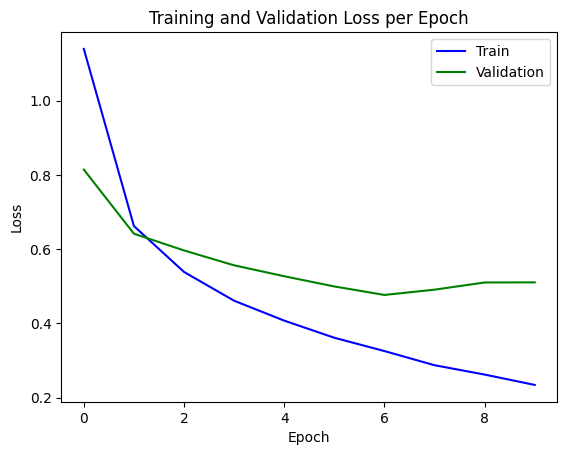

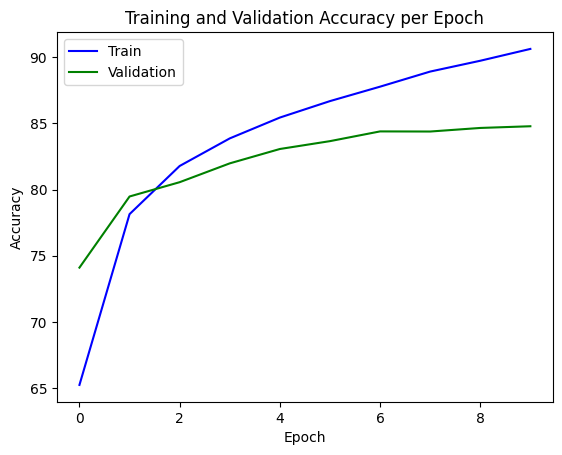

In [14]:
# Plotting Loss vs Epoch
epochList = range(n_epochs)
plt.plot(epochList, loss_lr, color='blue', label='Train')
plt.plot(epochList, val_loss_lr, color='green', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

# Plotting Accuracy vs Epoch
plt.plot(epochList, accuracies_lr, color='blue', label='Train')
plt.plot(epochList, acu_lr, color='green', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()
plt.show()

Testing MLP model on Testing Dataset

In [15]:
accu = 0 
total = 0 

with torch.no_grad(): 
    for data in testLoader: 
        inputs, outputs = data 
        outputs = outputs.to(torch.float32) 
        predicted_outputs = mlp_schedulers(inputs) 
        _, predicted = torch.max(predicted_outputs, 1) 
        total += outputs.size(0) 
        accu += (predicted == outputs).sum().item()
    test_accu =  100 * accu / total
    print("The test accuracy of the model {}%".format(test_accu))

The test accuracy of the model 84.20212765957447%


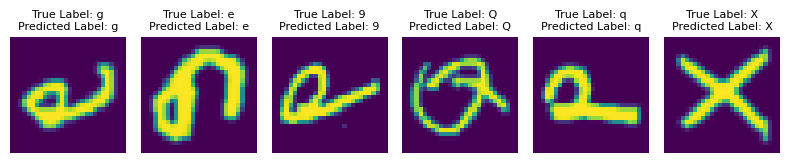

In [16]:
x_test, y_test = next(iter(testLoader))

with torch.no_grad():
    predicted_labels = mlp_schedulers(x_test)

_, predicted_labels = torch.max(predicted_labels, 1)

x_test = x_test.numpy()
true_labels = y_test.numpy()
predicted_labels = predicted_labels.numpy()
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(8, 8))
for i in range(6):
    ax = axes[i]
    img = np.transpose(x_test[i], (1, 2, 0))
    ax.imshow(img.squeeze())
    ax.set_title('True Label: {}\nPredicted Label: {}'.format(dataDict[true_labels[i]], dataDict[predicted_labels[i]]), fontsize = 8)
    ax.axis('off')

plt.tight_layout()
plt.show()

Confusion Matrix of MLP Model

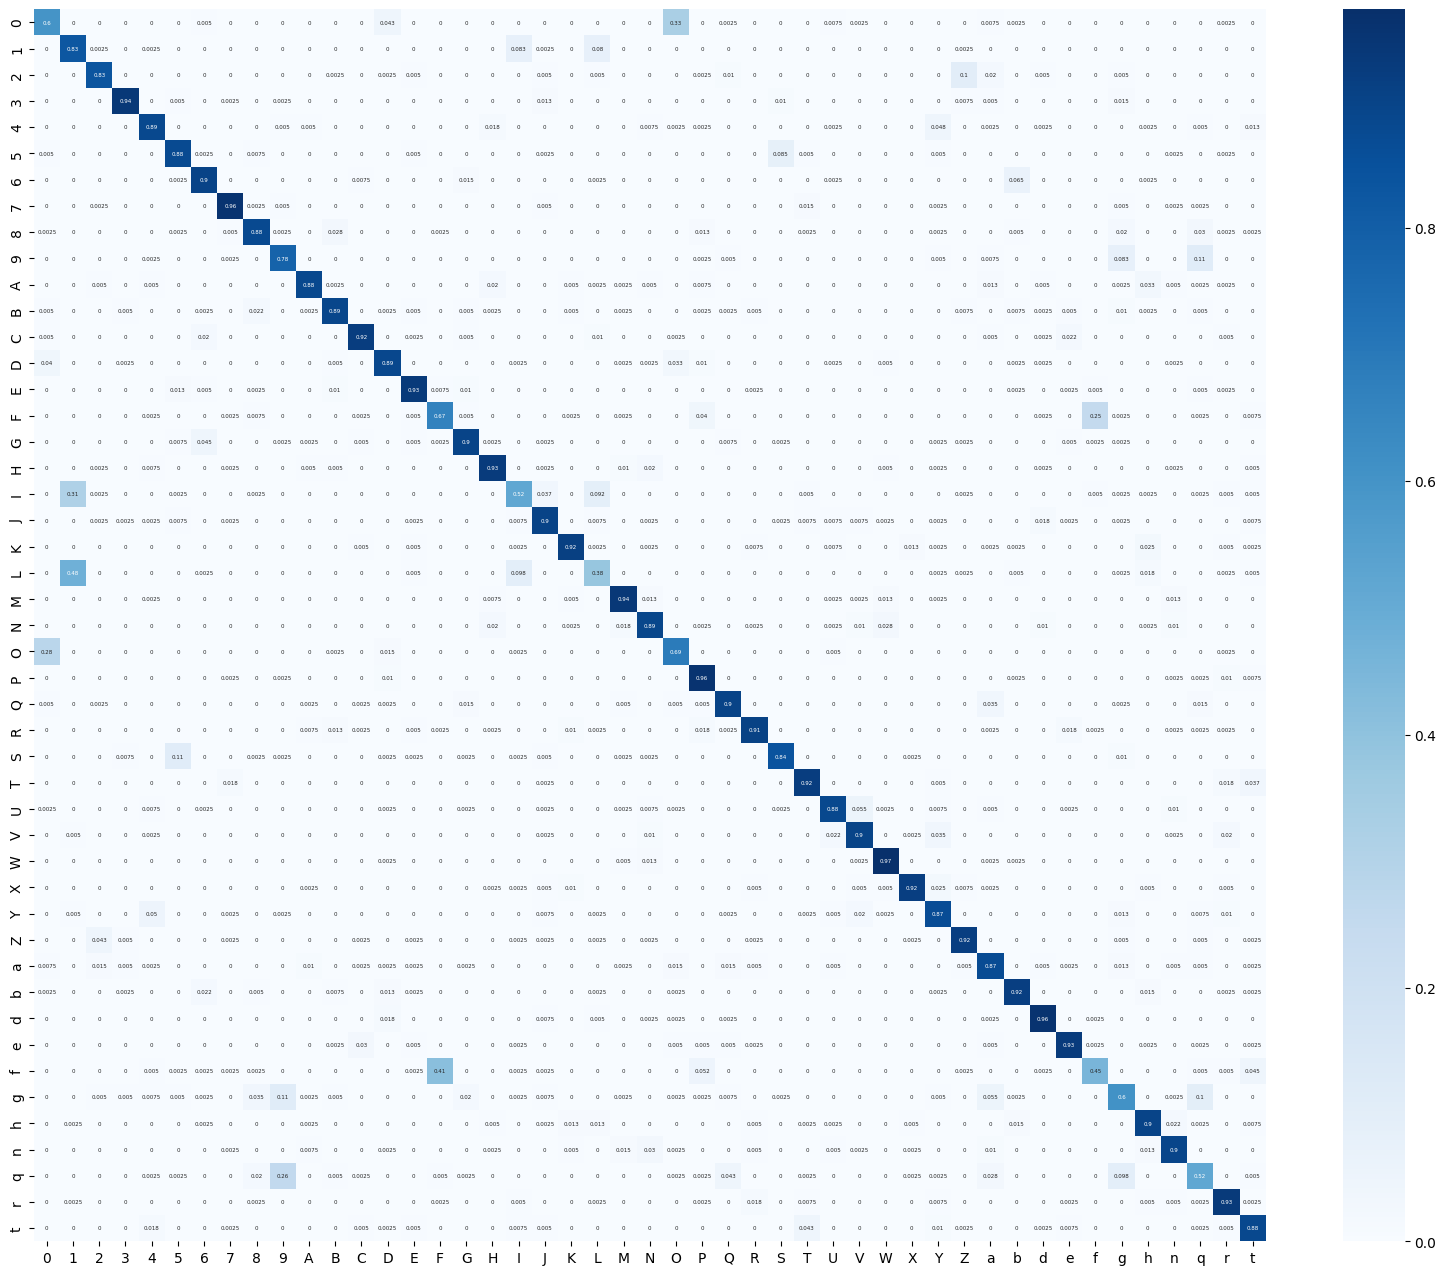

In [17]:
y_pred = []
y_true = []

for x_test, y_test in testLoader:
    prediction = mlp_schedulers(x_test) # Feed Network

    # Saving the prediction label
    prediction = (torch.max(torch.exp(prediction), 1)[1]).data.numpy()
    y_pred.extend(prediction) 
    
    # The true label
    y_test = y_test.data.numpy()
    y_true.extend(y_test)

# Getting the classes for axis
classes = (dataDict.values())

# Build confusion matrix
cm = confusion_matrix(y_true, y_pred)
cmDf = pd.DataFrame(cm / np.sum(cm, axis=1)[:, None], index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize=(20, 16))
sn.heatmap(cmDf, annot=True, annot_kws={"size": 4}, cmap='Blues', square=True) # Increase heatmap size and font size for annotations

plt.show()

In [18]:
# calculate precision, recall, F1-score, and accuracy iteratively
num_classes = 47
precision = np.zeros(num_classes)
recall = np.zeros(num_classes)
f1_score = np.zeros(num_classes)
accuracy = np.trace(cm) / np.sum(cm)

for i in range(num_classes):
    true_positive = cm[i, i]
    false_positive = np.sum(cm[:, i]) - true_positive
    false_negative = np.sum(cm[i, :]) - true_positive
    
    precision[i] = true_positive / (true_positive + false_positive)
    recall[i] = true_positive / (true_positive + false_negative)
    f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])

# calculate the average precision, recall, and F1-score
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_f1_score = np.mean(f1_score)

print("Precision: {}\n".format(precision))
print("Recall: {}\n".format(recall))
print("F1-score: {}\n".format(f1_score))
print("Accuracy: {}\n".format(accuracy))
print("==========")
print("Average Precision: {}\n".format(avg_precision))
print("Average Recall: {}\n".format(avg_recall))
print("Average F1-score: {}".format(avg_f1_score))

Precision: [0.62894737 0.50689127 0.90983607 0.96410256 0.88059701 0.84375
 0.88697789 0.95037221 0.88664987 0.6652452  0.9463807  0.91048593
 0.93164557 0.8808933  0.9325     0.60544218 0.91370558 0.91831683
 0.7003367  0.8804878  0.94087404 0.62040816 0.92839506 0.88148148
 0.63038549 0.84955752 0.89578164 0.93782383 0.88918206 0.90864198
 0.91688312 0.89303483 0.93961353 0.96833773 0.83014354 0.86150235
 0.80555556 0.88861985 0.93872549 0.92982456 0.62847222 0.67409471
 0.87560976 0.90862944 0.61721068 0.89448441 0.84449761]

Recall: [0.5975 0.8275 0.8325 0.94   0.885  0.8775 0.9025 0.9575 0.88   0.78
 0.8825 0.89   0.92   0.8875 0.9325 0.6675 0.9    0.9275 0.52   0.9025
 0.915  0.38   0.94   0.8925 0.695  0.96   0.9025 0.905  0.8425 0.92
 0.8825 0.8975 0.9725 0.9175 0.8675 0.9175 0.87   0.9175 0.9575 0.9275
 0.4525 0.605  0.8975 0.895  0.52   0.9325 0.8825]

F1-score: [0.61282051 0.62867996 0.8694517  0.95189873 0.88279302 0.86029412
 0.89467162 0.95392279 0.88331242 0.71806674 0.9

## **Tuning and Implementation of CNN**

In [19]:
# the base model for convolutional neural network is a simple model with which the final optimized model resulting from the model tuning will be compared.
# techniques used : constant learning rate
#                   activation - ReLU
#                   optimizer - SGD
#                   no batch normalisation
#                   no regularisation
#                   without dropout
#                   2 convolutional layers
                  
class ConvolutionalNet(nn.Module):
    def __init__(self, model):
        super(ConvolutionalNet, self).__init__()
        self.conv = model
       
    def forward(self, x):
        x = self.conv(x)
        return x

    def compute_l1(self, weights):
        return torch.abs(weights).sum()

    def compute_l2(self, weights):
        return torch.square(weights).sum()


### Base Model 
Similar to the MLP model, a base CNN model is created.

In [20]:

baseCNN = nn.Sequential(
    nn.Conv2d(1, 32, 5),    # the input channel is 1 for grayscale inputs
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 64, 5), 
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(64*4*4, 256, bias=True),
    nn.ReLU(),
    nn.Linear(256, 47, bias = False)
)


accuracies = [] # to store accuracies of each fold


# iterating through each fold
for i, (train_id, val_id) in enumerate(kfold.split(trainSet)):
    print(f'Fold #{i+1}\n------------------------')

    # taking random data objects with no replacement 
    trainSampler = SubsetRandomSampler(train_id)
    valSampler = SubsetRandomSampler(val_id)

    # creating dataloader objects for training and validation data in this fold
    train_fold = DataLoader(trainSet, batch_size=128, sampler=trainSampler)
    val_fold = DataLoader(trainSet, batch_size=128, sampler=valSampler)

    # initialising the model and the optimiser
    cnn_base = ConvolutionalNet(baseCNN)
    cnn_base.apply(resetting_weights)

    optimizer = optim.SGD(cnn_base.parameters(), lr=0.01)

    accu_fold = [] 

    # training for a certain number of epochs
    for epoch in range(n_epochs):

        start = time.time() 

        loss = 0
        totalTrain, correct_train_preds = 0, 0
        totalVal, correct_val_preds = 0, 0

        for batch, (images, labels) in enumerate(train_fold):

            optimizer.zero_grad()

            # training the images in this batch and getting accuracy
            output_train = cnn_base(images)

            train_values, train_pred_labels = torch.max(output_train.data, 1)
            totalTrain += labels.size(0)

            correct_train_preds += (labels == train_pred_labels).sum().item()

            # calculating the loss
            current_loss = lossCriteria(output_train, labels)   

            # back propagation
            current_loss.backward()

            # optimising the gradients
            optimizer.step()

            # adding the loss to the overall loss
            loss += current_loss.item()
            if batch % 100 == 99:
                loss = 0

        train_accu = (100 * correct_train_preds) / totalTrain

        end = time.time()   

        # testing the model obtained in this fold

        with torch.no_grad():

            for batch, (images, labels) in enumerate(val_fold):

                output_val = cnn_base(images)

                values, pred_labels = torch.max(output_val.data, 1)
                totalVal += labels.size(0)
                correct_val_preds += (labels == pred_labels).sum().item()

        # calculating accuracy for the fold
        val_accu = (correct_val_preds * 100) / totalVal 
        accu_fold.append(val_accu)

        print(f'\nEpoch {epoch+1}   Train Accuracy: {train_accu}   Validation Accuracy: {val_accu}')
        print(f'Time taken for training epoch {epoch+1}: {end - start} seconds\n')

    # the val accuracy of the last epoch is taken as the final val accuracy of the fold
    print(f'\nValidation accuracy of the fold: {accu_fold[-1]}')
    accuracies.append(accu_fold[-1])

# calculating the mean accuracy of the base model 
mean_accu = np.mean(accuracies)
print(f'\n\n Mean Accuracy of CNN Base Model: {mean_accu}')

Fold #1
------------------------

Epoch 1   Train Accuracy: 19.3096926713948   Validation Accuracy: 47.652482269503544
Time taken for training epoch 1: 77.69560956954956 seconds


Epoch 2   Train Accuracy: 59.02127659574468   Validation Accuracy: 64.19858156028369
Time taken for training epoch 2: 72.3615071773529 seconds


Epoch 3   Train Accuracy: 69.16430260047281   Validation Accuracy: 72.04964539007092
Time taken for training epoch 3: 72.82928133010864 seconds


Epoch 4   Train Accuracy: 74.58510638297872   Validation Accuracy: 76.5709219858156
Time taken for training epoch 4: 73.77289724349976 seconds


Epoch 5   Train Accuracy: 77.95626477541371   Validation Accuracy: 79.0354609929078
Time taken for training epoch 5: 72.9234721660614 seconds


Epoch 6   Train Accuracy: 79.83806146572104   Validation Accuracy: 80.50709219858156
Time taken for training epoch 6: 73.06521272659302 seconds


Epoch 7   Train Accuracy: 81.3806146572104   Validation Accuracy: 81.14893617021276
Time taken

### Getting the best activation function
Models are created and evaluated to identify the best activation function for CNN among the specified ones.

In [ ]:
activ_functions = {1: nn.ReLU(),
                   2: nn.LeakyReLU(),
                   3: nn.ELU(),
                   4: nn.Tanh()
                   }

for fn in activ_functions:

    model_activ = nn.Sequential(
        nn.Conv2d(1, 32, 5),    
        activ_functions[fn],
        nn.MaxPool2d(2, 2),
        nn.Conv2d(32, 64, 5), 
        activ_functions[fn],
        nn.MaxPool2d(2, 2),
        nn.Flatten(),
        nn.Linear(64*4*4, 256, bias=True),
        activ_functions[fn],
        nn.Linear(256, 47)
    )

    accuracies_activ = [] # to store accuracies of each fold


    # iterating through each fold
    for i, (train_id, val_id) in enumerate(kfold.split(trainSet)):
        print(f'\nFold #{i+1}\n------------------------')

        # taking random data objects with no replacement 
        train_sampler = SubsetRandomSampler(train_id)
        val_sampler = SubsetRandomSampler(val_id)

        # creating dataloader objects for training and validation data in this fold
        train_fold = DataLoader(trainSet, batch_size=128, sampler=train_sampler)
        val_fold = DataLoader(trainSet, batch_size=128, sampler=val_sampler)

        # initialising the model and the optimiser
        cnn_activ = ConvolutionalNet(model_activ)
        cnn_activ.apply(resetting_weights)
        optimizer_activ = optim.SGD(cnn_activ.parameters(), lr=0.01)

        accu_fold = [] 

        # training for a certain number of epochs
        for epoch in range(n_epochs):

            start = time.time() 

            loss = 0
            totalTrain, correct_train_preds = 0, 0
            totalVal, correct_val_preds = 0, 0


            for batch, (images, labels) in enumerate(train_fold):

                optimizer_activ.zero_grad()

                # training the images in this batch and getting accuracy
                output_train = cnn_activ(images)

                train_values, train_pred_labels = torch.max(output_train.data, 1)
                totalTrain += labels.size(0)

                correct_train_preds += (labels == train_pred_labels).sum().item()

                # calculating the loss
                current_loss = lossCriteria(output_train, labels)   

                # back propagation
                current_loss.backward()

                # optimising the gradients
                optimizer_activ.step()

                # adding the loss to the overall loss
                loss += current_loss.item()
                if batch % 100 == 99:
                    loss = 0

            train_accu = (100 * correct_train_preds) / totalTrain

            end = time.time()   
            
            # testing the model obtained in this fold

            with torch.no_grad():
                for batch, (images, labels) in enumerate(val_fold):

                    output_val = cnn_activ(images)

                    values, pred_labels = torch.max(output_val.data, 1)
                    totalVal += labels.size(0)
                    correct_val_preds += (labels == pred_labels).sum().item()

            # calculating accuracy for the fold
            val_accu = (correct_val_preds * 100) / totalVal 
            accu_fold.append(val_accu)

            print(f'\nEpoch {epoch+1}   Train Accuracy: {train_accu}   Validation Accuracy: {val_accu}')
            print(f'Time taken for training: {end - start} seconds')

        print(f'\nValidation accuracy of the fold: {accu_fold[-1]}\n')
        accuracies_activ.append(accu_fold[-1])

    # calculating the mean accuracy of the base model across all folds
    mean_accu = np.mean(accuracies_activ)

    if fn == 1: 
        print(f'\n\n Mean Accuracy of CNN Model with ReLU activation: {mean_accu}\n\n')
    elif fn == 2: 
        print(f'\n\n Mean Accuracy of CNN Model with Leaky ReLU activation: {mean_accu}\n\n')
    elif fn == 3: 
        print(f'\n\n Mean Accuracy of CNN Model with ELU activation: {mean_accu}\n\n')
    elif fn == 4:
        print(f'\n\n Mean Accuracy of CNN Model with Tanh activation: {mean_accu}\n\n')




Fold #1
------------------------
Reset trainable parameters of layer Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer Linear(in_features=1024, out_features=256, bias=True)
Reset trainable parameters of layer Linear(in_features=256, out_features=47, bias=True)

Epoch 1   Train Accuracy: 19.177748226950353   Validation Accuracy: 47.12765957446808
Time taken for training: 55.09452247619629 seconds

Epoch 2   Train Accuracy: 60.26152482269504   Validation Accuracy: 66.33421985815603
Time taken for training: 53.889408588409424 seconds

Epoch 3   Train Accuracy: 70.41666666666667   Validation Accuracy: 72.92996453900709
Time taken for training: 54.003623723983765 seconds

Epoch 4   Train Accuracy: 75.81006205673759   Validation Accuracy: 76.45390070921985
Time taken for training: 53.35031533241272 seconds

Epoch 5   Train Accuracy: 78.7355939716312   Validation Accuracy:

The ELU is found to be the best activation function and gives the maximum accuracy for this MLP model among all the four tested activation functions here. Therfore, ELU is chosen as the activation function for training the data to subsequently find the best MLP for the given dataset.

### Getting the best optimizer
The best optimizer is obtained by created and implementing different models with different optimizers and comparing the accuracies.

In [ ]:

model_optim = nn.Sequential(
        nn.Conv2d(1, 32, 5),    
        nn.ELU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(32, 64, 5), 
        nn.ELU(),
        nn.MaxPool2d(2, 2),
        nn.Flatten(),
        nn.Linear(64*4*4, 256, bias=True),
        nn.ELU(),
        nn.Linear(256, 47, bias=False)
    )

optim_functions = {1: 'SGD',
                   2: 'Adam',
                   3: 'RMSprop'
                   } 


for fn in optim_functions:

    accuracies_optim = [] # to store accuracies of each fold


    # iterating through each fold
    for i, (train_id, val_id) in enumerate(kfold.split(trainSet)):
        print(f'\nFold #{i+1}\n------------------------')

        # taking random data objects with no replacement 
        train_sampler = SubsetRandomSampler(train_id)
        val_sampler = SubsetRandomSampler(val_id)

        # creating dataloader objects for training and validation data in this fold
        train_fold = DataLoader(trainSet, batch_size=128, sampler=train_sampler)
        val_fold = DataLoader(trainSet, batch_size=128, sampler=val_sampler)

        # initialising the model and the optimiser
        cnn_optim = ConvolutionalNet(model_optim)
        cnn_optim.apply(resetting_weights)
        if fn == 1:
            optimizer_optim = optim.SGD(cnn_optim.parameters(), lr=0.01)
        elif fn == 2:
            optimizer_optim = optim.Adam(cnn_optim.parameters(), 0.001)
        elif fn == 3:
            optimizer_optim = optim.RMSprop(cnn_optim.parameters(), 0.001)
        
        accu_fold = [] 

        # training for a certain number of epochs
        for epoch in range(n_epochs):

            start = time.time() 

            loss = 0
            totalTrain, correct_train_preds = 0, 0
            totalVal, correct_val_preds = 0, 0

            for batch, (images, labels) in enumerate(train_fold):

                optimizer_optim.zero_grad()

                # training the images in this batch and getting accuracy
                output_train = cnn_optim(images)

                train_values, train_pred_labels = torch.max(output_train.data, 1)
                totalTrain += labels.size(0)

                correct_train_preds += (labels == train_pred_labels).sum().item()

                # calculating the loss 
                current_loss = lossCriteria(output_train, labels)   

                # back propagation
                current_loss.backward()

                # optimising the gradients
                optimizer_optim.step()

                # adding the loss to the overall loss
                loss += current_loss.item()
                if batch % 100 == 99:
                    loss = 0

            train_accu = (100 * correct_train_preds) / totalTrain

            end = time.time()   
           
            # testing the model obtained in this fold

            with torch.no_grad():
                for batch, (images, labels) in enumerate(val_fold):

                    output_val = cnn_optim(images)

                    values, pred_labels = torch.max(output_val.data, 1)
                    totalVal += labels.size(0)
                    correct_val_preds += (labels == pred_labels).sum().item()

            # calculating accuracy for the fold
            val_accu = (correct_val_preds * 100) / totalVal 
            accu_fold.append(val_accu)

            print(f'\nEpoch {epoch+1}   Train Accuracy: {train_accu}   Validation Accuracy: {val_accu}')
            print(f'Time taken for training: {end - start} seconds')

        # printing the val accuracy of the fold
        print(f'\nValidation accuracy of the fold: {accu_fold[-1]}\n')
        accuracies_optim.append(accu_fold[-1])

    # calculating the mean accuracy of the base model across all folds
    mean_accu = np.mean(accuracies_optim)

    if fn == 1: 
        print(f'\n\n Mean Accuracy of CNN Model with SGD optimizer: {mean_accu}\n\n')
    elif fn == 2: 
        print(f'\n\n Mean Accuracy of CNN Model with Adam optimizer: {mean_accu}\n\n')
    elif fn == 3: 
        print(f'\n\n Mean Accuracy of CNN Model with RMSprop optimizer: {mean_accu}\n\n')



Fold #1
------------------------
Reset trainable parameters of layer Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer Linear(in_features=1024, out_features=256, bias=True)
Reset trainable parameters of layer Linear(in_features=256, out_features=47, bias=False)

Epoch 1   Train Accuracy: 29.56892730496454   Validation Accuracy: 57.251773049645394
Time taken for training: 59.026962757110596 seconds

Epoch 2   Train Accuracy: 63.2491134751773   Validation Accuracy: 69.67198581560284
Time taken for training: 57.93487095832825 seconds

Epoch 3   Train Accuracy: 71.73648049645391   Validation Accuracy: 75.0354609929078
Time taken for training: 57.55195116996765 seconds

Epoch 4   Train Accuracy: 76.76640070921985   Validation Accuracy: 78.26241134751773
Time taken for training: 57.39854311943054 seconds

Epoch 5   Train Accuracy: 79.56338652482269   Validation Accuracy: 

### Using Batch Normalization
Batch normalisation is added to the best CNN model obtained in the previous step to check whether it leads to any improvement in the accuracy given by the model.

In [ ]:
model_batchnorm_cnn = nn.Sequential(
    nn.BatchNorm2d(1),
    nn.Conv2d(1, 32, 5),    
    nn.ELU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 64, 5), 
    nn.BatchNorm2d(64),
    nn.ELU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(64*4*4, 256, bias=True),
    nn.BatchNorm1d(256),
    nn.ELU(),
    nn.Linear(256, 47, bias=False)
)

In [ ]:

accuracies_bn = [] # to store accuracies of each fold


# iterating through each fold
for i, (train_id, val_id) in enumerate(kfold.split(trainSet)):
    print(f'\nFold #{i+1}\n------------------------')

    # taking random data objects with no replacement 
    trainSampler = SubsetRandomSampler(train_id)
    valSampler = SubsetRandomSampler(val_id)

    # creating dataloader objects for training and validation data in this fold
    train_fold = DataLoader(trainSet, batch_size=128, sampler=trainSampler)
    val_fold = DataLoader(trainSet, batch_size=128, sampler=valSampler)

    # initialising the model and the optimiser
    cnn_bn = ConvolutionalNet(model_batchnorm_cnn)
    cnn_bn.apply(resetting_weights)

    optimizer_bn = optim.RMSprop(cnn_bn.parameters(), 0.001)
    
    accu_fold = [] 

    # training for a certain number of epochs
    for epoch in range(n_epochs):

        start = time.time() 

        loss = 0
        totalTrain, correct_train_preds = 0, 0
        totalVal, correct_val_preds = 0, 0

        for batch, (images, labels) in enumerate(train_fold):

            optimizer_bn.zero_grad()

            # training the images in this batch and getting accuracy
            output_train = cnn_bn(images)

            train_values, train_pred_labels = torch.max(output_train.data, 1)
            totalTrain += labels.size(0)

            correct_train_preds += (labels == train_pred_labels).sum().item()

            # calculating the loss 
            current_loss = lossCriteria(output_train, labels)   

            # back propagation
            current_loss.backward()

            # optimising the gradients
            optimizer_bn.step()

            # adding the loss to the overall loss
            loss += current_loss.item()
            if batch % 100 == 99:
                loss = 0

        train_accu = (100 * correct_train_preds) / totalTrain

        end = time.time()   
        
        # testing the model obtained in this fold

        with torch.no_grad():
            for batch, (images, labels) in enumerate(val_fold):

                output_val = cnn_bn(images)

                values, pred_labels = torch.max(output_val.data, 1)
                totalVal += labels.size(0)
                correct_val_preds += (labels == pred_labels).sum().item()

        # calculating accuracy for the fold
        val_accu = (correct_val_preds * 100) / totalVal 
        accu_fold.append(val_accu)

        print(f'\nEpoch {epoch+1}   Train Accuracy: {train_accu}   Validation Accuracy: {val_accu}')
        print(f'Time taken for training: {end - start} seconds')

    # printing the val accuracy of the fold
    print(f'\nValidation accuracy of the fold: {accu_fold[-1]}\n')
    accuracies_bn.append(accu_fold[-1])

# calculating the mean accuracy of the base model across all folds
mean_accu = np.mean(accuracies_bn)

print(f'\n\n Mean Accuracy of CNN Model with Batch Normalisation: {mean_accu}\n\n')



Fold #1
------------------------
Reset trainable parameters of layer BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=1024, out_features=256, bias=True)
Reset trainable parameters of layer BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=256, out_features=47, bias=False)

Epoch 1   Train Accuracy: 81.6678486997636   Validation Accuracy: 84.56737588652483
Time taken for training: 27.0715172290802 seconds

Epoch 2   Train 

### Using Regularisation
Two models - one each with L1 and L2 regularisation - are to be created and accuracy has to be compared with the model having no L1 or L2 regularisation. The model which gives the highest accuracy will be chosen for the next step.

In [ ]:
# to store accuracies of each fold
accuracies_l1 = []
accuracies_l2 = []

weights = [(0.001, 0.005), (0.002, 0.006), (0.003, 0.007)]

for (l1_weight, l2_weight) in weights:

  print('l1_weight', l1_weight)
  print('l2_weight', l2_weight)
  
  # iterating through each fold
  for i, (train_id, val_id) in enumerate(kfold.split(trainSet)):
      print(f'\nFold #{i+1}\n------------------------')

      # taking random data objects with no replacement 
      trainSampler = SubsetRandomSampler(train_id)
      valSampler = SubsetRandomSampler(val_id)

      # creating dataloader objects for training and validation data in this fold
      train_fold = DataLoader(trainSet, batch_size=128, sampler=trainSampler)
      val_fold = DataLoader(trainSet, batch_size=128, sampler=valSampler)

      # initialising the model and the optimiser
      cnn_l1 = ConvolutionalNet(model_batchnorm_cnn)
      cnn_l1.apply(resetting_weights)
      optimizer_l1 = optim.RMSprop(cnn_l1.parameters(), lr=0.001)

      cnn_l2 = ConvolutionalNet(model_batchnorm_cnn)
      cnn_l2.apply(resetting_weights)
      optimizer_l2 = optim.RMSprop(cnn_l2.parameters(), lr=0.001, weight_decay = 1e-5)

      accu_fold_l1, accu_fold_l2 = [], []

      # training for a certain number of epochs
      for epoch in range(n_epochs):

          start = time.time() 

          loss_l1, loss_l2 = 0, 0
          totalTrain, correct_train_preds_l1, correct_train_preds_l2 = 0, 0, 0
          totalVal, correct_val_preds_l1, correct_val_preds_l2 = 0, 0, 0

          for batch, (images, labels) in enumerate(train_fold):

              optimizer_l1.zero_grad()
              optimizer_l2.zero_grad()

              # training the images in this batch and getting accuracies
              # for l1
              output_train_l1 = cnn_l1(images)
              train_values_l1, train_pred_labels_l1 = torch.max(output_train_l1.data, 1)
              
              correct_train_preds_l1 += (labels == train_pred_labels_l1).sum().item()

              # for l2
              output_train_l2 = cnn_l2(images)
              train_values_l2, train_pred_labels_l2 = torch.max(output_train_l2.data, 1)
              
              correct_train_preds_l2 += (labels == train_pred_labels_l2).sum().item()

              totalTrain += labels.size(0)


              # calculating the loss
              current_loss_l1 = lossCriteria(output_train_l1, labels)   
              current_loss_l2 = lossCriteria(output_train_l2, labels)  

              # computing l1 & l2 loss
              l1_params = []
              l2_params = []

              for parameter in cnn_l1.parameters():
                  l1_params.append(parameter.view(-1))
              l1 = l1_weight*cnn_l1.compute_l1(torch.cat(l1_params))

              for parameter in cnn_l2.parameters():
                  l2_params.append(parameter.view(-1))
              l2 = l2_weight*cnn_l2.compute_l2(torch.cat(l2_params))

              # adding the regularisation losses to the cost function loss
              current_loss_l1 += l1
              current_loss_l2 += l2

              # back propagation
              current_loss_l1.backward()
              current_loss_l2.backward()

              # optimising the gradients
              optimizer_l1.step()
              optimizer_l2.step()

              # adding the loss to the overall loss
              loss_l1 += current_loss_l1.item()
              loss_l2 += current_loss_l2.item()
              if batch % 100 == 99:
                  loss_l1, loss_l2 = 0, 0

          train_accu_l1 = (100 * correct_train_preds_l1) / totalTrain
          train_accu_l2 = (100 * correct_train_preds_l2) / totalTrain

          end = time.time()  
          
          # testing the model obtained in this fold

          with torch.no_grad():

              for batch, (images, labels) in enumerate(val_fold):

                  output_val_l1 = cnn_l1(images)
                  output_val_l2 = cnn_l2(images)

                  values_l1, pred_labels_l1 = torch.max(output_val_l1.data, 1)
                  values_l2, pred_labels_l2 = torch.max(output_val_l2.data, 1)
                  totalVal += labels.size(0)
                  
                  correct_val_preds_l1 += (labels == pred_labels_l1).sum().item()
                  correct_val_preds_l2 += (labels == pred_labels_l2).sum().item()

          # calculating val accuracy for the epoch
          val_accu_l1 = (correct_val_preds_l1 * 100) / totalVal 
          val_accu_l2 = (correct_val_preds_l2 * 100) / totalVal

          accu_fold_l1.append(val_accu_l1)
          accu_fold_l2.append(val_accu_l2)

          print(f'''\n  Epoch {epoch+1}   Train Accuracy (L1): {train_accu_l1}   Validation Accuracy (L1): {val_accu_l1}
              Train Accuracy (L2): {train_accu_l2}   Validation Accuracy (L2): {val_accu_l2}''')
          print(f'Time taken for training: {end - start} seconds')

      # printing the val accuracy of the fold
      print(f'\nValidation accuracy of the fold (L1): {accu_fold_l1[-1]}')
      accuracies_l1.append(accu_fold_l1[-1])
      print(f'\nValidation accuracy of the fold (L2): {accu_fold_l2[-1]}\n')
      accuracies_l2.append(accu_fold_l2[-1])
      
  # calculating the mean accuracy of models across all folds
  mean_accu_l1 = np.mean(accuracies_l1)
  print(f'\n\n Mean Accuracy of CNN Model with L1 (Lasso) Regularisation: {mean_accu_l1}\n')

  mean_accu_l2 = np.mean(accuracies_l2)
  print(f' Mean Accuracy of CNN Model with L2 (Ridge) Regularisation: {mean_accu_l2}\n\n')


l1_weight 0.001
l2_weight 0.005

Fold #1
------------------------
Reset trainable parameters of layer BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=1024, out_features=256, bias=True)
Reset trainable parameters of layer BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=256, out_features=47, bias=False)
Reset trainable parameters of layer BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset

### Using Dropout
Dropout is also a regularisation technique where a certain number of neurons are dropped randomly from the network so as to bring about a source of generalisation in the training process. This has often proven to be a good method of reducing overfitting and increasing the accuracy on the validation dataset.

In [ ]:
model_drop_cnn = nn.Sequential(
    nn.BatchNorm2d(1),
    nn.Conv2d(1, 32, 5),    
    nn.BatchNorm2d(32),
    nn.ELU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 64, 5), 
    nn.BatchNorm2d(64),
    nn.ELU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Dropout(0.2),
    nn.Linear(64*4*4, 256, bias=True),
    nn.BatchNorm1d(256),
    nn.ELU(),
    nn.Linear(256, 47, bias=False)
)

In [ ]:
accuracies_dp = [] # to store accuracies of each fold


# iterating through each fold
for i, (train_id, val_id) in enumerate(kfold.split(trainSet)):
    print(f'\nFold #{i+1}\n------------------------')

    # taking random data objects with no replacement 
    trainSampler = SubsetRandomSampler(train_id)
    valSampler = SubsetRandomSampler(val_id)

    # creating dataloader objects for training and validation data in this fold
    train_fold = DataLoader(trainSet, batch_size=128, sampler=trainSampler)
    val_fold = DataLoader(trainSet, batch_size=128, sampler=valSampler)

    # initialising the model and the optimiser
    cnn_drop = ConvolutionalNet(model_drop_cnn)
    cnn_drop.apply(resetting_weights)
    optimizer_dp = optim.RMSprop(cnn_drop.parameters(), lr=0.001)

    accu_fold = []

    # training for a certain number of epochs
    for epoch in range(n_epochs):

        start = time.time()

        loss = 0
        totalTrain, correct_train_preds = 0, 0
        totalVal, correct_val_preds = 0, 0

        for batch, (images, labels) in enumerate(train_fold):

            optimizer_dp.zero_grad()

            # training the images in this batch and getting accuracy
            output_train = cnn_drop(images)

            train_values, train_pred_labels = torch.max(output_train.data, 1)
            totalTrain += labels.size(0)

            correct_train_preds += (labels == train_pred_labels).sum().item() 

            # calculating the loss
            current_loss = lossCriteria(output_train, labels)   

            # backprop
            current_loss.backward()

            # optimising the gradients
            optimizer_dp.step()

            # adding the loss to the overall loss
            loss += current_loss.item()
            if batch % 100 == 99:
                loss = 0

        train_accu = (100 * correct_train_preds) / totalTrain

        end = time.time()   
        
        # testing the model obtained in this fold

        with torch.no_grad():
            for batch, (images, labels) in enumerate(val_fold):

                output_val = cnn_drop(images)

                values, pred_labels = torch.max(output_val.data, 1)
                totalVal += labels.size(0)
                correct_val_preds += (labels == pred_labels).sum().item()

        # calculating val accuracy for the epoch
        val_accu = (correct_val_preds * 100) / totalVal 
        accu_fold.append(val_accu)

        print(f'\nEpoch {epoch+1}   Train Accuracy: {train_accu}   Validation Accuracy: {val_accu}')
        print(f'Time taken for training: {end - start} seconds')

    # printing the val accuracy of the fold
    print(f'\nValidation accuracy of the fold: {accu_fold[-1]}\n')
    accuracies_dp.append(accu_fold[-1])

# calculating the mean accuracy of the base model across all folds
mean_accu = np.mean(accuracies_dp)

print(f'\n\n Mean Accuracy of CNN Model with Dropout: {mean_accu}\n\n')


Fold #1
------------------------
Reset trainable parameters of layer BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=1024, out_features=256, bias=True)
Reset trainable parameters of layer BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=256, out_features=47, bias=False)

Epoch 1   Train Accuracy: 79.28841607565012   Validation Accuracy: 84.177304964539
Time taken for training: 82.66002631187439 seconds

Epoch 2   Train 

Although including the dropout in the model does not lead to a decline in the performance of the model, it does not lead to any improvement in the performance either. So, dropout is deemed to be not required for the final tuned CNN model. 

### Using adaptive learning rate methods
Two adaptive learning rate methods are used to create models and trained to obtain their performance on the validation data. The one among the 3 options - StepLR, ExponentialLR, and constant learning rate - which gives the highest accuracy is included in the final model.

In [ ]:
scheduler_func_cnn = {1: 'StepLR',
                      2: 'ExponentialLR'}

for fn in scheduler_func_cnn:

    accuracies_lr = [] # to store accuracies of each fold

    # iterating through each fold
    for i, (train_id, val_id) in enumerate(kfold.split(trainSet)):
        print(f'\nFold #{i+1}\n------------------------')

        # taking random data objects with no replacement 
        train_sampler = SubsetRandomSampler(train_id)
        val_sampler = SubsetRandomSampler(val_id)

        # creating dataloader objects for training and validation data in this fold
        train_fold = DataLoader(trainSet, batch_size=128, sampler=train_sampler)
        val_fold = DataLoader(trainSet, batch_size=128, sampler=val_sampler)

        # initialising the model and the optimiser
        cnn_schedulers = ConvolutionalNet(model_drop_cnn)
        cnn_schedulers.apply(resetting_weights)
        optimizer_lr = optim.RMSprop(cnn_schedulers.parameters(), lr=0.001)

        if fn == 1:
            scheduler = optim.lr_scheduler.StepLR(optimizer_lr, step_size=3, gamma=0.75) 
        elif fn == 2:
            scheduler = optim.lr_scheduler.ExponentialLR(optimizer_lr, gamma=0.825) 

        accu_fold = []

        # training for a certain number of epochs
        for epoch in range(n_epochs):

            start = time.time() 

            loss = 0
            totalTrain, correct_train_preds = 0, 0
            totalVal, correct_val_preds = 0, 0

            for batch, (images, labels) in enumerate(train_fold):

                optimizer_lr.zero_grad()

                # training the images in this batch and getting accuracy
                output_train = cnn_schedulers(images)

                train_values, train_pred_labels = torch.max(output_train.data, 1)
                totalTrain += labels.size(0)

                correct_train_preds += (labels == train_pred_labels).sum().item() 

                # calculating the loss
                current_loss = lossCriteria(output_train, labels)   

                # back propagation
                current_loss.backward()

                # optimising the gradients
                optimizer_lr.step()

                lr = optimizer_lr.param_groups[0]['lr']

                # adding the loss to the overall loss
                loss += current_loss.item()
                if batch % 100 == 99:
                    loss = 0

            train_accu = (100 * correct_train_preds) / totalTrain

            end = time.time()   
            
            # testing the model obtained in this fold

            with torch.no_grad():
                for batch, (images, labels) in enumerate(val_fold):

                    output_val = cnn_schedulers(images)

                    values, pred_labels = torch.max(output_val.data, 1)
                    totalVal += labels.size(0)
                    correct_val_preds += (labels == pred_labels).sum().item()

            # calculating val accuracy for the epoch
            val_accu = (correct_val_preds * 100) / totalVal 
            accu_fold.append(val_accu)

            print(f'\nEpoch {epoch+1}   Train Accuracy: {train_accu}   Validation Accuracy: {val_accu}   Learning Rate: {lr}')
            print(f'Time taken for training fold: {end - start} seconds')

            scheduler.step() # updating the learning rate

        # printing the val accuracy of the fold
        print(f'\nValidation accuracy of the fold: {accu_fold[-1]}\n')
        accuracies_lr.append(accu_fold[-1])

    # calculating the mean accuracy of the base model across all folds
    mean_accu = np.mean(accuracies_lr)

    if fn == 1:
        print(f'\n\n Mean Accuracy of CNN Model with StepLR Learning Rate Scheduler: {mean_accu}\n\n')
    elif fn == 2:
        print(f'\n\n Mean Accuracy of CNN Model with ExponentialLR Learning Rate Scheduler: {mean_accu}\n\n')


Fold #1
------------------------
Reset trainable parameters of layer BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=1024, out_features=256, bias=True)
Reset trainable parameters of layer BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer Linear(in_features=256, out_features=47, bias=False)

Epoch 1   Train Accuracy: 79.48581560283688   Validation Accuracy: 83.80851063829788   Learning Rate: 0.001
Time taken for training fold: 88.7196404933

Final CNN Model on Training Dataset

In [ ]:
model_drop_cnn = nn.Sequential(
    nn.BatchNorm2d(1),
    nn.Conv2d(1, 32, 5),    
    nn.BatchNorm2d(32),
    nn.ELU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 64, 5), 
    nn.BatchNorm2d(64),
    nn.ELU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Dropout(0.2),
    nn.Linear(64*4*4, 256, bias=True),
    nn.BatchNorm1d(256),
    nn.ELU(),
    nn.Linear(256, 47, bias=False)
)

accuracies_lr = [] # to store accuracies of each fold
loss_lr = []
val_loss_lr= []
acu_lr = []
valSplit = 0.2
idx = list(range(len(trainSet)))
split = int(np.floor(valSplit * len(trainSet)))
train_id, val_id = idx[split:], idx[:split]

# taking random data objects with no replacement 
train_sampler = SubsetRandomSampler(train_id)
val_sampler = SubsetRandomSampler(val_id)

# creating dataloader objects for training and validation data in this fold
train_fold = DataLoader(trainSet, batch_size=128, sampler=train_sampler)
val_fold = DataLoader(trainSet, batch_size=128, sampler=val_sampler)

# initialising the model and the optimiser
cnn_schedulers = ConvolutionalNet(model_drop_cnn)
cnn_schedulers.apply(resetting_weights)
optimizer_lr = optim.RMSprop(cnn_schedulers.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.ExponentialLR(optimizer_lr, gamma=0.825) 

# training for a certain number of epochs
for epoch in range(n_epochs):

    start = time.time() 

    loss = 0
    val_loss = 0
    totalTrain, correct_train_preds = 0, 0
    totalVal, correct_val_preds = 0, 0

    for batch, (images, labels) in enumerate(train_fold):

        optimizer_lr.zero_grad()

        # training the images in this batch and getting accuracy
        output_train = cnn_schedulers(images)

        train_values, train_pred_labels = torch.max(output_train.data, 1)
        totalTrain += labels.size(0)

        correct_train_preds += (labels == train_pred_labels).sum().item() 

        # calculating the loss
        current_loss = lossCriteria(output_train, labels)   

        # back propagation
        current_loss.backward()

        # optimising the gradients
        optimizer_lr.step()

        lr = optimizer_lr.param_groups[0]['lr']

        # adding the loss to the overall loss
        loss += current_loss.item()

    train_accu = (100 * correct_train_preds) / totalTrain
    loss = loss/len(train_fold)
    loss_lr.append(loss)
    accuracies_lr.append(train_accu)

    end = time.time()   
    
    # testing the model obtained in this fold

    with torch.no_grad():
        for batch, (images, labels) in enumerate(val_fold):

            output_val = cnn_schedulers(images)

            values, pred_labels = torch.max(output_val.data, 1)
            totalVal += labels.size(0)
            correct_val_preds += (labels == pred_labels).sum().item()

            # calculating the loss
            current_loss_val = lossCriteria(output_val, labels)
            val_loss += current_loss_val.item()

    # calculating val accuracy for the epoch
    val_accu = (correct_val_preds * 100) / totalVal 
    val_loss = val_loss/len(val_fold)
    val_loss_lr.append(val_loss) 
    acu_lr.append(val_accu)

    print(f'\nEpoch {epoch+1}   Train Accuracy: {train_accu}   Validation Accuracy: {val_accu}  Train Loss: {loss}  Val Loss: {val_loss}')
    print(f'Time taken for training: {end - start} seconds')

    scheduler.step() # updating the learning rate


Epoch 1   Train Accuracy: 80.78679078014184   Validation Accuracy: 84.09574468085107  Train Loss: 0.6068068221951207  Val Loss: 0.47581803596625893
Time taken for training: 154.57111811637878 seconds

Epoch 2   Train Accuracy: 85.84109042553192   Validation Accuracy: 85.97074468085107  Train Loss: 0.4107838122557241  Val Loss: 0.41279298546960796
Time taken for training: 151.46420192718506 seconds

Epoch 3   Train Accuracy: 87.24069148936171   Validation Accuracy: 86.90602836879432  Train Loss: 0.3594337659524688  Val Loss: 0.3854513585904224
Time taken for training: 145.28345322608948 seconds

Epoch 4   Train Accuracy: 88.2457890070922   Validation Accuracy: 87.10549645390071  Train Loss: 0.3266389992008818  Val Loss: 0.3734576548055067
Time taken for training: 174.0046854019165 seconds

Epoch 5   Train Accuracy: 88.85859929078015   Validation Accuracy: 87.42021276595744  Train Loss: 0.30476872502489294  Val Loss: 0.3586886722152516
Time taken for training: 193.76003980636597 seconds

In [21]:
model_drop_cnn = nn.Sequential(
    nn.BatchNorm2d(1),
    nn.Conv2d(1, 32, 5),    
    nn.BatchNorm2d(32),
    nn.ELU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 64, 5), 
    nn.BatchNorm2d(64),
    nn.ELU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Dropout(0.2),
    nn.Linear(64*4*4, 256, bias=True),
    nn.BatchNorm1d(256),
    nn.ELU(),
    nn.Linear(256, 47, bias=False)
)

accuracies_lr = [] # to store accuracies of each fold
loss_lr = []
val_loss_lr= []
acu_lr = []
valSplit = 0.2
idx = list(range(len(trainSet)))
split = int(np.floor(valSplit * len(trainSet)))
train_id, val_id = idx[split:], idx[:split]

# taking random data objects with no replacement 
train_sampler = SubsetRandomSampler(train_id)
val_sampler = SubsetRandomSampler(val_id)

# creating dataloader objects for training and validation data in this fold
train_fold = DataLoader(trainSet, batch_size=128, sampler=train_sampler)
val_fold = DataLoader(trainSet, batch_size=128, sampler=val_sampler)

# initialising the model and the optimiser
cnn_schedulers = ConvolutionalNet(model_drop_cnn)
cnn_schedulers.apply(resetting_weights)
optimizer_lr = optim.RMSprop(cnn_schedulers.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.ExponentialLR(optimizer_lr, gamma=0.825) 

# training for a certain number of epochs
for epoch in range(n_epochs):

    start = time.time() 

    loss = 0
    val_loss = 0
    totalTrain, correct_train_preds = 0, 0
    totalVal, correct_val_preds = 0, 0

    for batch, (images, labels) in enumerate(train_fold):

        optimizer_lr.zero_grad()

        # training the images in this batch and getting accuracy
        output_train = cnn_schedulers(images)

        train_values, train_pred_labels = torch.max(output_train.data, 1)
        totalTrain += labels.size(0)

        correct_train_preds += (labels == train_pred_labels).sum().item() 

        # calculating the loss
        current_loss = lossCriteria(output_train, labels)   

        # back propagation
        current_loss.backward()

        # optimising the gradients
        optimizer_lr.step()

        lr = optimizer_lr.param_groups[0]['lr']

        # adding the loss to the overall loss
        loss += current_loss.item()

    train_accu = (100 * correct_train_preds) / totalTrain
    loss = loss/len(train_fold)
    loss_lr.append(loss)
    accuracies_lr.append(train_accu)

    end = time.time()   
    
    # testing the model obtained in this fold

    with torch.no_grad():
        for batch, (images, labels) in enumerate(val_fold):

            output_val = cnn_schedulers(images)

            values, pred_labels = torch.max(output_val.data, 1)
            totalVal += labels.size(0)
            correct_val_preds += (labels == pred_labels).sum().item()

            # calculating the loss
            current_loss_val = lossCriteria(output_val, labels)
            val_loss += current_loss_val.item()

    # calculating val accuracy for the epoch
    val_accu = (correct_val_preds * 100) / totalVal 
    val_loss = val_loss/len(val_fold)
    val_loss_lr.append(val_loss) 
    acu_lr.append(val_accu)

    print(f'\nEpoch {epoch+1}   Train Accuracy: {train_accu}   Validation Accuracy: {val_accu}  Train Loss: {loss}  Val Loss: {val_loss}')
    print(f'Time taken for training: {end - start} seconds')

    scheduler.step() # updating the learning rate


Epoch 1   Train Accuracy: 80.73914007092199   Validation Accuracy: 84.08244680851064  Train Loss: 0.6052726716859966  Val Loss: 0.47147700956649025
Time taken for training: 120.96477961540222 seconds

Epoch 2   Train Accuracy: 85.68705673758865   Validation Accuracy: 85.71365248226951  Train Loss: 0.41229797451631395  Val Loss: 0.41658605054273445
Time taken for training: 111.60054683685303 seconds

Epoch 3   Train Accuracy: 87.34596631205673   Validation Accuracy: 86.60904255319149  Train Loss: 0.36075555443341006  Val Loss: 0.3844463811755854
Time taken for training: 111.73057818412781 seconds

Epoch 4   Train Accuracy: 88.07734929078015   Validation Accuracy: 87.14095744680851  Train Loss: 0.327691557601834  Val Loss: 0.370949583538508
Time taken for training: 111.81090331077576 seconds

Epoch 5   Train Accuracy: 88.86857269503547   Validation Accuracy: 87.95656028368795  Train Loss: 0.30432668894740705  Val Loss: 0.3543787152416962
Time taken for training: 110.18937420845032 secon

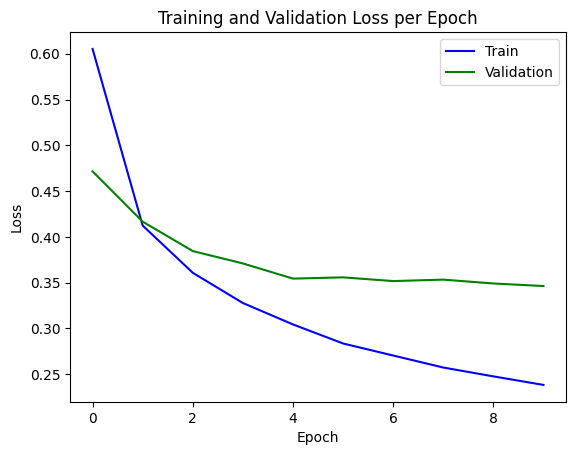

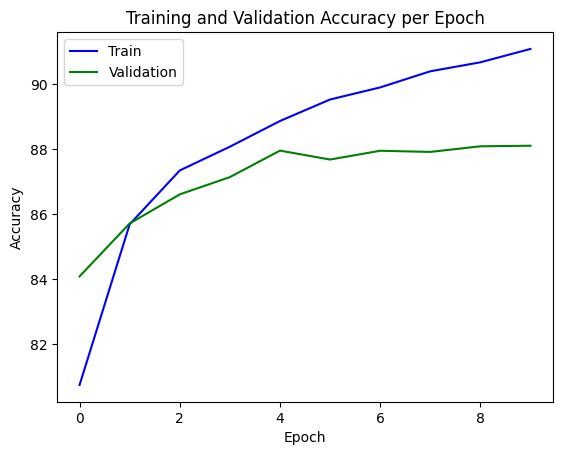

In [22]:
import matplotlib.pyplot as plt
# Plotting Loss vs Epoch
epochList = range(n_epochs)
plt.plot(epochList, loss_lr, color='blue', label='Train')
plt.plot(epochList, val_loss_lr, color='green', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

# Plotting Accuracy vs Epoch
plt.plot(epochList, accuracies_lr, color='blue', label='Train')
plt.plot(epochList, acu_lr, color='green', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()
plt.show()

Testing the CNN model on the Testing Dataset

In [ ]:
accu = 0 
total = 0 

with torch.no_grad(): 
    for data in testLoader: 
        inputs, outputs = data 
        outputs = outputs.to(torch.float32) 
        predicted_outputs = cnn_schedulers(inputs) 
        _, predicted = torch.max(predicted_outputs, 1) 
        total += outputs.size(0) 
        accu += (predicted == outputs).sum().item()
    test_accu =  100 * accu / total
    print("The test accuracy of the model {}%".format(test_accu))

The test accuracy of the model 87.65425531914893%


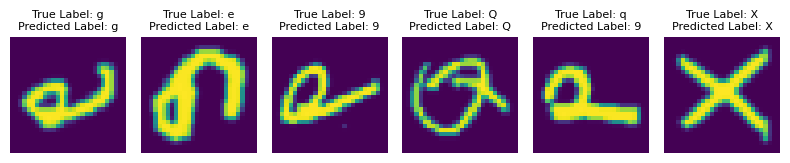

In [ ]:
x_test, y_test = next(iter(testLoader))

with torch.no_grad():
    predicted_labels = cnn_schedulers(x_test)

_, predicted_labels = torch.max(predicted_labels, 1)

x_test = x_test.numpy()
true_labels = y_test.numpy()
predicted_labels = predicted_labels.numpy()
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(8, 8))
for i in range(6):
    ax = axes[i]
    img = np.transpose(x_test[i], (1, 2, 0))
    ax.imshow(img.squeeze())
    ax.set_title('True Label: {}\nPredicted Label: {}'.format(dataDict[true_labels[i]], dataDict[predicted_labels[i]]), fontsize = 8)
    ax.axis('off')

plt.tight_layout()
plt.show()

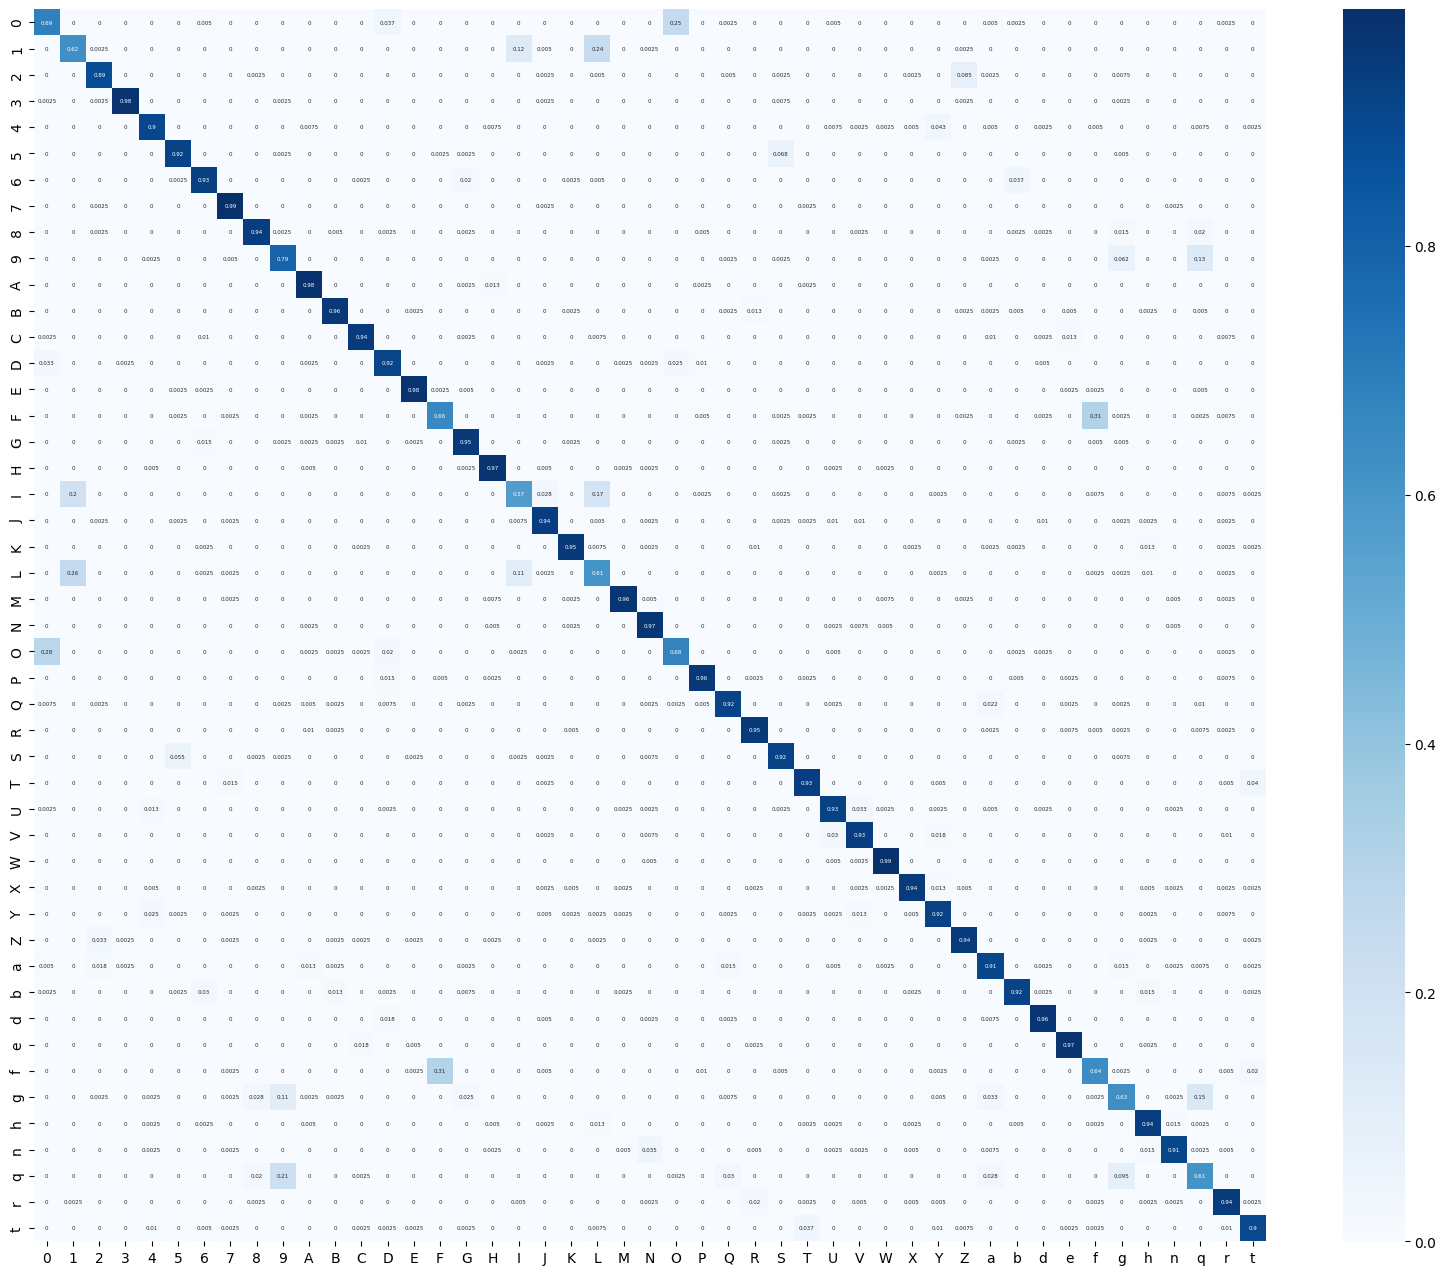

In [23]:
y_pred = []
y_true = []

for x_test, y_test in testLoader:
    prediction = cnn_schedulers(x_test) # Feed Network

    # Saving the prediction label
    prediction = (torch.max(torch.exp(prediction), 1)[1]).data.numpy()
    y_pred.extend(prediction) 
    
    # The true label
    y_test = y_test.data.numpy()
    y_true.extend(y_test)

# Getting the classes for axis
classes = (dataDict.values())

# Build confusion matrix
cm = confusion_matrix(y_true, y_pred)
cmDf = pd.DataFrame(cm / np.sum(cm, axis=1)[:, None], index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize=(20, 16))
sn.heatmap(cmDf, annot=True, annot_kws={"size": 4}, cmap='Blues', square=True) # Increase heatmap size and font size for annotations

plt.show()

In [24]:
# calculate precision, recall, F1-score, and accuracy iteratively
num_classes = 47
precision = np.zeros(num_classes)
recall = np.zeros(num_classes)
f1_score = np.zeros(num_classes)
accuracy = np.trace(cm) / np.sum(cm)

for i in range(num_classes):
    true_positive = cm[i, i]
    false_positive = np.sum(cm[:, i]) - true_positive
    false_negative = np.sum(cm[i, :]) - true_positive
    
    precision[i] = true_positive / (true_positive + false_positive)
    recall[i] = true_positive / (true_positive + false_negative)
    f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])

# calculate the average precision, recall, and F1-score
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_f1_score = np.mean(f1_score)

print("Precision: {}\n".format(precision))
print("Recall: {}\n".format(recall))
print("F1-score: {}\n".format(f1_score))
print("Accuracy: {}\n".format(accuracy))
print("==========")
print("Average Precision: {}\n".format(avg_precision))
print("Average Recall: {}\n".format(avg_recall))
print("Average F1-score: {}".format(avg_f1_score))

Precision: [0.67073171 0.5787037  0.92913386 0.99238579 0.93041237 0.92929293
 0.92537313 0.95652174 0.94221106 0.70444444 0.94230769 0.96473552
 0.95696203 0.89486553 0.97994987 0.67352185 0.92439024 0.95577396
 0.69486405 0.92345679 0.97435897 0.56511628 0.97969543 0.9216152
 0.70496084 0.95989975 0.92929293 0.94554455 0.90394089 0.94191919
 0.91831683 0.92098765 0.97530864 0.96923077 0.89563107 0.8957346
 0.87019231 0.93384224 0.965      0.96526055 0.64720812 0.73177843
 0.92821782 0.95778364 0.63636364 0.91041162 0.91794872]

Recall: [0.6875 0.625  0.885  0.9775 0.9025 0.92   0.93   0.99   0.9375 0.7925
 0.98   0.9575 0.945  0.915  0.9775 0.655  0.9475 0.9725 0.575  0.935
 0.95   0.6075 0.965  0.97   0.675  0.9575 0.92   0.955  0.9175 0.9325
 0.9275 0.9325 0.9875 0.945  0.9225 0.945  0.905  0.9175 0.965  0.9725
 0.6375 0.6275 0.9375 0.9075 0.6125 0.94   0.895 ]

F1-score: [0.67901235 0.60096154 0.90653009 0.98488665 0.91624365 0.92462312
 0.9276808  0.97297297 0.93984962 0.74588235